In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import dtale
import dtale.app as dtale_app

from scipy.stats import pearsonr
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy # for feature selection 
# from mlxtend.feature_selection import SequentialFeatureSelector           # http://rasbt.github.io/mlxtend/
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split

## Load Data 

<p>
To load data from a pandas DataFrame, you can use the pandas.read_csv() function. This function takes in the file path of the CSV file as the first argument, and returns a DataFrame object. For example, if you have a CSV file named "data.csv" in the same directory as your Python script, you can load it into a DataFrame like this:
</p>

In [45]:
# load the data using DataFrame

data = pd.read_csv('./amex-default-prediction/train_data.csv')
print(f'{data.shape[0]} rows \n{data.shape[1]} columns')

categorical_values = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] # this list is provided in problum distrivution 
num_features = [col for col in data.columns if col not in categorical_values ]

data.head(5)

5531451 rows 
190 columns


customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   

   D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
0    NaN    NaN    NaN  0.002427  0.003706  0.003818    NaN  0.000569   
1    NaN    NaN    NaN  0.003954  0.003167  0.005032    NaN  0.009576   
2    NaN    NaN    NaN  0.003269  0.007329  0.000427    NaN  0.003429   
3    NaN    NaN    NaN  0.006117  0.004516  0.003200    NaN  0.008419   
4    NaN    NaN    NaN  0.003671  0.004946  0.008889    NaN  0.001670   

      D_144     D_145  
0  0.000610  0.002674  
1  0.005492  0.009217  
2  0.006986  0.002603  
3  0.006527  0.009600  
4  0.008126  0.009827  

[5 rows x 190 columns]

In [46]:
# load the data labels 

data_labels = pd.read_csv('./amex-default-prediction/train_labels.csv')
data_labels.head(5)

customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0

In [47]:
# we merge 'data' tabel and 'data lable table'

df = pd.merge(data, data_labels, on= 'customer_ID')
del data, data_labels
df.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   

   D_137  D_138     D_139     D_140     D_141  D_142     D_143     D_144  \
0    NaN    NaN  0.002427  0.003706  0.003818    NaN  0.000569  0.000610   
1    NaN    NaN  0.003954  0.003167  0.005032    NaN  0.009576  0.005492   
2    NaN    NaN  0.003269  0.007329  0.000427    NaN  0.003429  0.006986   
3    NaN    NaN  0.006117  0.004516  0.003200    NaN  0.008419  0.006527   
4    NaN    NaN  0.003671  0.004946  0.008889    NaN  0.001670  0.008126   

      D_145  target  
0  0.002674       0  
1  0.009217       0  
2  0.002603       0  
3  0.009600       0  
4  0.009827       0  

[5 rows x 191 columns]

## Handle 'NaN' values

<p>
Handling NaN (Not a Number) values is important because they can cause errors and unexpected results when performing mathematical operations or when training machine learning models. NaN values can also indicate missing or invalid data, and ignoring them can lead to inaccurate conclusions or predictions. Properly handling NaN values, such as by replacing them with a suitable substitute value or removing them from the dataset, can help ensure that the data is accurate and the results are reliable. 
</p>

In [20]:
features_to_drop = []

In [48]:


# iterate through every column
for col in df.columns:

    # c alculate percentage of missing values
    missing_values = (df[col].isna().sum() / df.shape[0]) *100
    

    # if the feature has 60% of the data missing 
    if missing_values >= 50 :
        print(f'{col} has {missing_values} % of values missing')
        features_to_drop.append(col)

# drop the features 
df.drop(labels=features_to_drop , axis= 1, inplace=True)

D_42 has 85.69427804747795 % of values missing
D_49 has 90.13759680778153 % of values missing
D_50 has 56.80972316305433 % of values missing
D_53 has 73.84292114311417 % of values missing
D_56 has 54.07158085645158 % of values missing
S_9 has 53.035686296416614 % of values missing
B_17 has 56.72287434165104 % of values missing
D_66 has 88.73073267755603 % of values missing
D_73 has 98.99021070601547 % of values missing
D_76 has 88.74622589985883 % of values missing
R_9 has 94.34989119491432 % of values missing
D_82 has 73.37340600142711 % of values missing
B_29 has 93.1045940748639 % of values missing
D_87 has 99.93012683290515 % of values missing
D_88 has 99.891457051685 % of values missing
D_105 has 54.6227563075222 % of values missing
D_106 has 90.21325507538619 % of values missing
R_26 has 88.98471666837507 % of values missing
D_108 has 99.4768461295237 % of values missing
D_110 has 99.43353018945662 % of values missing
D_111 has 99.43353018945662 % of values missing
B_39 has 99.39

In [51]:
# preview of the data 
df.head()

customer_ID       P_2      D_39  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.938469  0.001733   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.936665  0.005775   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.954180  0.091505   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.960384  0.002455   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.947248  0.002483   

        B_1       B_2       R_1       S_3      D_41       B_3  D_43  ...  \
0  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709   NaN  ...   
1  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714   NaN  ...   
2  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423   NaN  ...   
3  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531   NaN  ...   
4  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312   NaN  ...   

      D_131     D_133      R_28     D_139     D_140     D_141     D_143  \
0  0.005972  0.004345  0.001535  0.002427  0.003706  0.003818  0.000569   
1  0.004838  0.007495  0.004931  0.003954  0.003167  0.005032  0.009576   
2  0.005497  0.009227  0.009123  0.003269  0.007329  0.000427  0.003429   
3  0.008261  0.007206  0.002409  0.006117  0.004516  0.003200  0.008419   
4  0.004848  0.006312  0.004462  0.003671  0.004946  0.008889  0.001670   

      D_144     D_145  target  
0  0.000610  0.002674       0  
1  0.005492  0.009217       0  
2  0.006986  0.002603       0  
3  0.006527  0.009600       0  
4  0.008126  0.009827       0  

[5 rows x 160 columns]

In [4]:
# save the new data frame 
df.to_csv('./data.csv', index= False, )

In [2]:
df = pd.read_csv('./data.csv')

categorical_values = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] # this list is provided in problum distrivution 
num_features = [col for col in df.columns if col not in categorical_values ][1:-1]

df.head()

customer_ID       P_2      D_39  \
0  bc3d3b33105f5a9de5ba4eb20c34f150c0b1f4b950998b...  0.208461  0.206676   
1  2aacaff13fa3b19cf3b87aa98c04238ce15445d19f1cf0...  0.453220  0.535671   
2  c99e0463e5c417f564c36a81c9db1f41407850cddd3a32...  0.406082  0.004142   
3  b58fc495879f332bc82d9ccc044154542b53fc703f60b3...  0.498445  0.003840   
4  2129215e280ea7171bdc99fd1cf1cbfd5e087b56535af3...  0.893139  0.009237   

        B_1       B_2       R_1       S_3      D_41       B_3      D_43  ...  \
0  0.027698  1.007244  0.252472  0.131432  0.245823  0.052778  0.046069  ...   
1  0.752900  0.029587  0.003671  0.228413  1.818231  1.304987  0.116203  ...   
2  0.010281  1.003799  0.001081  0.119489  0.006432  0.006191  0.029338  ...   
3  0.018704  0.042561  0.003432  0.336864  0.002839  0.255572  0.360569  ...   
4  0.003413  0.815016  0.009802       NaN  0.005154  0.007223  0.074571  ...   

      D_131     D_133      R_28     D_139     D_140     D_141     D_143  \
0  0.007367  0.003840  0.000160  0.002513  0.004340  0.000855  0.003104   
1  0.992701  0.507789  0.002646  0.005442  0.008170  0.008612  0.003582   
2  1.004377  1.056963  0.004519  0.005278  0.009998  0.009582  0.007489   
3  0.996161  0.304561  0.004341  1.001511  0.006102  0.965545  1.007801   
4  0.001099  0.009916  0.004497  0.009074  0.004368  0.008380  0.005040   

      D_144     D_145  target  
0  0.007126  0.002654       0  
1  0.007673  0.000109       1  
2  0.005823  0.000753       1  
3  0.629242  0.365399       0  
4  0.006041  0.005025       0  

[5 rows x 160 columns]

<p>
Breaking data into batches is a common technique used in machine learning to make the training process more efficient and scalable. This is done because:
<ol>
<li> Computational Efficiency: Training a model on large datasets can take a significant amount of time and computing resources. Breaking the data into smaller batches reduces the amount of memory needed to store intermediate results and makes it possible to train the model on a single machine. </li>
<li> Parallel Processing: When data is broken into smaller batches, each batch can be processed in parallel on multiple GPUs or CPU cores. This significantly speeds up the training process and can significantly reduce the time required to train a model. </li>
<li> Regularization: Batches introduce some randomness into the training process, which can help to prevent overfitting and improve the model's generalization performance.</li>
</ol>
Overall, batching is a critical technique used in modern deep learning to allow models to be trained effectively on large datasets.

</p>

In [55]:
# creating a new data frame where number of recors are zero and the columns are same 
data_stack = pd.DataFrame(columns= df.columns)

# using 'np.array_split()' function here I split the data set with the 5Million recors to 12 different parts 
for batch, chunk in enumerate(np.array_split(df, 12)):

    print(f'batch {batch} -> data_stack has {data_stack.shape[0]} records')

    """
    I tereate through every numerical features to fill in NAN values based on the output class they belong to 
    """
    for col in num_features:

        x = chunk['target']  == 0
        chunk.loc[x , col] =  chunk.groupby(by = 'target')[col].agg('mean')[0]
        
        y = chunk['target']  == 1
        chunk.loc[y , col] = chunk.groupby(by = 'target')[col].agg('mean')[1]


    """
    we then concat the filled NANA values to our 'data_stack' variable 
    """
    data_stack = pd.concat([data_stack, chunk] )

    del chunk

# # save the new data frame 
data_stack.to_csv('./data.csv', index= False )

# preview of data
data_stack.head()

customer_ID       P_2      D_39  \
0  bc3d3b33105f5a9de5ba4eb20c34f150c0b1f4b950998b...  0.742327  0.124818   
1  2aacaff13fa3b19cf3b87aa98c04238ce15445d19f1cf0...  0.396127  0.238911   
2  c99e0463e5c417f564c36a81c9db1f41407850cddd3a32...  0.396127  0.238911   
3  b58fc495879f332bc82d9ccc044154542b53fc703f60b3...  0.742327  0.124818   
4  2129215e280ea7171bdc99fd1cf1cbfd5e087b56535af3...  0.742327  0.124818   

        B_1       B_2       R_1       S_3      D_41       B_3      D_43  ...  \
0  0.076417  0.732869  0.031434  0.186681  0.031036  0.074354  0.116648  ...   
1  0.266711  0.284727  0.222239  0.325201  0.146772  0.308318  0.251702  ...   
2  0.266711  0.284727  0.222239  0.325201  0.146772  0.308318  0.251702  ...   
3  0.076417  0.732869  0.031434  0.186681  0.031036  0.074354  0.116648  ...   
4  0.076417  0.732869  0.031434  0.186681  0.031036  0.074354  0.116648  ...   

      D_131     D_133      R_28     D_139     D_140     D_141     D_143  \
0  0.064767  0.032789  0.005326  0.152060  0.016687  0.140480  0.151917   
1  0.224156  0.088281  0.007048  0.261712  0.055567  0.238704  0.261570   
2  0.224156  0.088281  0.007048  0.261712  0.055567  0.238704  0.261570   
3  0.064767  0.032789  0.005326  0.152060  0.016687  0.140480  0.151917   
4  0.064767  0.032789  0.005326  0.152060  0.016687  0.140480  0.151917   

      D_144     D_145  target  
0  0.053384  0.049740       0  
1  0.050624  0.100623       1  
2  0.050624  0.100623       1  
3  0.053384  0.049740       0  
4  0.053384  0.049740       0  

[5 rows x 160 columns]

In [3]:
# re-read the processed data

df = pd.read_csv('./data.csv')
df.drop(labels= 'customer_ID', axis= 1, inplace= True)

categorical_values = ['B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68'] # this list is provided in problum distrivution 
num_features = [col for col in df.columns if col not in categorical_values ][:-1]

# data preview 
print(f'{df.shape[0]} rows \n{df.shape[1]} columns')
df.head()

5531451 rows 
159 columns


P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
1  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
2  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
3  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

        B_3      D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
1  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
2  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
3  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
4  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   

      D_140     D_141     D_143     D_144     D_145  target  
0  0.016687  0.140480  0.151917  0.053384  0.049740       0  
1  0.055567  0.238704  0.261570  0.050624  0.100623       1  
2  0.055567  0.238704  0.261570  0.050624  0.100623       1  
3  0.016687  0.140480  0.151917  0.053384  0.049740       0  
4  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

In [4]:
# while delaing with the handling NAN values for the categorical features we will just drop the recors as the number of records load as minimal 
df.dropna(inplace= True)

# data preview 
print(f'{df.shape[0]} rows \n{df.shape[1]} columns')
df.head()

5295475 rows 
159 columns


P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
1  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
2  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
3  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

        B_3      D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
1  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
2  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
3  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
4  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   

      D_140     D_141     D_143     D_144     D_145  target  
0  0.016687  0.140480  0.151917  0.053384  0.049740       0  
1  0.055567  0.238704  0.261570  0.050624  0.100623       1  
2  0.055567  0.238704  0.261570  0.050624  0.100623       1  
3  0.016687  0.140480  0.151917  0.053384  0.049740       0  
4  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

D_63
1    3921952
2     899938
0     432734
5      24323
4       9714
3       6814
Name: D_63, dtype: int64


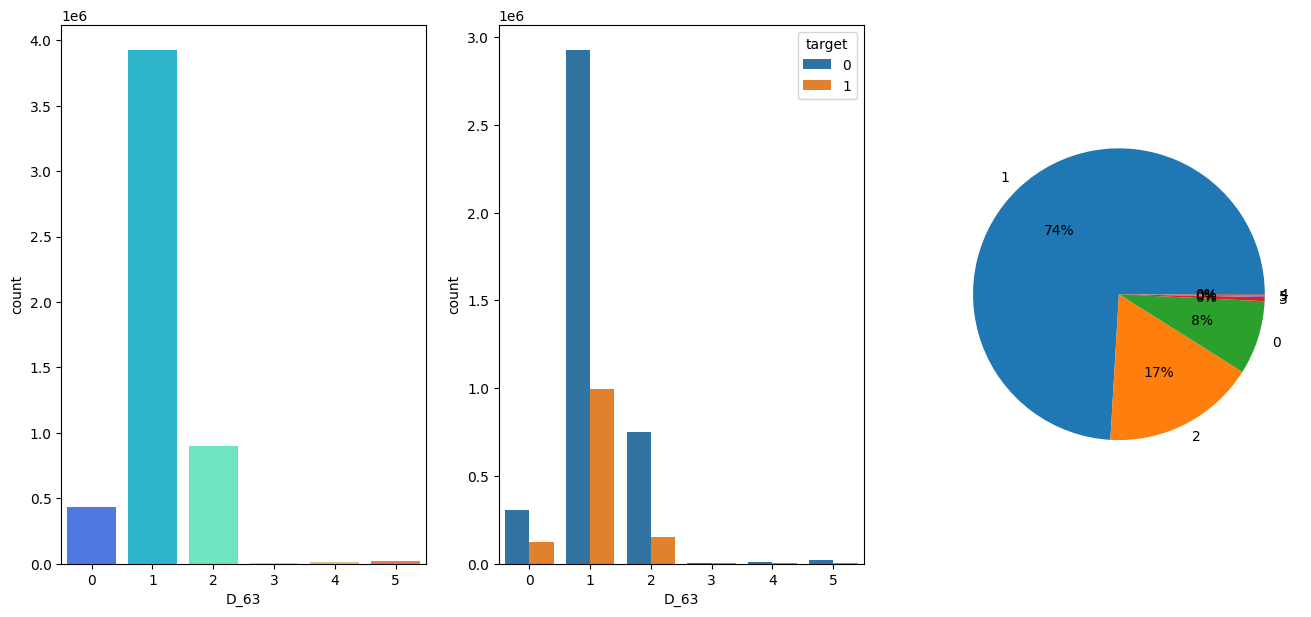

D_64
1    2907778
3    1516450
2     836368
0      34879
Name: D_64, dtype: int64


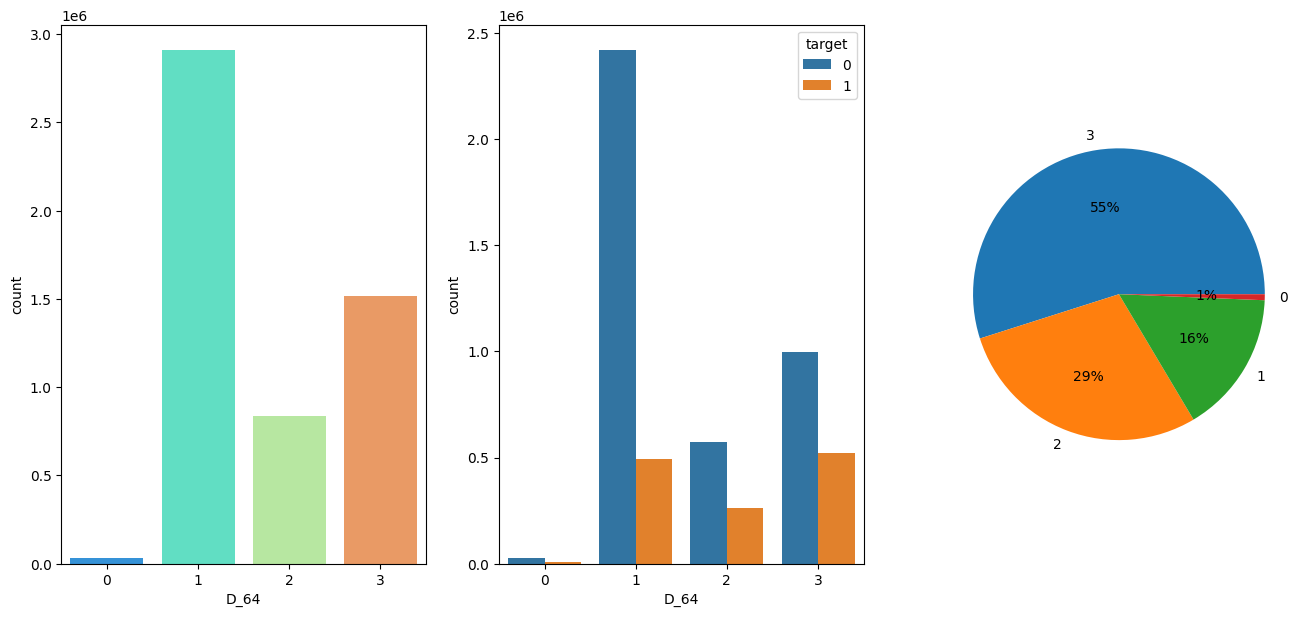

In [5]:
# Label Encode the Values

# for every feature, we store the object of LabelEncoder
la_dct = {}

# iterate over every categorical columns 
for i in df.select_dtypes(np.object_).columns:
    
    # store the name of the feature as the key 
    # the object of the Labelencoder for that calss as a value
    la_dct[i] = LabelEncoder().fit(df[i].values)
    
    # Transform the data to numerical
    df[i] = la_dct[i].transform(df[i].values) 


    print(i)
    print(df[i].value_counts())

    plt.figure(figsize= (16, 7))

    plt.subplot(1, 3, 1)
    sns.countplot(data= df, x = i, palette='rainbow')
    
    plt.subplot(1, 3, 2)
    sns.countplot(data= df, x = i, hue= 'target')

    plt.subplot(1, 3, 3)
    plt.pie(df[i].value_counts() , labels= df[i].unique().tolist(), autopct='%.0f%%')
    plt.show()

In [6]:
# change the data type for these categorical variables to integer
df['B_30'] = df.B_30.astype(np.int_)
df['B_38'] = df.B_38.astype(np.int_)
df['D_114'] = df.D_114.astype(np.int_)
df['D_117'] = df.D_117.astype(np.int_)
df['D_120'] = df.D_120.astype(np.int_)
df['D_126'] = df.D_126.astype(np.int_)
df['D_68'] = df.D_68.astype(np.int_)


df.loc[:, categorical_values].head()

B_30  B_38  D_114  D_117  D_120  D_126  D_63  D_64  D_68
0     0     3      0      2      0      1     1     3     5
1     1     4      0      5      0      1     1     3     4
2     0     2      0      2      0      1     2     2     6
3     1     3      1      4      0      1     1     3     4
4     0     1      1      2      0      1     1     1     5

In [33]:
# save our updated dataset 
df.to_csv('./data.csv', index= False)

In [20]:
# save our label encoder 

import pickle

# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(la_dct, f)
        
with open('label_encoder.pkl', 'rb') as f:
    la_dct = pickle.load(f)

In [2]:
# re-read the processed data

df = pd.read_csv('./data.csv')

categorical_values = ['B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68'] # this list is provided in problum distrivution 
num_features = [col for col in df.columns if col not in categorical_values ][:-1]

# data preview 
print(f'{df.shape[0]} rows \n{df.shape[1]} columns')
df.head()

2988004 rows 
159 columns


P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
1  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
2  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
3  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

        B_3      D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
1  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
2  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
3  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
4  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   

      D_140     D_141     D_143     D_144     D_145  target  
0  0.055567  0.238704  0.261570  0.050624  0.100623       1  
1  0.055567  0.238704  0.261570  0.050624  0.100623       1  
2  0.016687  0.140480  0.151917  0.053384  0.049740       0  
3  0.016687  0.140480  0.151917  0.053384  0.049740       0  
4  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

## Balence Target variable

<p>
Balancing the target variable for classification is important because class imbalance can lead to several problems when building a machine learning model:
</br>

<ol>
<li>Predictive bias: Models tend to favor the majority class and have poor performance on the minority class. This can lead to a biased model that is not able to accurately predict the minority class.</li>

<li>Model evaluation: The accuracy is not a good metric to evaluate the performance of a model when the data is imbalanced. Other metrics such as precision, recall, F1-score, AUC-ROC are more informative.</li>

<li>Overfitting: Models trained on imbalanced data can overfit to the majority class, resulting in poor performance on unseen data.</li>

<li>Data Loss: Models trained on imbalanced data can ignore the minority class, and this can lead to loss of important information.</li>
</ol>
Balancing the class distribution can mitigate these issues and improve the performance of the model. There are several techniques that can be used to balance the target variable, such as under-sampling the majority class, over-sampling the minority class, or a combination of both. Additionally, it's also possible to use different algorithms specifically designed to handle imbalanced data.
</p>


0    4013585
1    1281890
Name: target, dtype: int64


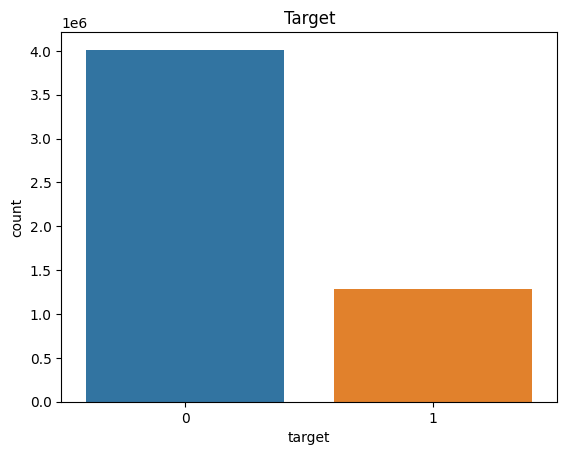

In [27]:
print(df.target.value_counts())
sns.countplot(data= df, x = 'target')
plt.title('Target')
plt.show()

In [28]:
# to balence this data we will use combination of randomly dropping recors from the target variable 0 to a certain number and then oversampling the class 1 to balance dataset 
df.drop(index= np.random.choice(a = df[df['target'] == 0 ].index.to_list(), 
                       size= int(df['target'].value_counts()[0] * 0.55), 
                       replace= False), 
        axis= 0, 
        inplace= True)

0    1806114
1    1281890
Name: target, dtype: int64


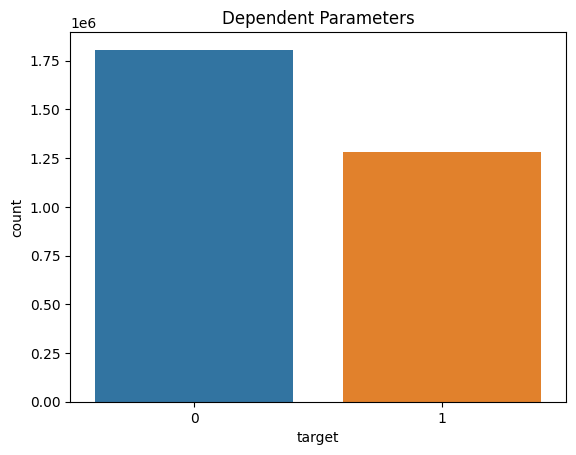

In [30]:
# output class after dropping the records 

print(df['target'].value_counts())
sns.countplot(data = df , x = 'target')
plt.title('Dependent Parameters')
plt.show()

<p>
<b> SMOTE </b> (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance in a dataset. It works by generating synthetic samples of the minority class, in order to balance the class distribution. SMOTE is typically applied when the minority class is significantly under-represented in the dataset compared to the majority class.
<br>
</br>
The best time to apply SMOTE would be when:
<ul>
<li>The dataset has a class imbalance issue, i.e., one class has significantly fewer observations than the other.</li>
<li>The model's performance is poor or is not generalizing well to the minority class.</li>
<li>The model's precision and recall are not balanced and is biased towards majority class</li>
</ul>
It's important to note that oversampling can cause overfitting, especially if the original dataset is small. Therefore it's best to apply SMOTE after spliting the data into training and test set, and only oversampling the training set.
It's also worth noting that oversampling is not always the best solution to handle class imbalance problem, it's important to try different methods and evaluate the performance of the model after applying them.
</p>

In [31]:
# we split the data between train and test 
test = pd.DataFrame(columns= df.columns)

target_0 = np.random.choice(a = df[df['target'] == 0 ].index.to_list(), size= 50000, replace= False).tolist()
test = pd.concat([test, df.loc[target_0 , df.columns ]], axis= 0)
df.drop(index= target_0, inplace= True, axis= 0)

target_1 = np.random.choice(a = df[df['target'] == 1 ].index.to_list(), size= 50000, replace= False).tolist()
test = pd.concat([test, df.loc[target_1 , df.columns ]], axis= 0)
df.drop(index= target_1, inplace= True, axis= 0)

# shuffel the data
test = test.sample(n = test.shape[0]) 

# save the data
test.to_csv('./test.csv', index= False)

test.head()

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
5486581  0.397275  0.237023  0.267619  0.285619  0.222425  0.325511  0.146003   
2588241  0.742078  0.125338  0.076465  0.732787  0.031173  0.186893  0.031424   
177316   0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
977201   0.397270  0.238116  0.267980  0.284693  0.221078  0.324578  0.147984   
45058    0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

              B_3      D_43      D_44  ...     D_131     D_133      R_28  \
5486581  0.307796  0.249739  0.298345  ...  0.222359  0.087190  0.007053   
2588241  0.074757  0.116590  0.058412  ...  0.064804  0.032750  0.005278   
177316   0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326   
977201   0.308120  0.249051  0.297671  ...  0.222626  0.087756  0.006914   
45058    0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326   

            D_139     D_140     D_141     D_143     D_144     D_145  target  
5486581  0.263589  0.056650  0.240493  0.263492  0.051199  0.100974       1  
2588241  0.151908  0.016964  0.140294  0.151769  0.053284  0.049348       0  
177316   0.152060  0.016687  0.140480  0.151917  0.053384  0.049740       0  
977201   0.262440  0.056328  0.239414  0.262347  0.050786  0.100322       1  
45058    0.152060  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

0    1756114
1    1231890
Name: target, dtype: int64


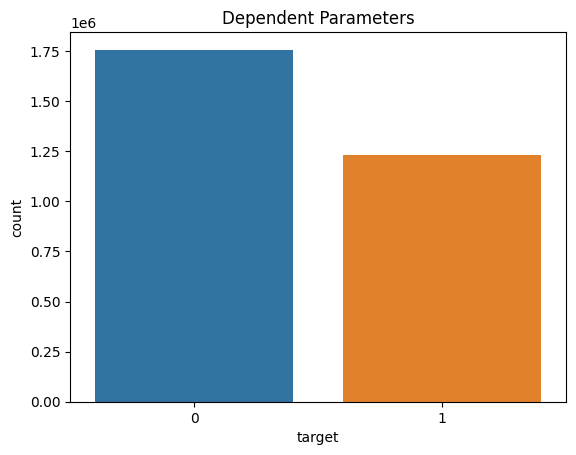

In [32]:
# output class after dropping the records 

print(df['target'].value_counts())
sns.countplot(data = df , x = 'target')
plt.title('Dependent Parameters')
plt.show()

In [6]:
# SMOTETomek to generate synthetic data 

SMOTE_OBJECT = SMOTETomek(sampling_strategy= 'minority', n_jobs= -1)

X, y = SMOTE_OBJECT.fit_resample(df.iloc[:, :-1].values, df.iloc[:, -1].values)
    

In [7]:
# convert our array 
new_data = pd.DataFrame(X, columns= df.columns[:-1] )
new_data['target'] = y

# change the 
new_data['B_30'] = new_data.B_30.astype(np.int_)
new_data['B_38'] = new_data.B_38.astype(np.int_)
new_data['D_114'] = new_data.D_114.astype(np.int_)
new_data['D_117'] = new_data.D_117.astype(np.int_)
new_data['D_120'] = new_data.D_120.astype(np.int_)
new_data['D_126'] = new_data.D_126.astype(np.int_)
new_data['D_68'] = new_data.D_68.astype(np.int_)
new_data['D_63'] = new_data.D_63.astype(np.int_)
new_data['D_64'] = new_data.D_64.astype(np.int_)

# save data 
new_data.to_csv('train.csv', index= False)

# preview data
new_data.head()

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
1  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
2  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
3  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

        B_3      D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
1  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
2  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
3  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
4  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   

      D_140     D_141     D_143     D_144     D_145  target  
0  0.055567  0.238704  0.261570  0.050624  0.100623       1  
1  0.055567  0.238704  0.261570  0.050624  0.100623       1  
2  0.016687  0.140480  0.151917  0.053384  0.049740       0  
3  0.016687  0.140480  0.151917  0.053384  0.049740       0  
4  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

1    1756114
0    1756114
Name: target, dtype: int64


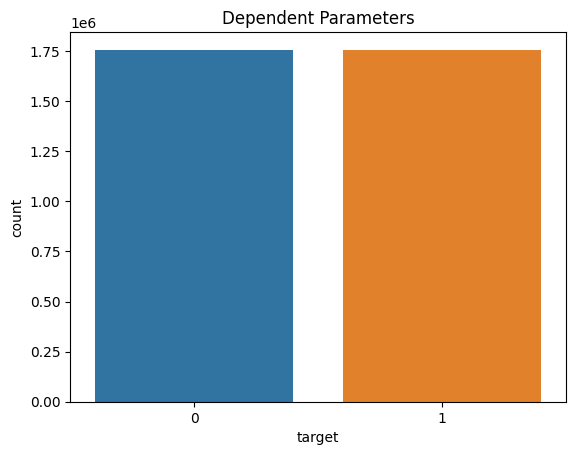

In [8]:
# output class after dropping the records 

print(new_data['target'].value_counts())
sns.countplot(data = new_data , x = 'target')
plt.title('Dependent Parameters')
plt.show()

## EDA

<p> 
Analyzing the distribution of categorical values is the process of determining the frequency or proportion of each category within the data. This can provide important information about the characteristics of the data, such as the proportion of observations in each category, the balance of classes, and the presence of outliers.
</br>
For example, if the data is a survey data, analyzing the distribution of categorical values can show the percentage of people who answered yes or no to a question, or the percentage of people who fall into different age ranges.
</br>
Analyzing the distribution of categorical values can be done through various techniques like frequency tables, bar charts, pie charts and etc. These techniques can help to identify patterns and relationships within the data, and can also be useful for data cleaning and data visualization. Additionally, understanding the distribution of categorical variables is crucial when building machine learning models, as it can help to identify potential issues with class imbalance or to select an appropriate evaluation metric.
</p>
</br>
<p>
Analyzing the distribution of continuous variables is important for several reasons:
<ol>
<li>Data Exploration: Understanding the distribution of variables can give insight into the underlying structure of the data, and help identify patterns, outliers, and anomalies.</li>

<li>Data Cleaning: By analyzing the distribution of the variables, one can identify and handle missing or invalid data, such as extreme values or outliers.</li>

<li>Model Selection: The distribution of the variables can influence the choice of model and the assumptions that need to be made. For example, if the variable is not normally distributed, a non-parametric model may be more appropriate.</li>

<li>Model Evaluation: Understanding the distribution of the variables can also help evaluate the performance of the model, as some models may be more sensitive to certain types of distributions.</li>

<li>Data Transformations: Depending on the distribution of the variables, data transformations such as normalization, scaling, or logarithmic transformation may be needed to meet the assumptions of certain models or to improve the interpretability of the results.</li>

<li>Communicating Results: Knowing the distribution of a variable helps to understand how to best present the data, such as choosing the right type of graph or summarizing statistics.</li>
</ol>
</p>

In [44]:
# re-load the processed data

df = pd.read_csv('./train.csv')

categorical_values = ['B_30', 'B_38', 'D_114', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68'] # this list is provided in problum distrivution 
num_features = [col for col in df.columns if col not in categorical_values ][:-1]

# data preview 
print(f'{df.shape[0]} rows \n{df.shape[1]} columns')
df.head()

3512228 rows 
159 columns


P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
1  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
2  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
3  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

        B_3      D_43      D_44  ...     D_131     D_133      R_28     D_139  \
0  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
1  0.308318  0.251702  0.299237  ...  0.224156  0.088281  0.007048  0.261712   
2  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
3  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   
4  0.074354  0.116648  0.058584  ...  0.064767  0.032789  0.005326  0.152060   

      D_140     D_141     D_143     D_144     D_145  target  
0  0.055567  0.238704  0.261570  0.050624  0.100623       1  
1  0.055567  0.238704  0.261570  0.050624  0.100623       1  
2  0.016687  0.140480  0.151917  0.053384  0.049740       0  
3  0.016687  0.140480  0.151917  0.053384  0.049740       0  
4  0.016687  0.140480  0.151917  0.053384  0.049740       0  

[5 rows x 159 columns]

In [4]:
# for the interactive data analysis of categorical values 
dtale.show(df.loc[:, categorical_values]).open_browser()

B_30
0    2692278
1     770680
2      49270
Name: B_30, dtype: int64


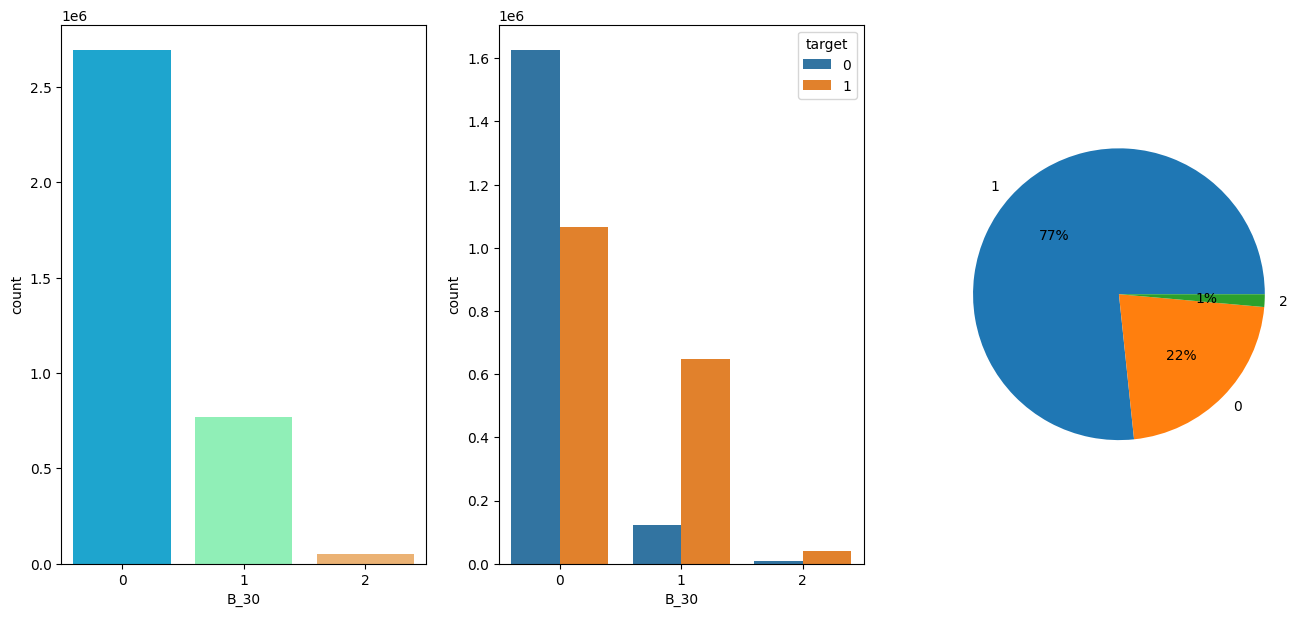

B_38
2    945318
3    924399
1    530658
5    418619
4    302480
7    228845
6    161909
Name: B_38, dtype: int64


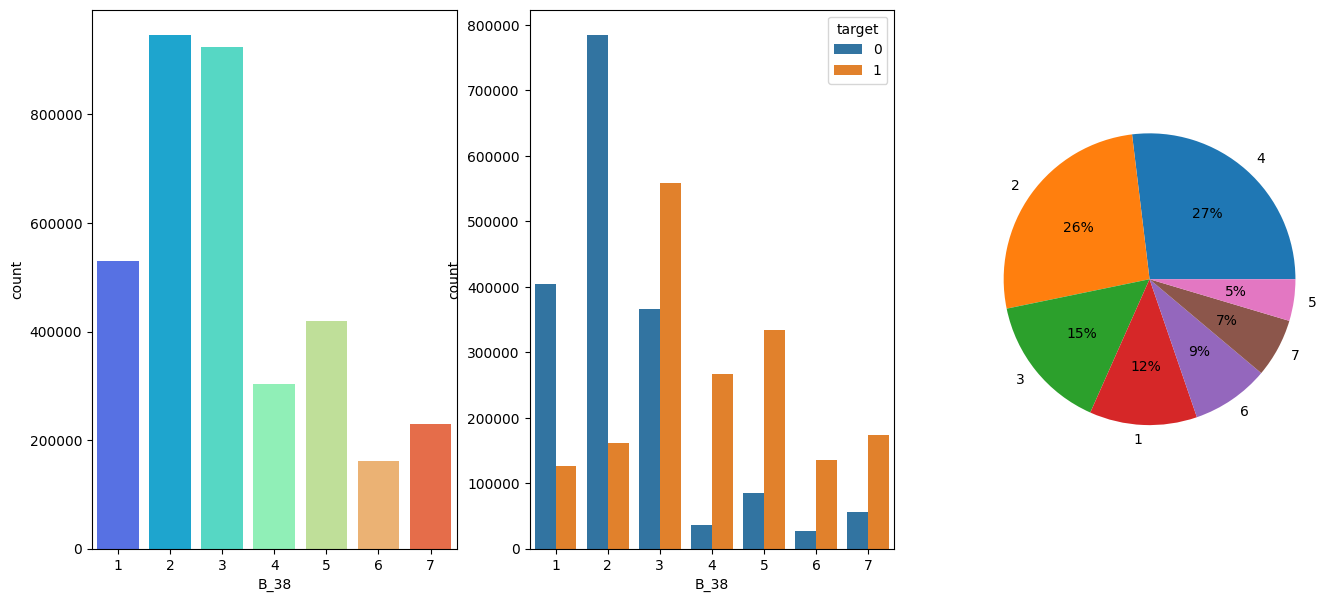

D_114
1    1989067
0    1523161
Name: D_114, dtype: int64


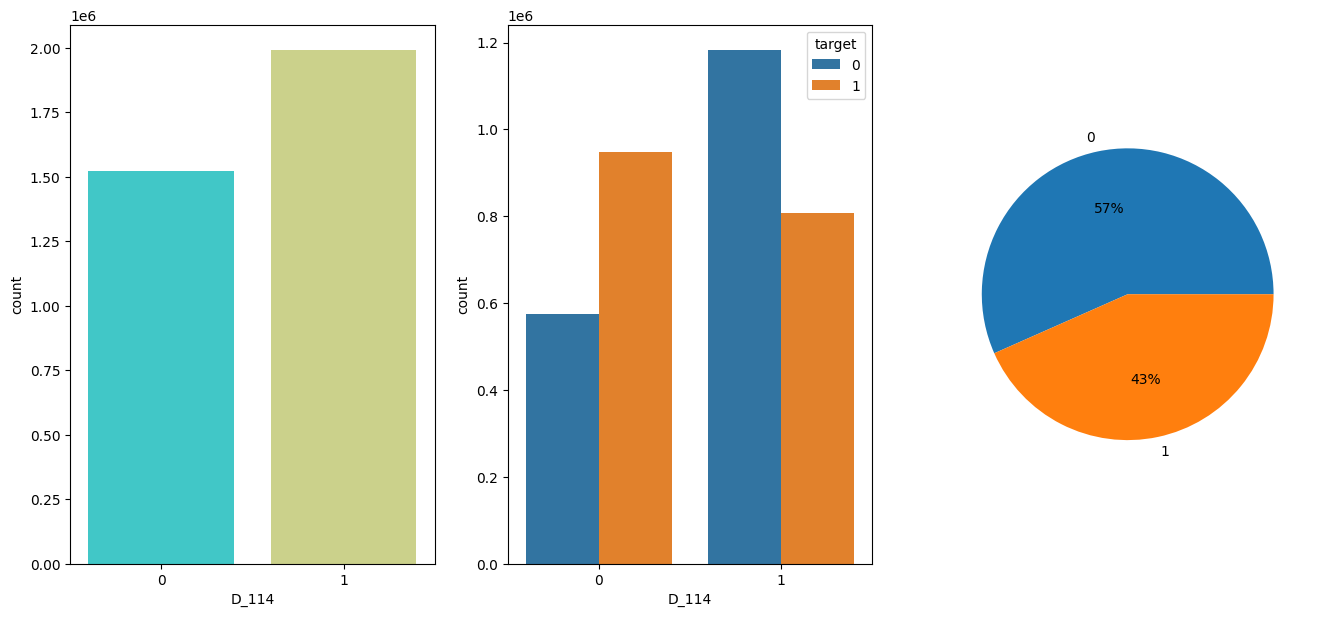

D_117
-1    979415
 3    798282
 4    678351
 2    500701
 5    257972
 6    193351
 1    104156
Name: D_117, dtype: int64


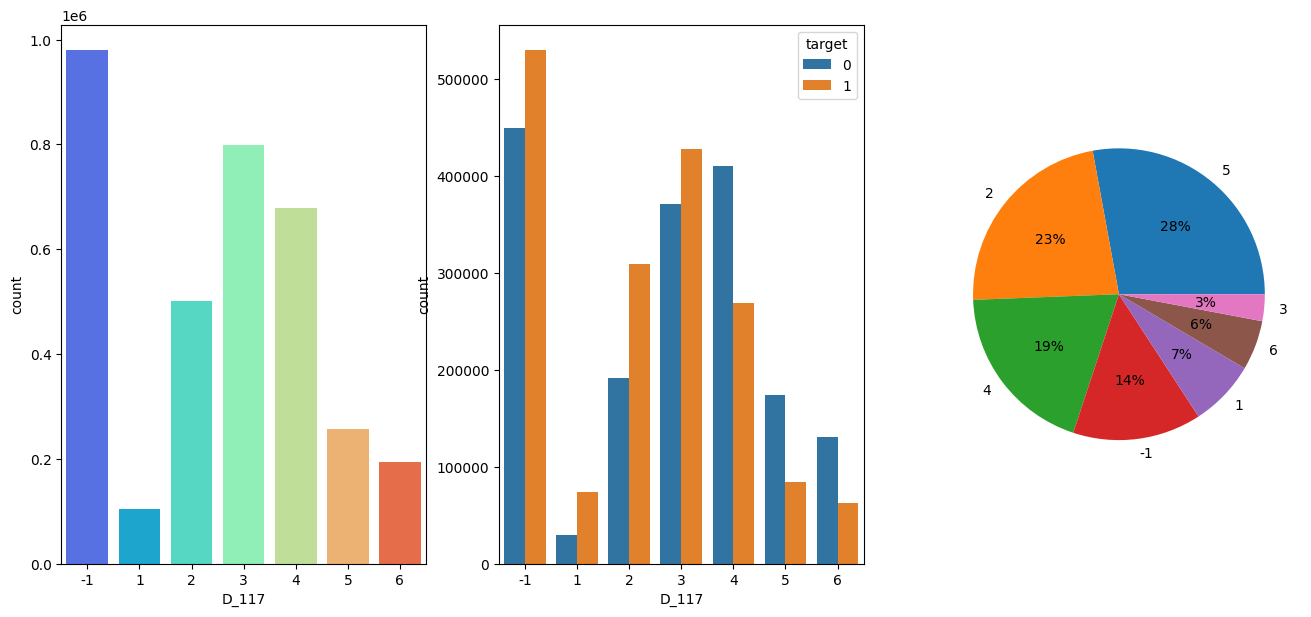

D_120
0    2972474
1     539754
Name: D_120, dtype: int64


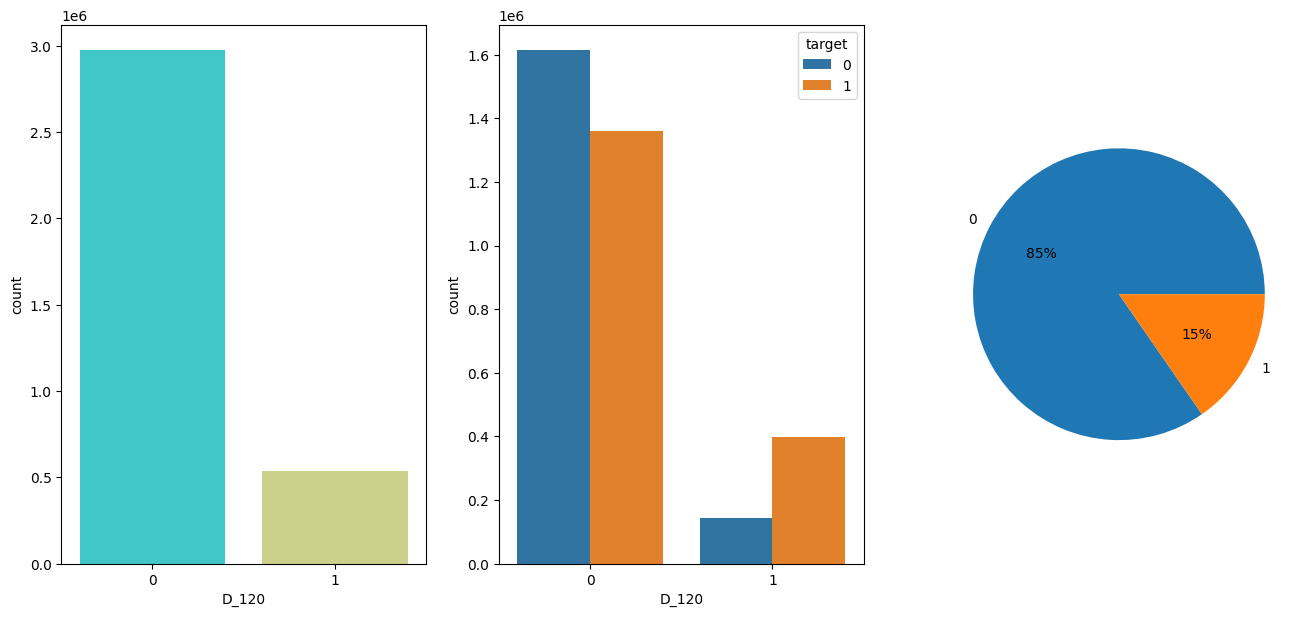

D_126
 1    2767001
 0     582967
-1     162260
Name: D_126, dtype: int64


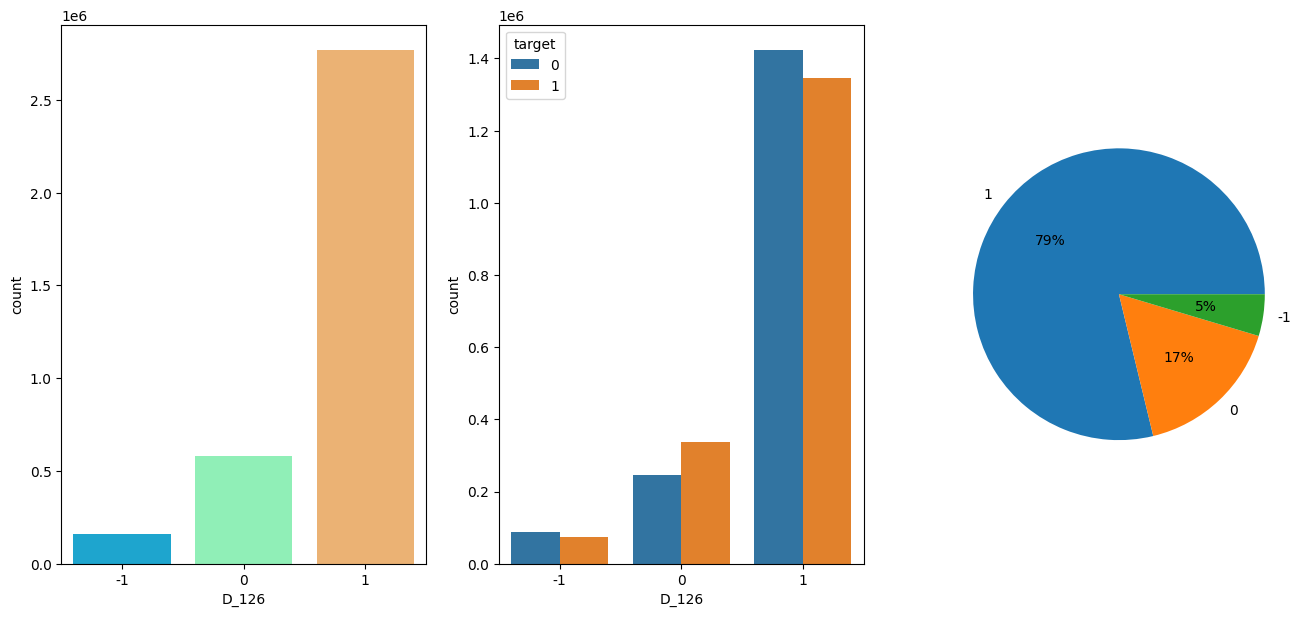

D_63
1    2647613
2     532654
0     306099
5      14902
4       6207
3       4753
Name: D_63, dtype: int64


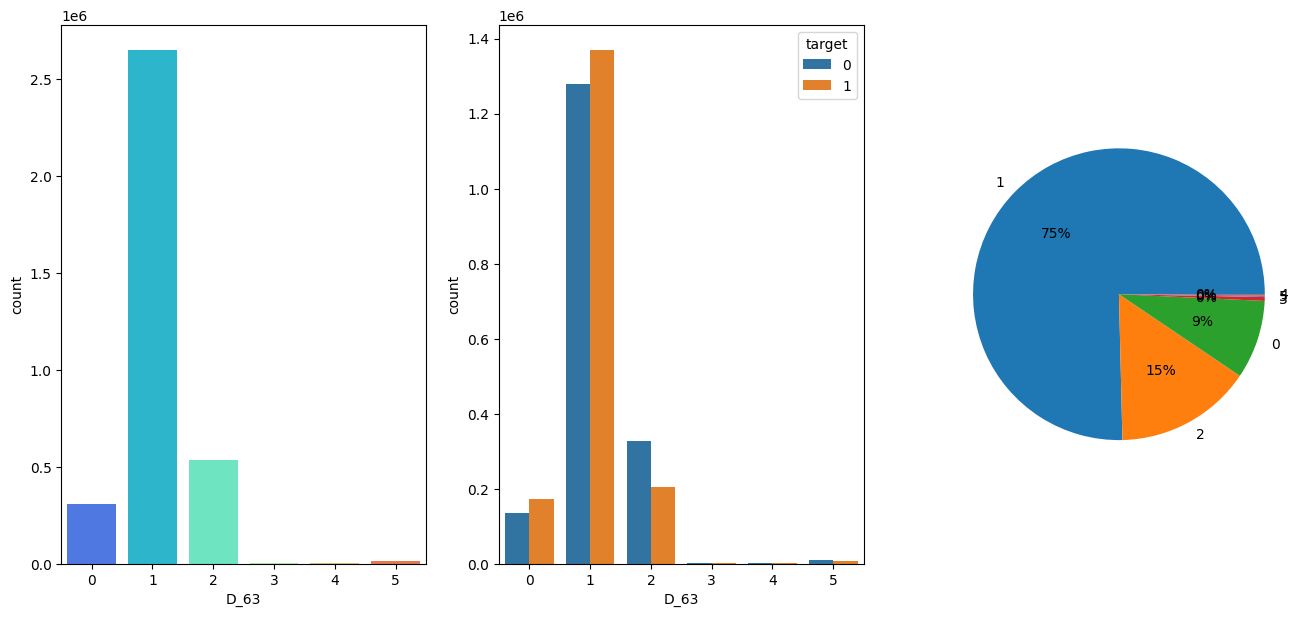

D_64
1    1730766
3    1147304
2     611679
0      22479
Name: D_64, dtype: int64


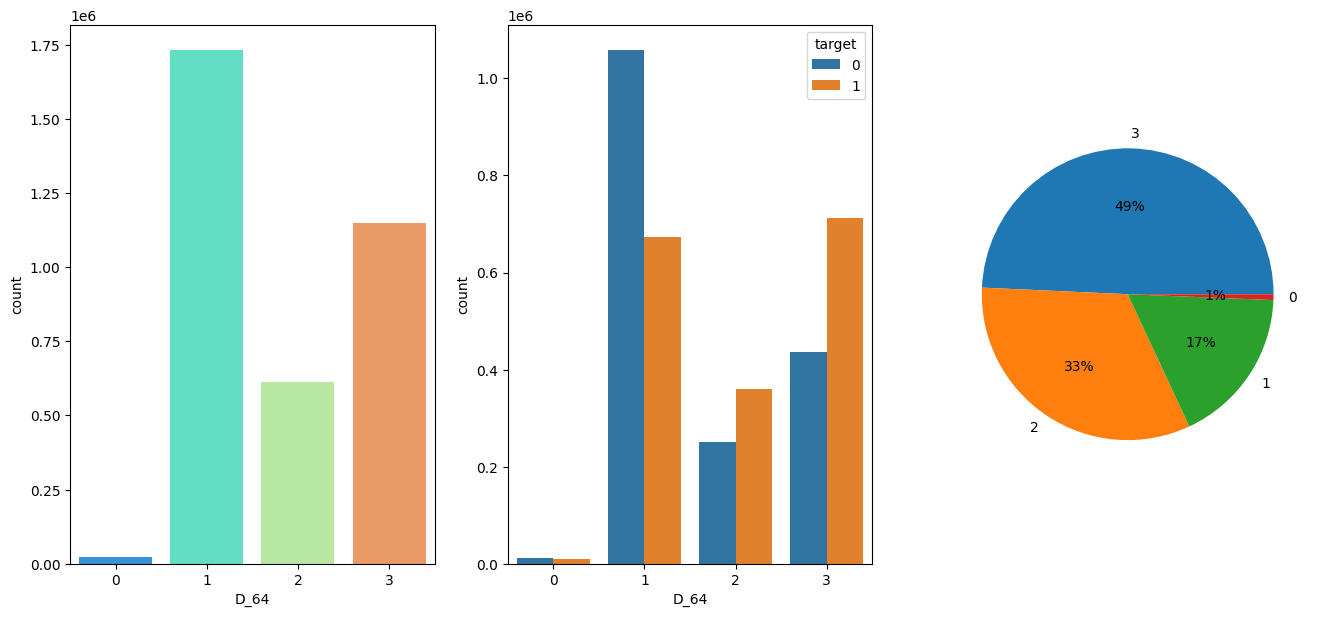

D_68
6    1665551
5     816874
3     377321
4     360269
2     175492
1     107308
0       9413
Name: D_68, dtype: int64


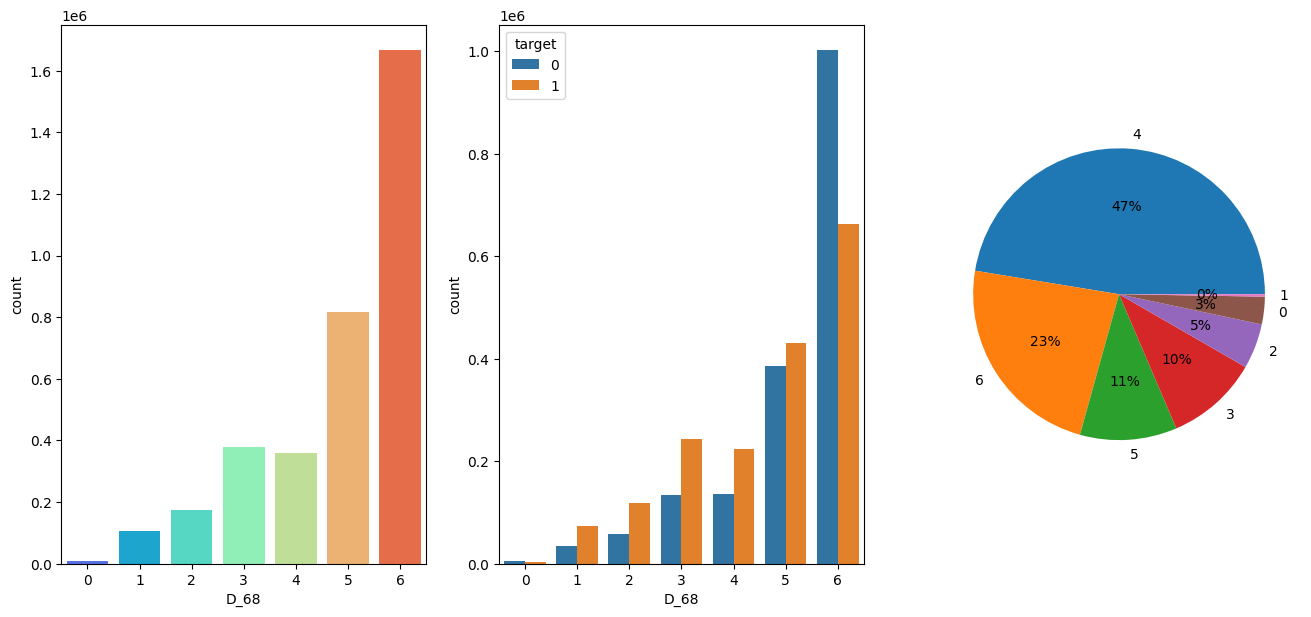

In [5]:
for col in categorical_values : 

    print(col)
    print(df[col].value_counts())

    plt.figure(figsize= (16, 7))

    plt.subplot(1, 3, 1)
    sns.countplot(data= df, x = col, palette='rainbow')
    
    plt.subplot(1, 3, 2)
    sns.countplot(data= df, x = col, hue= 'target')

    plt.subplot(1, 3, 3)
    plt.pie(df[col].value_counts() , labels= df[col].unique().tolist(), autopct='%.0f%%')
    plt.show()

P_2


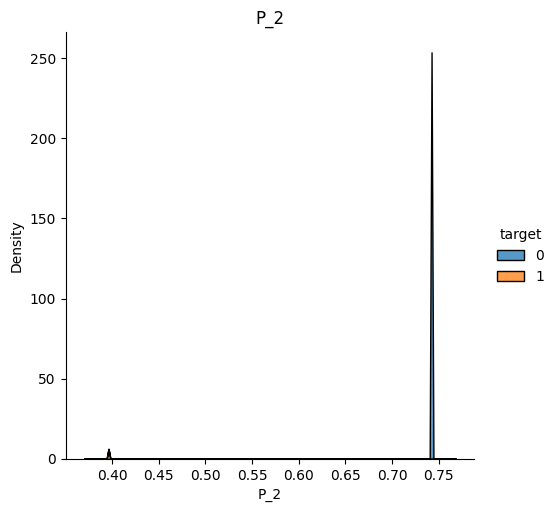

D_39


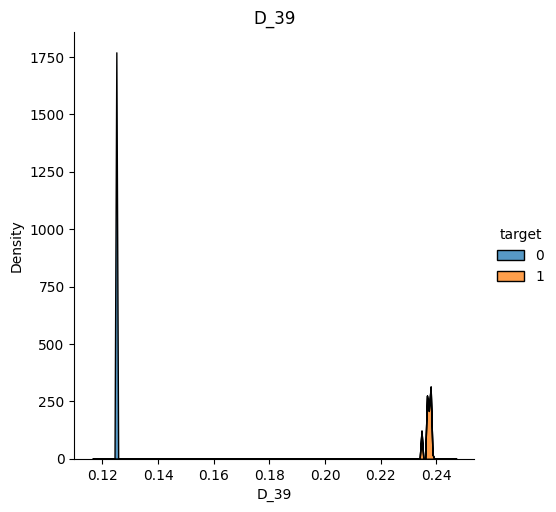

B_1


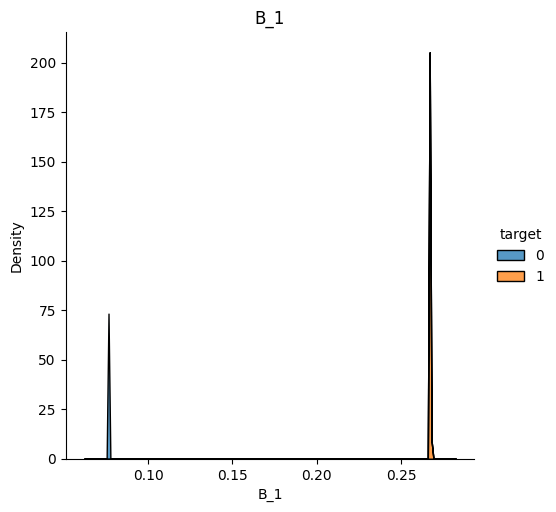

B_2


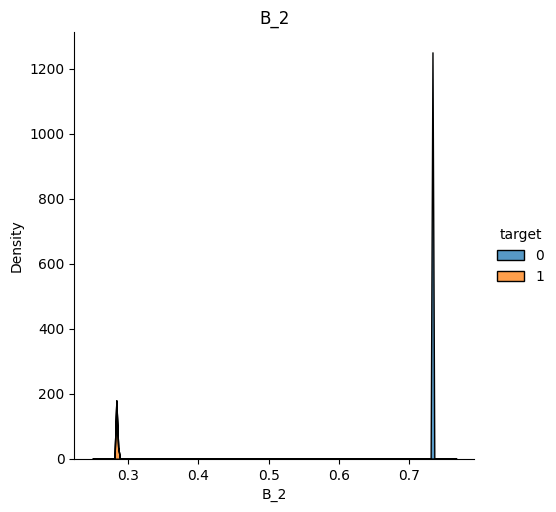

R_1


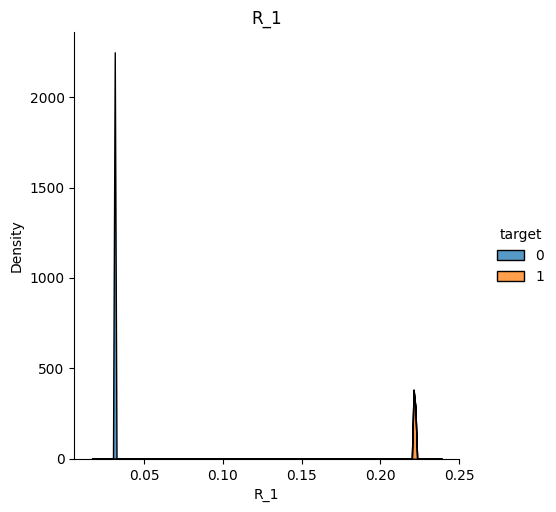

S_3


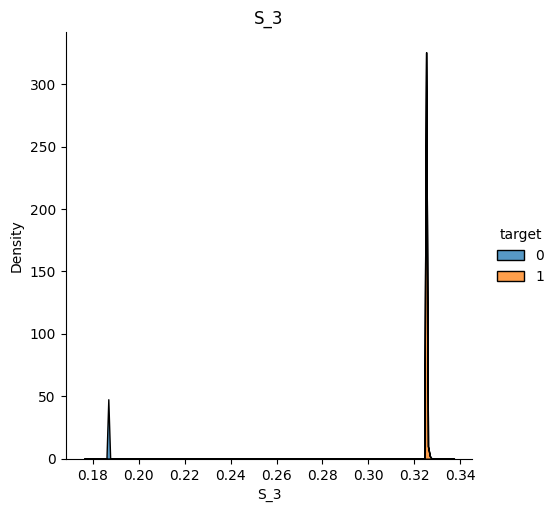

D_41


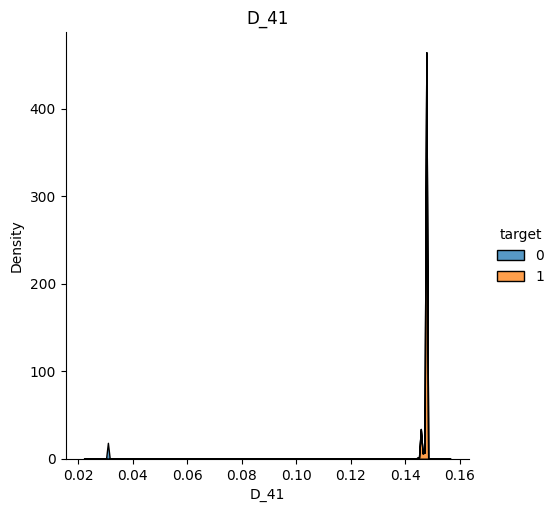

B_3


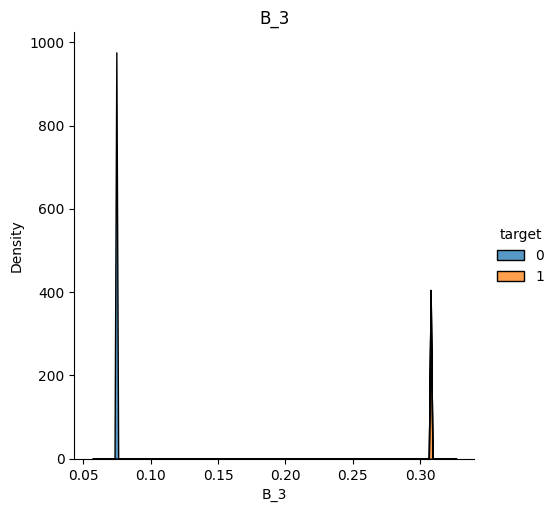

D_43


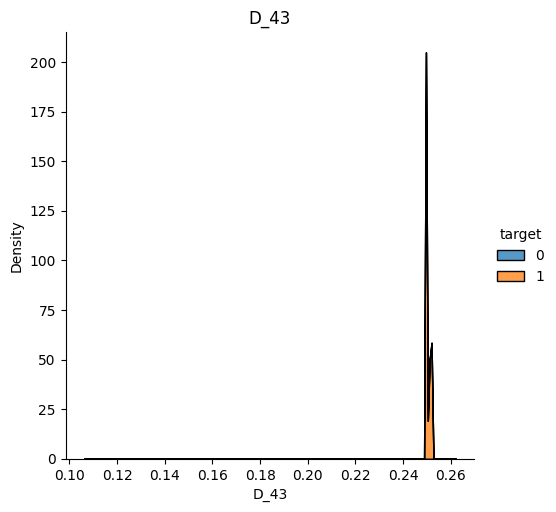

D_44


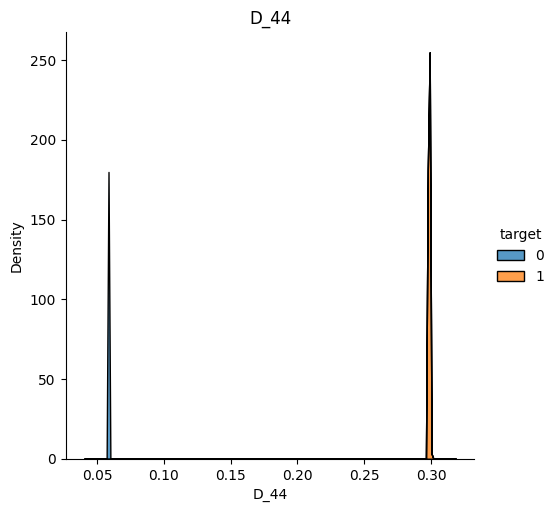

B_4


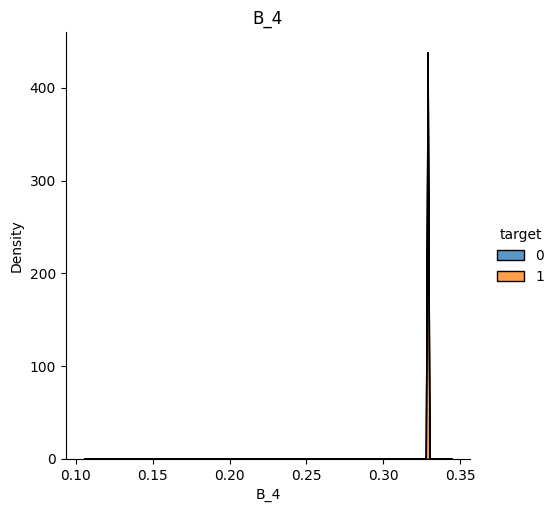

D_45


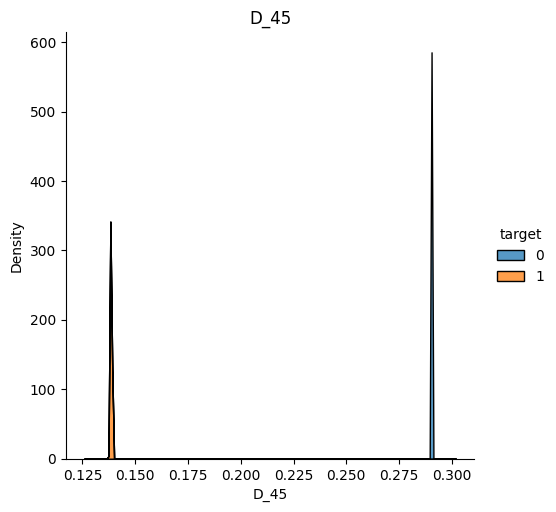

B_5


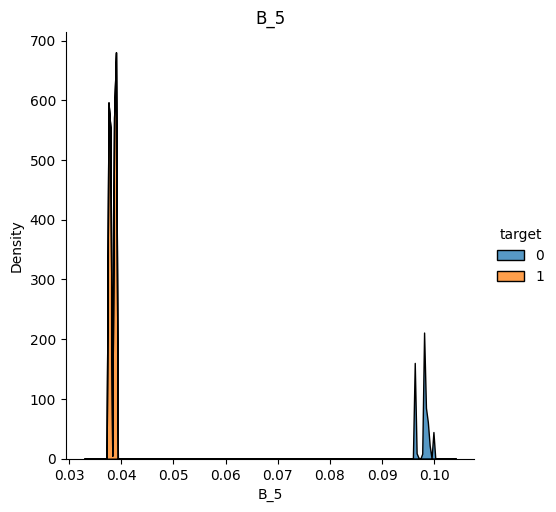

R_2


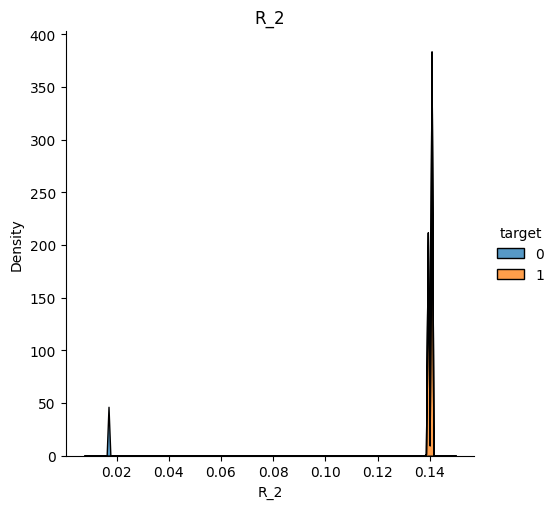

D_46


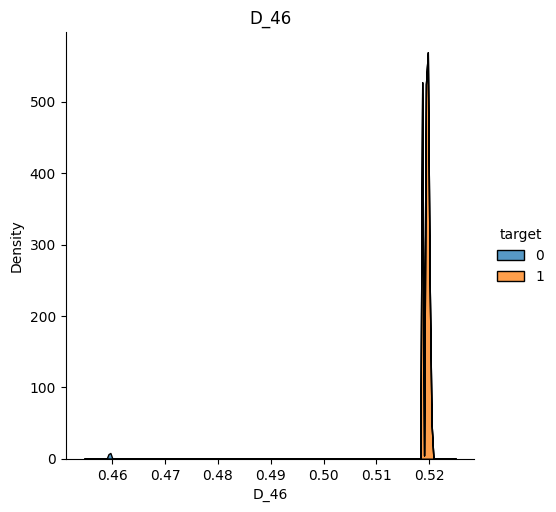

D_47


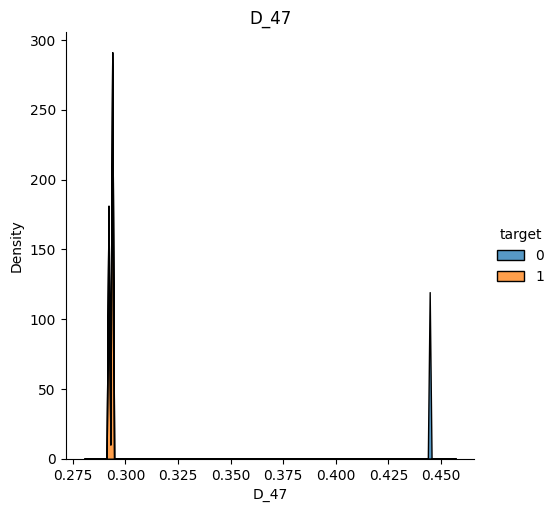

D_48


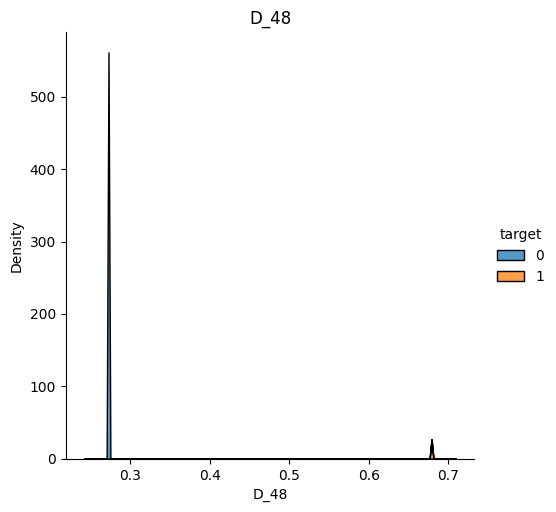

B_6


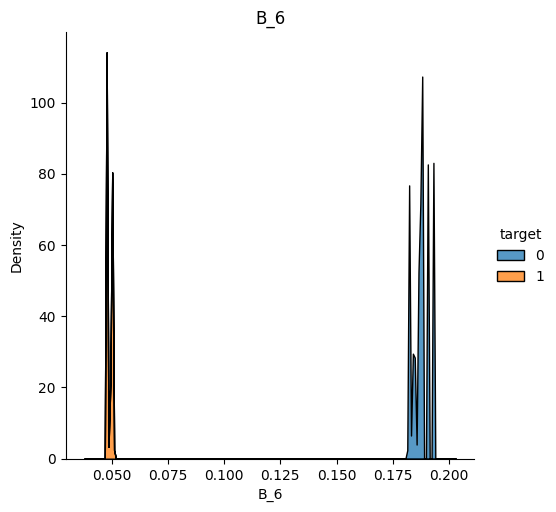

B_7


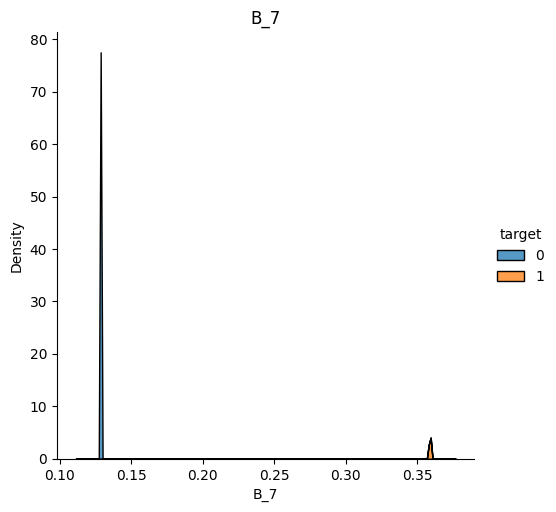

B_8


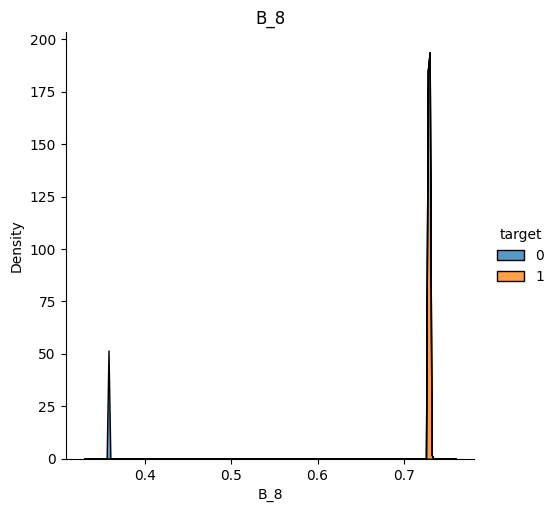

D_51


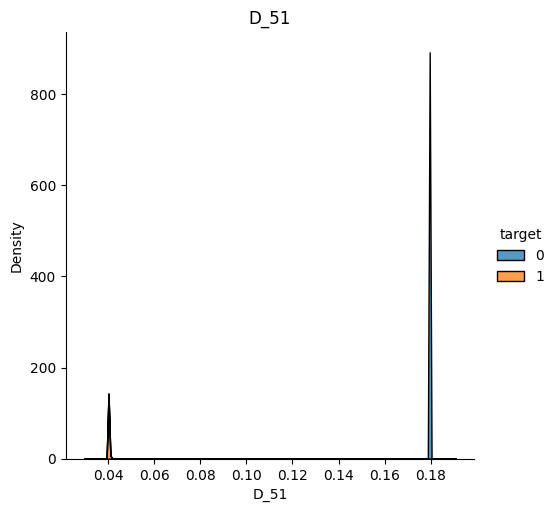

B_9


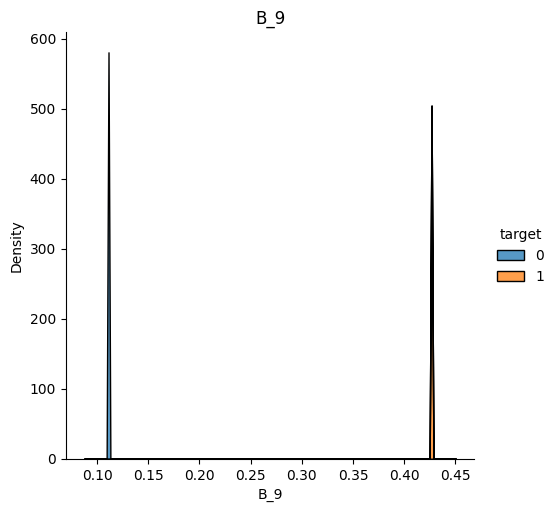

R_3


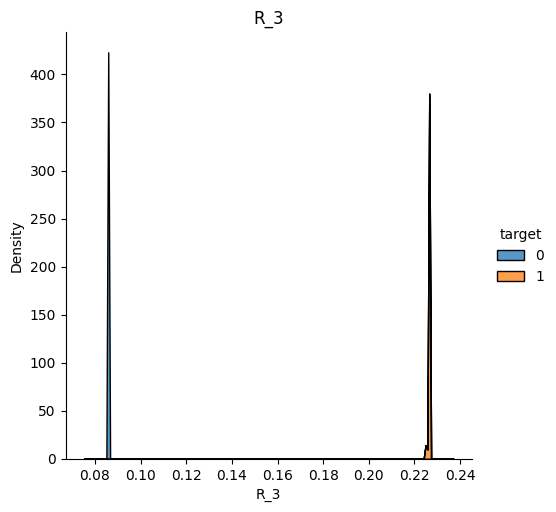

D_52


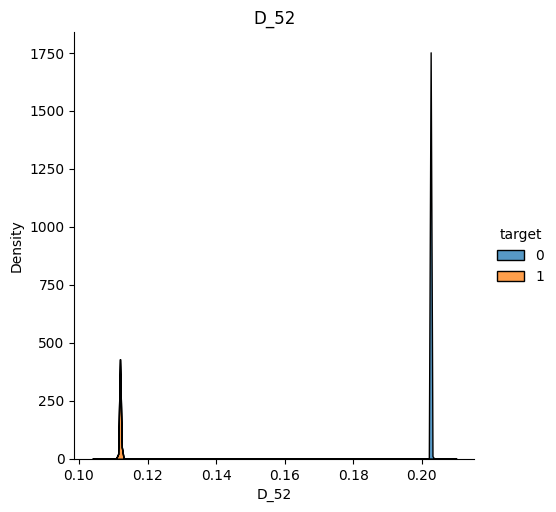

P_3


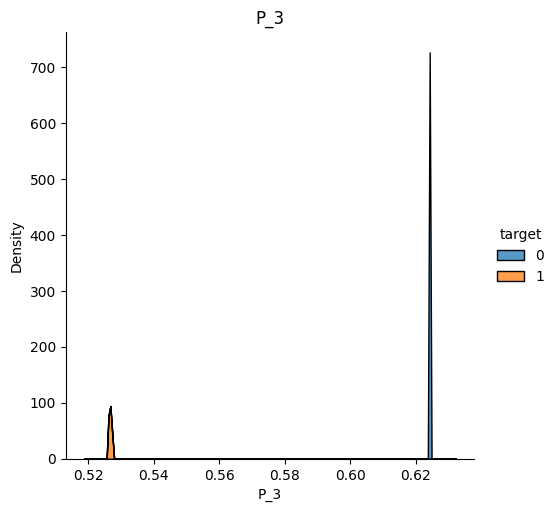

B_10


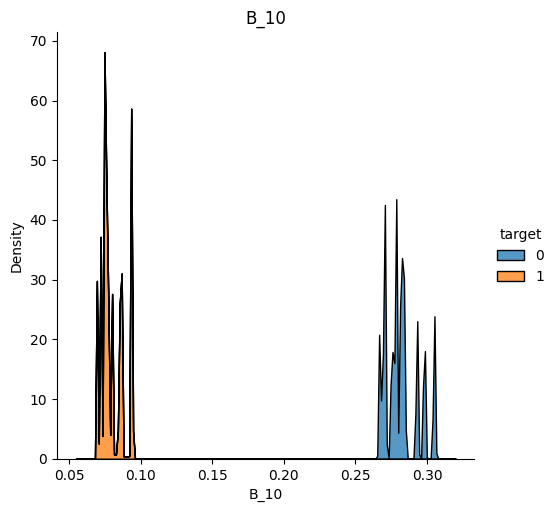

S_5


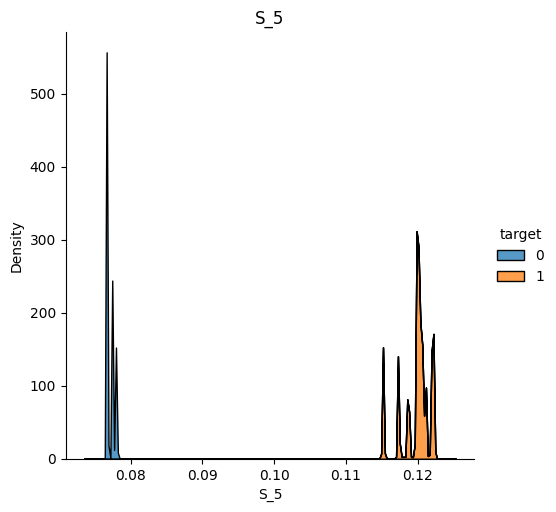

B_11


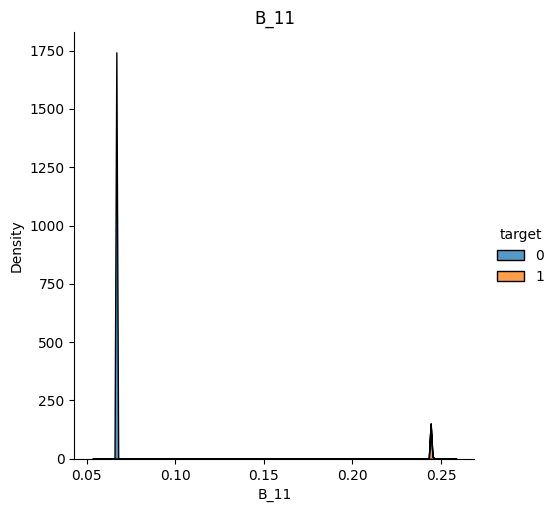

S_6


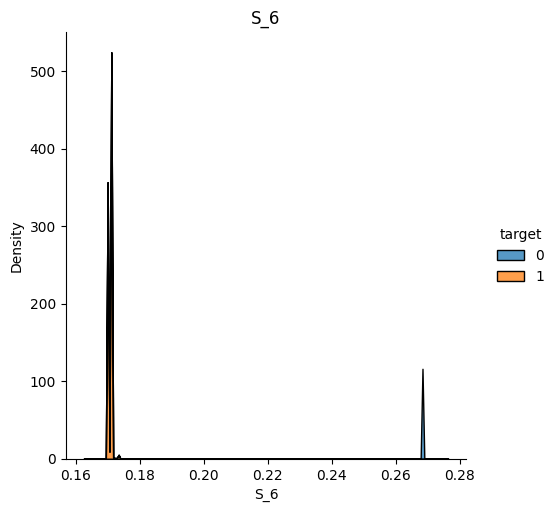

D_54


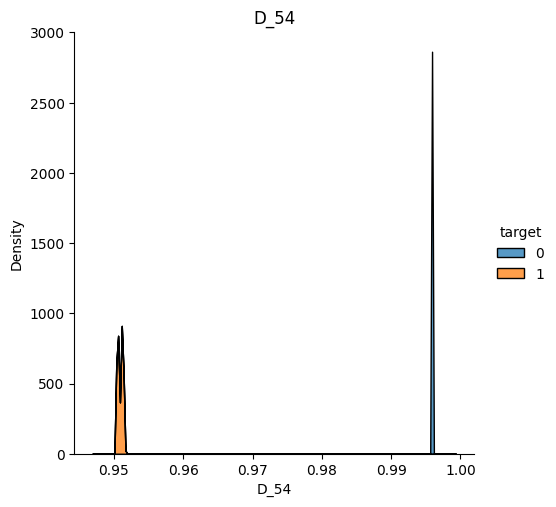

R_4


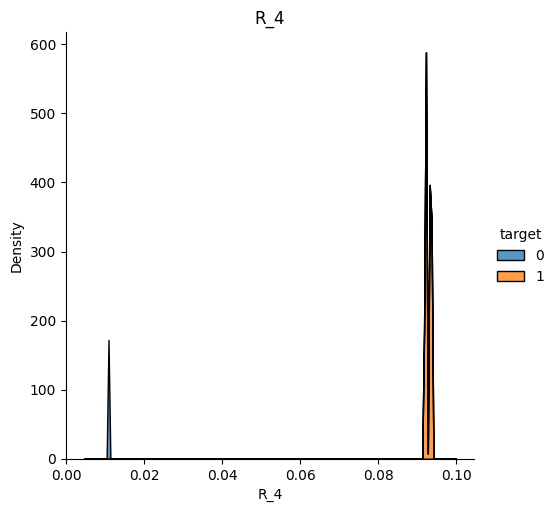

S_7


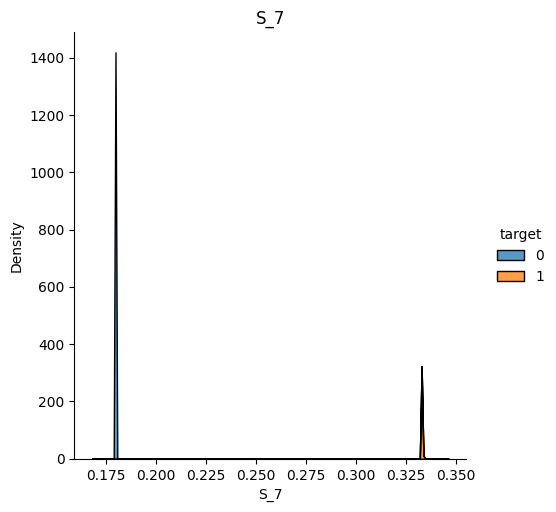

B_12


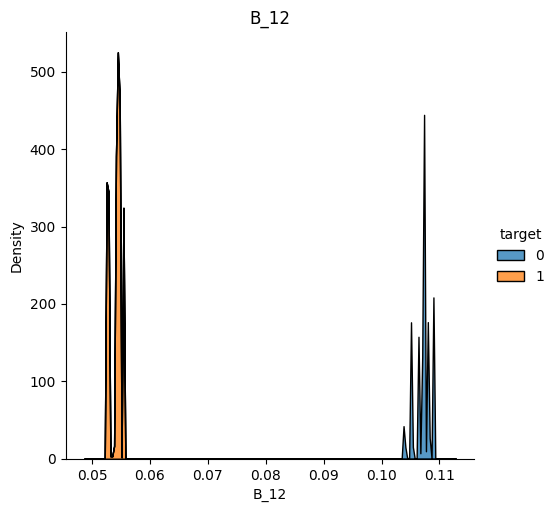

S_8


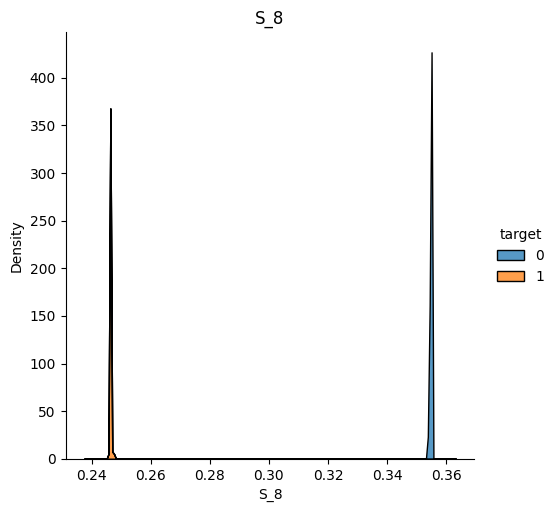

D_55


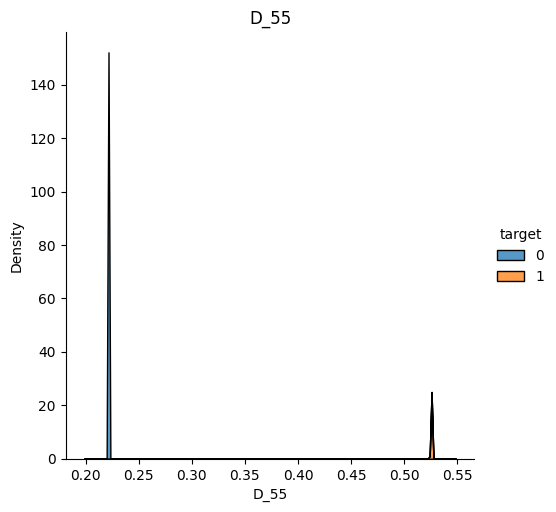

B_13


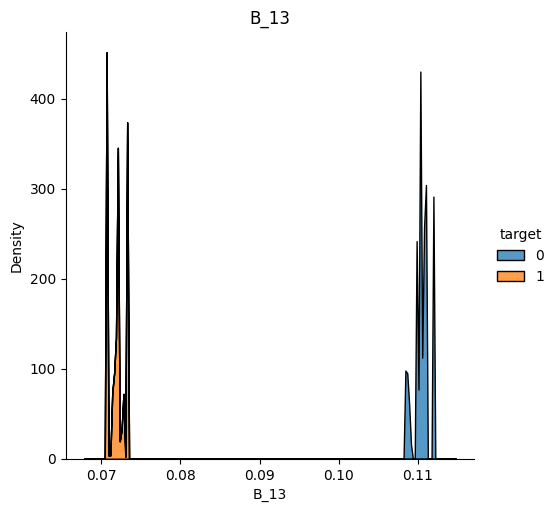

R_5


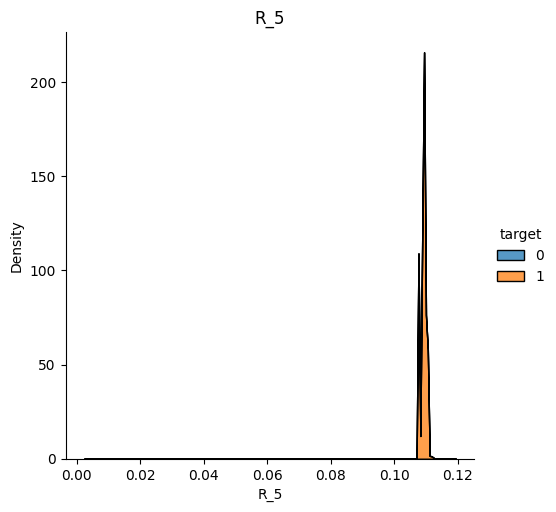

D_58


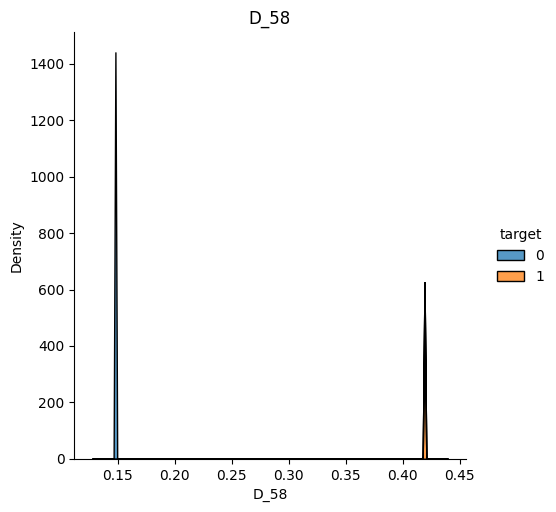

B_14


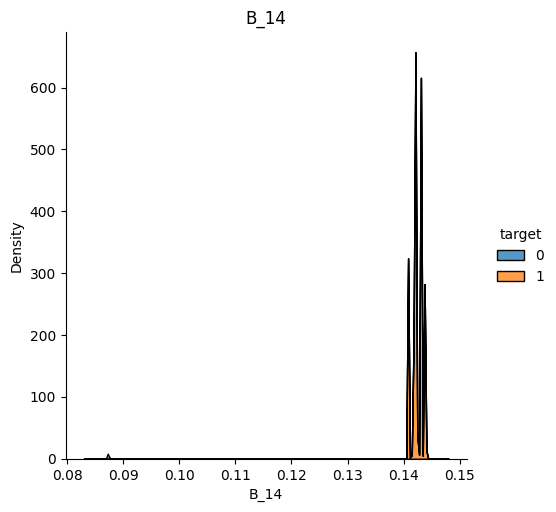

D_59


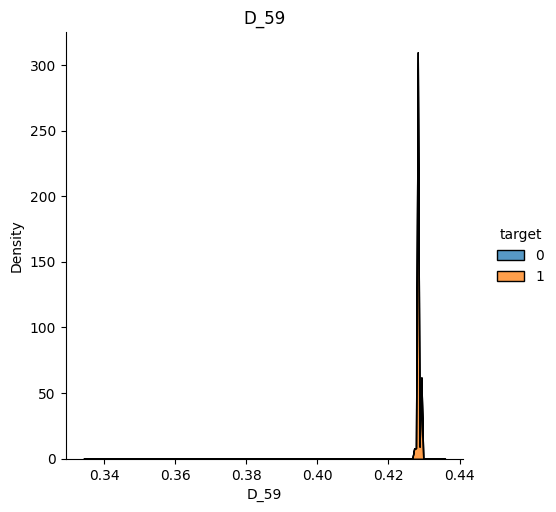

D_60


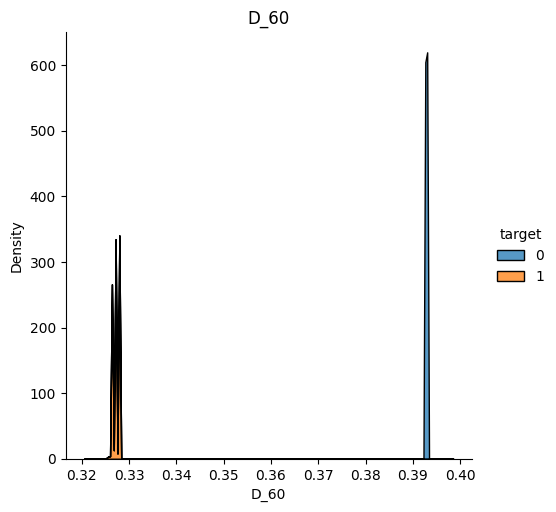

D_61


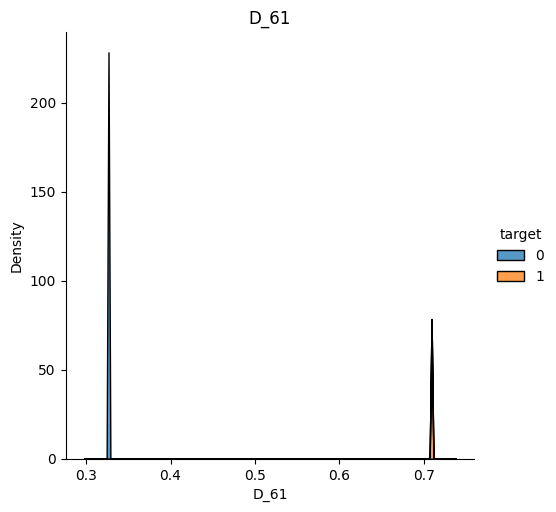

B_15


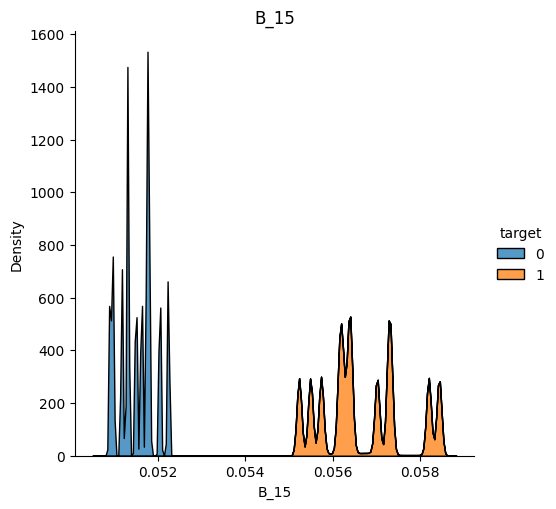

S_11


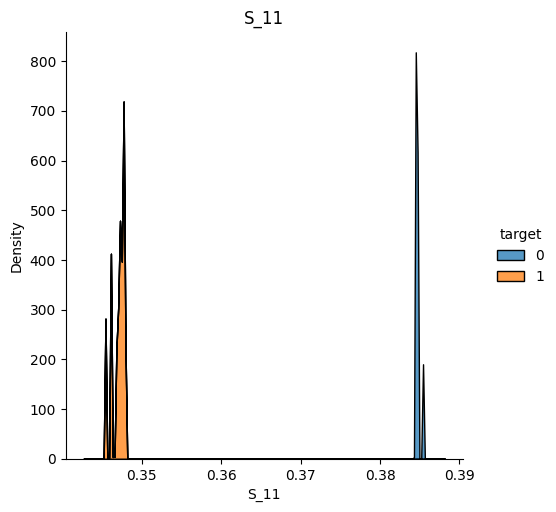

D_62


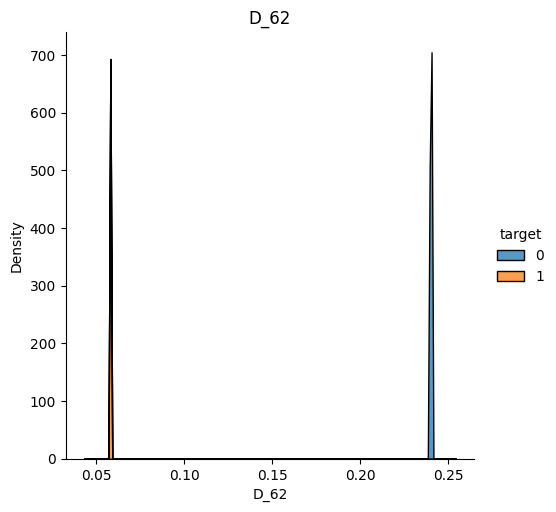

D_65


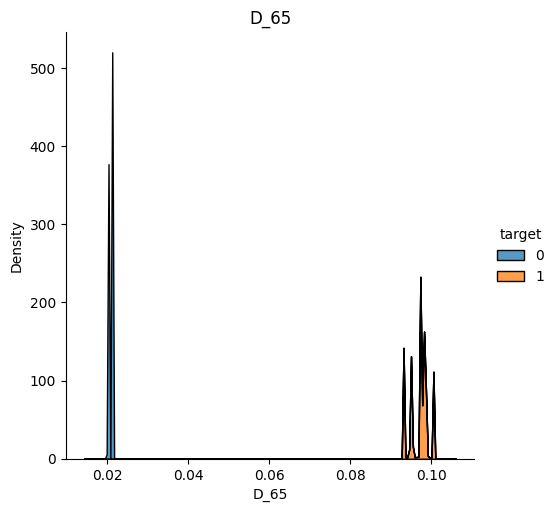

B_16


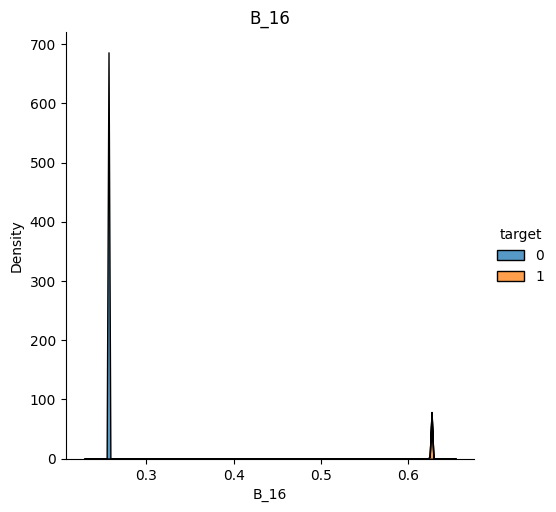

B_18


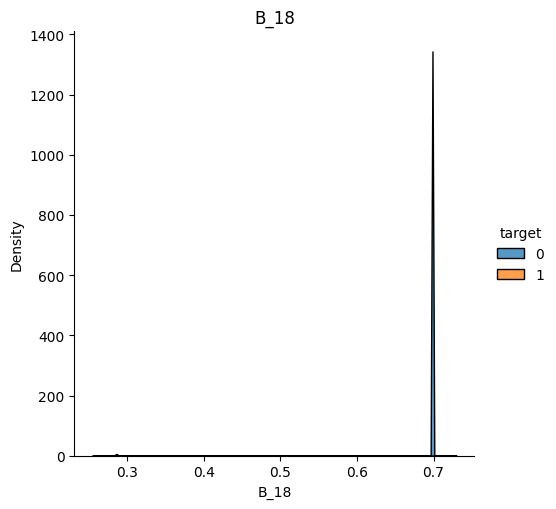

B_19


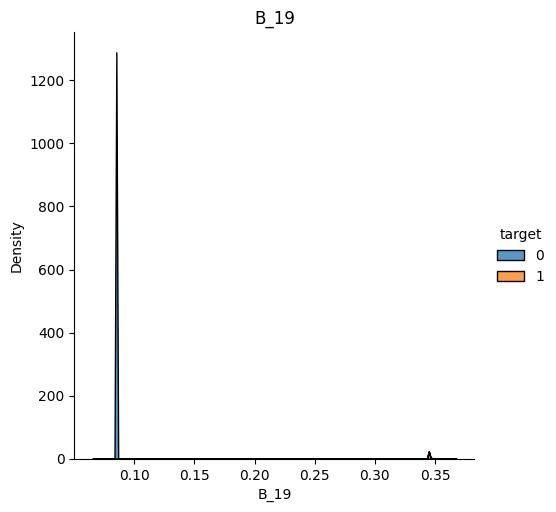

B_20


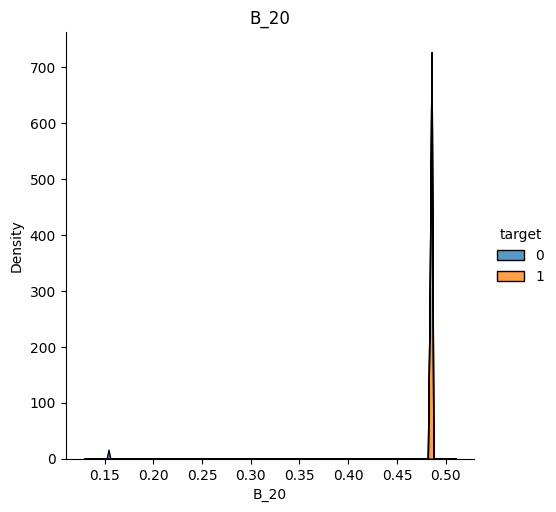

S_12


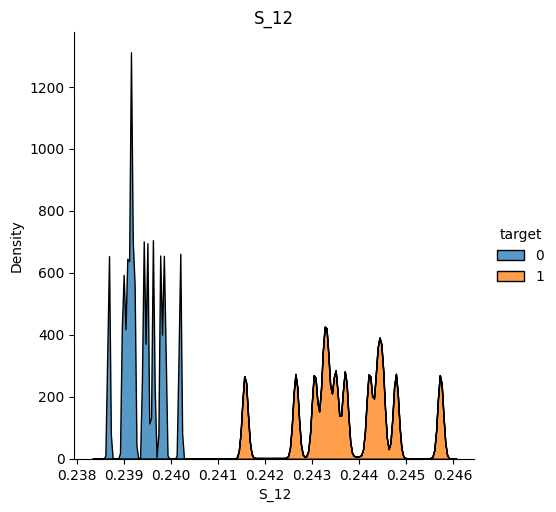

R_6


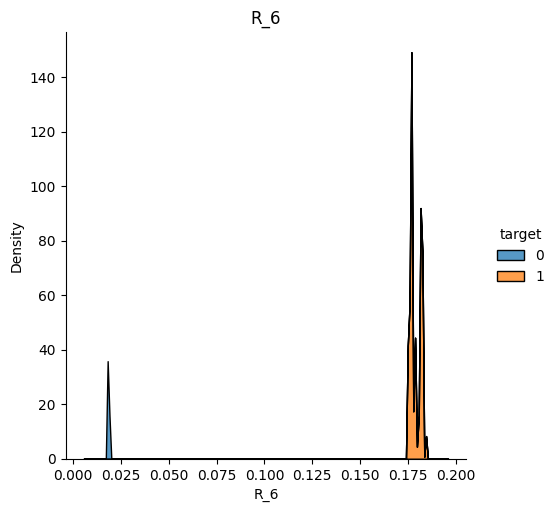

S_13


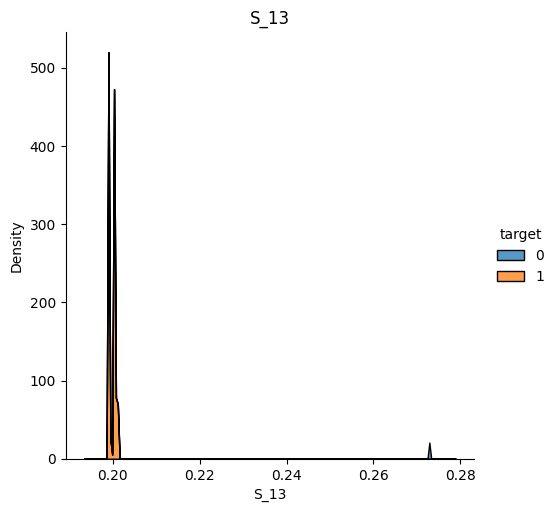

B_21


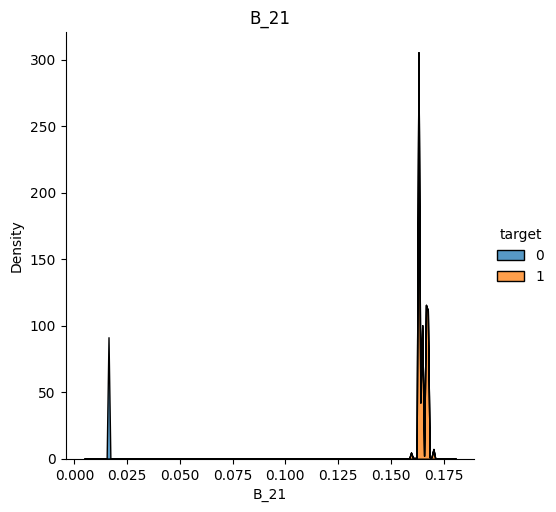

D_69


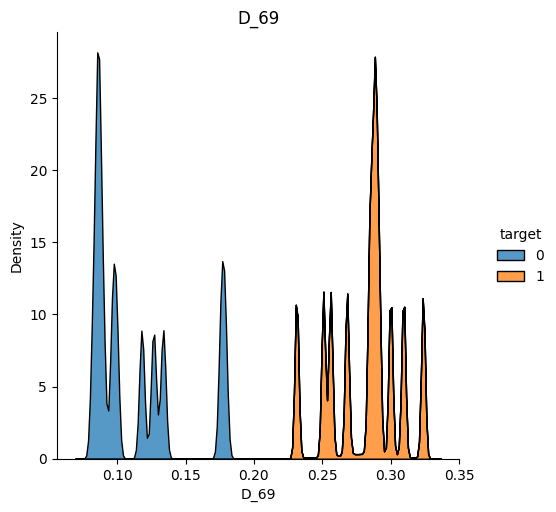

B_22


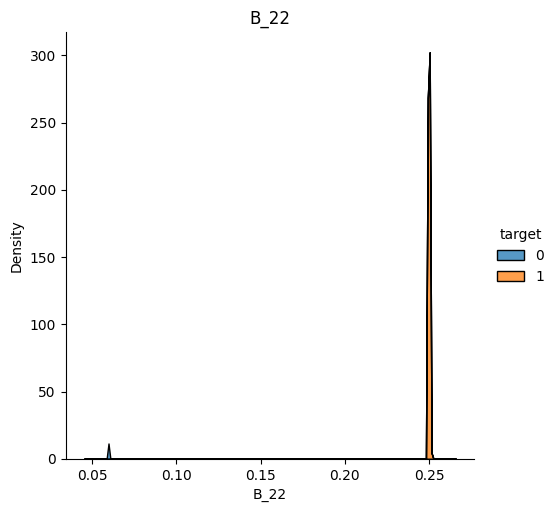

D_70


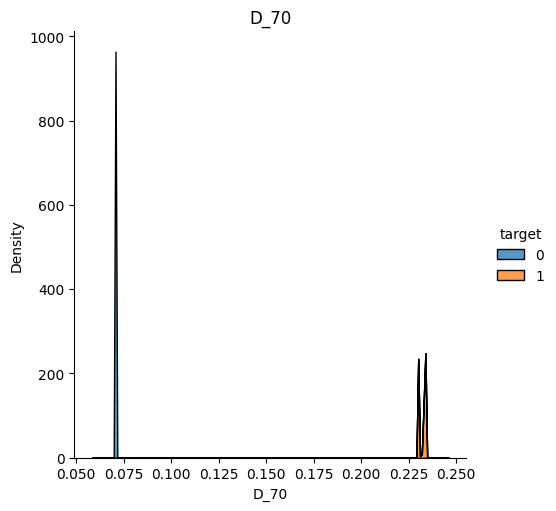

D_71


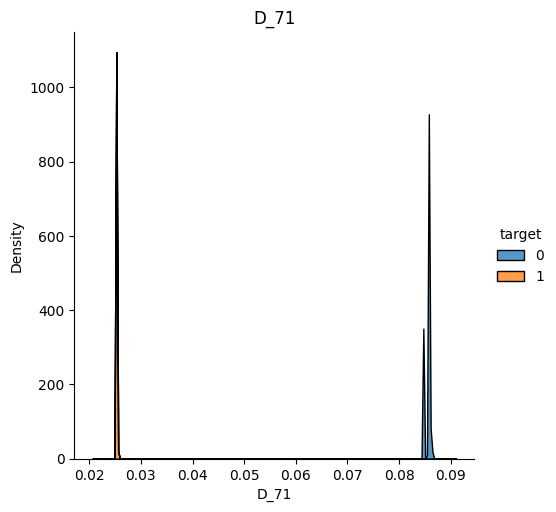

D_72


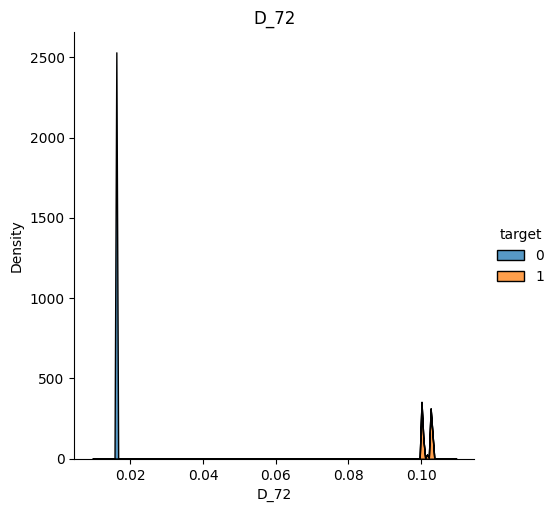

S_15


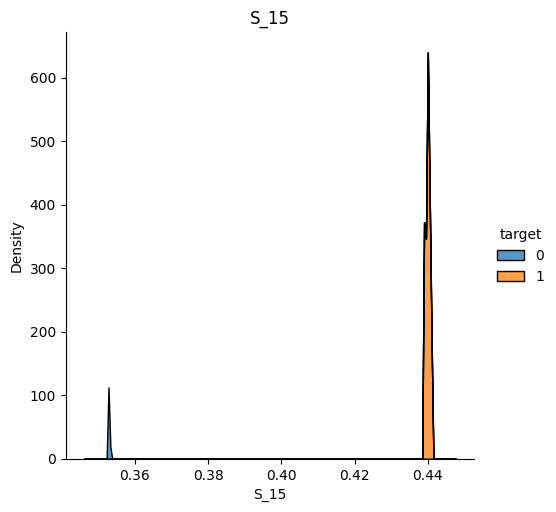

B_23


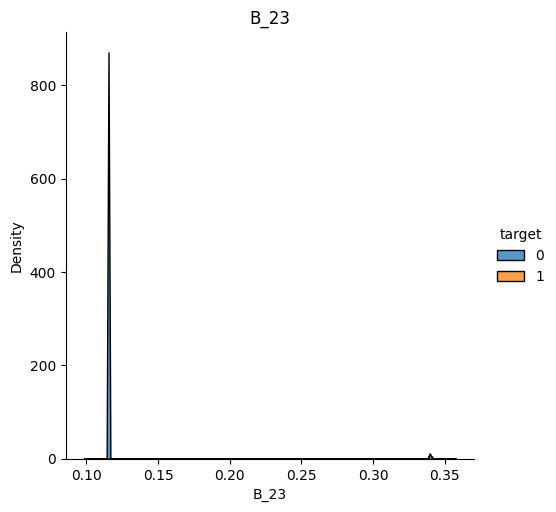

P_4


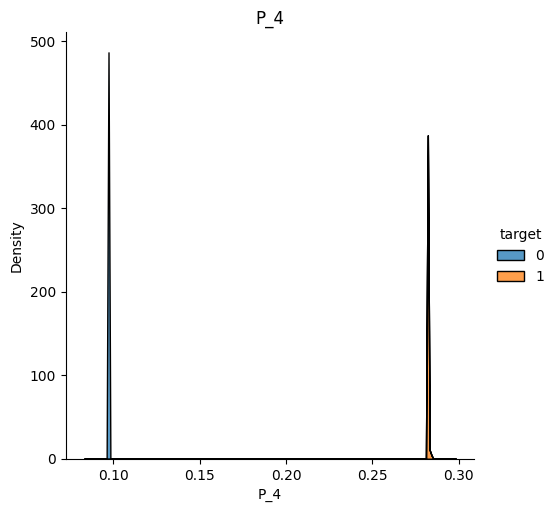

D_74


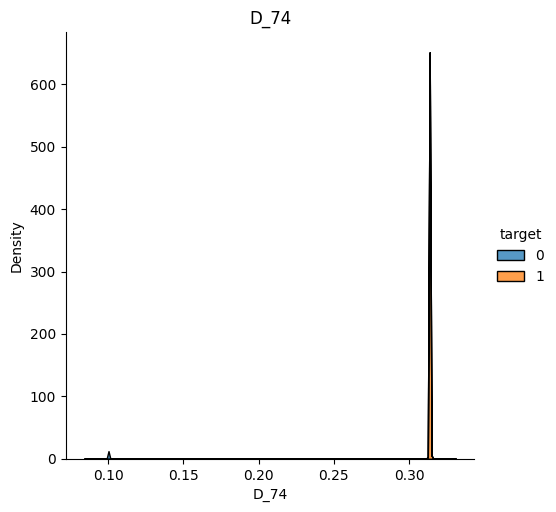

D_75


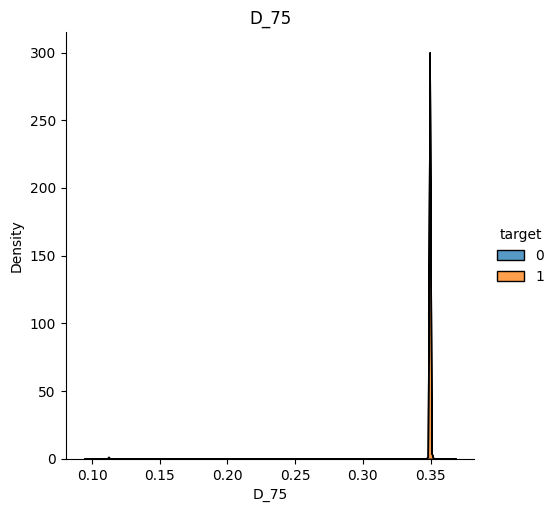

B_24


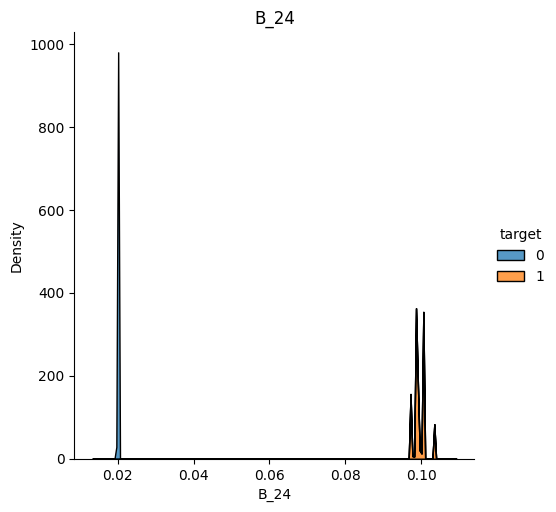

R_7


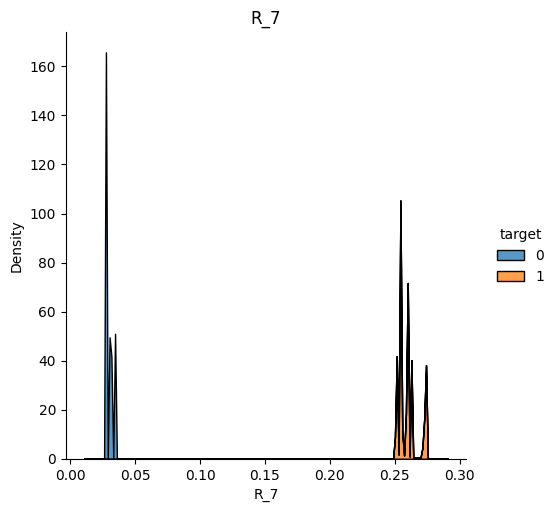

D_77


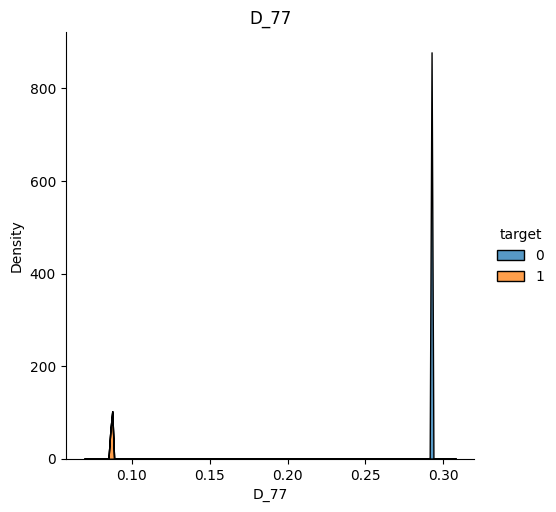

B_25


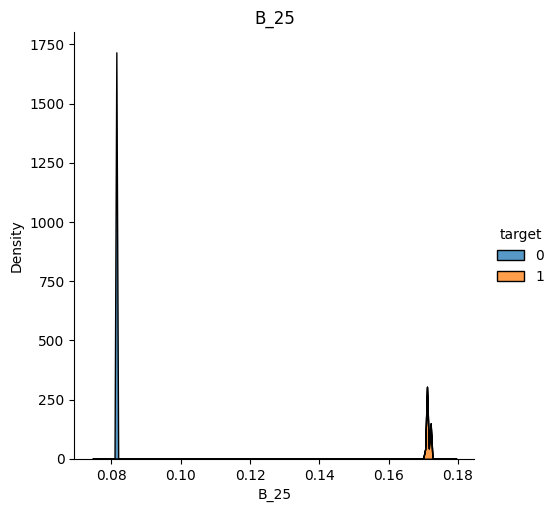

B_26


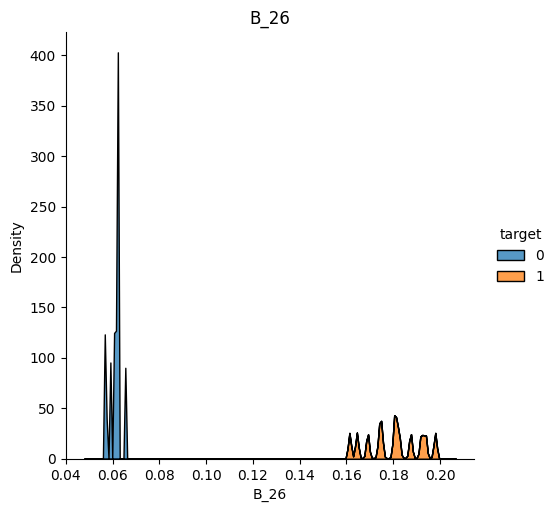

D_78


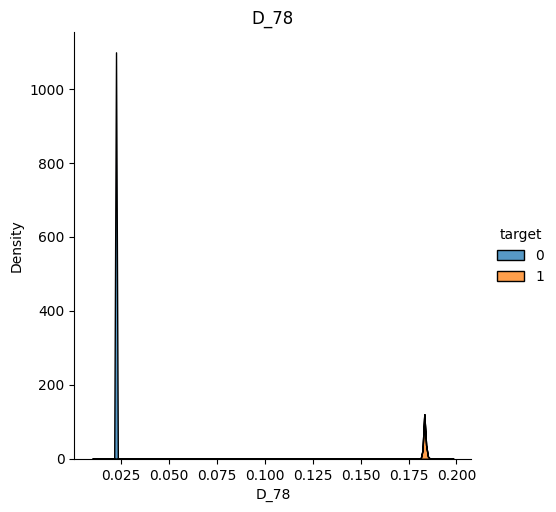

D_79


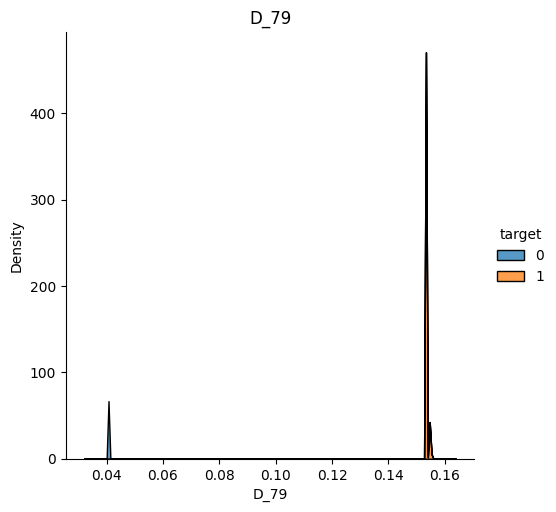

R_8


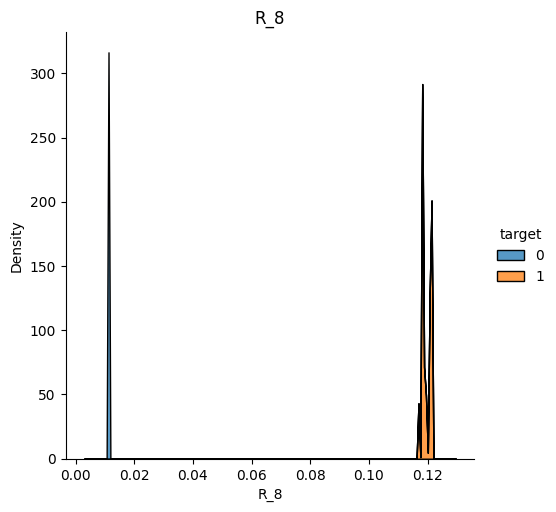

S_16


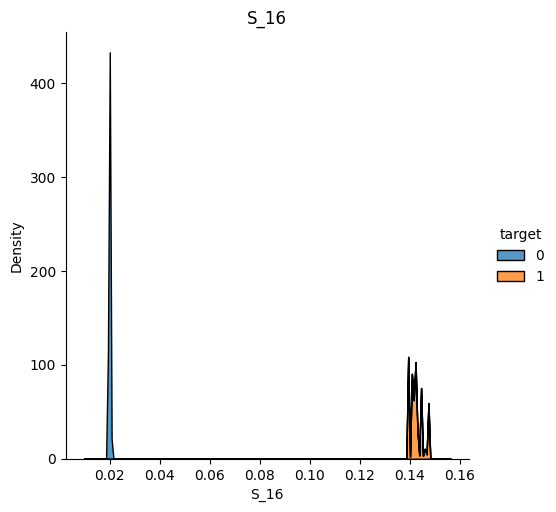

D_80


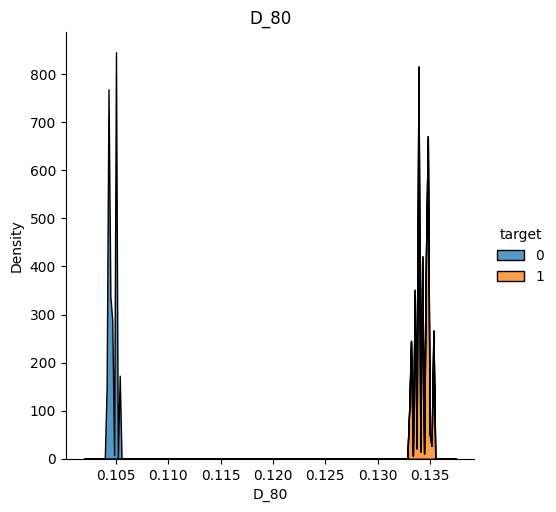

R_10


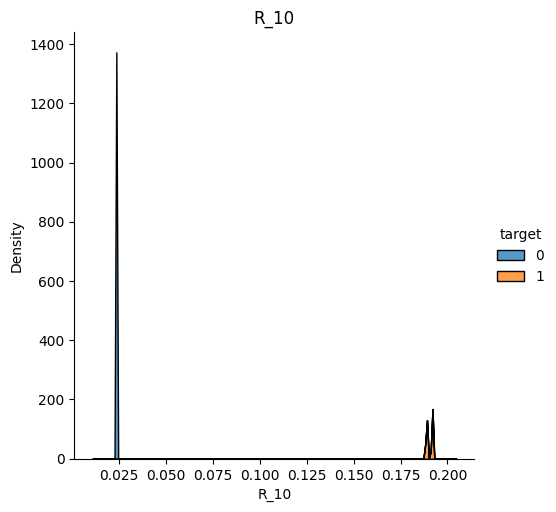

R_11


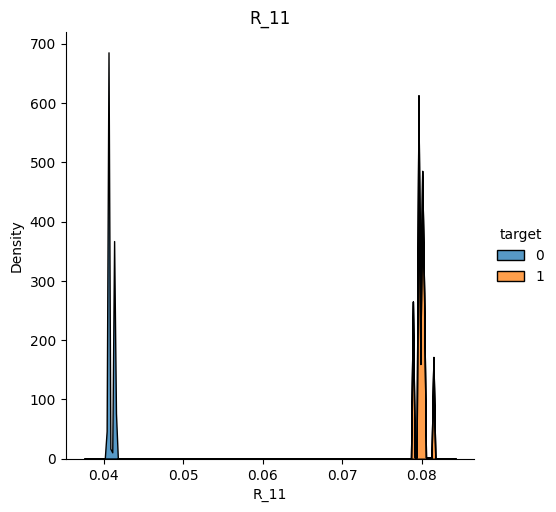

B_27


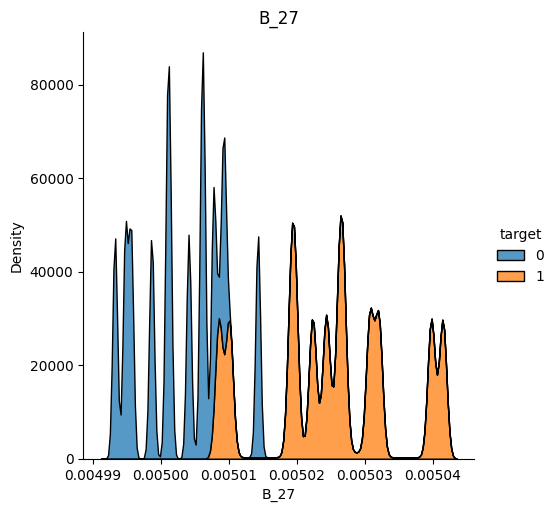

D_81


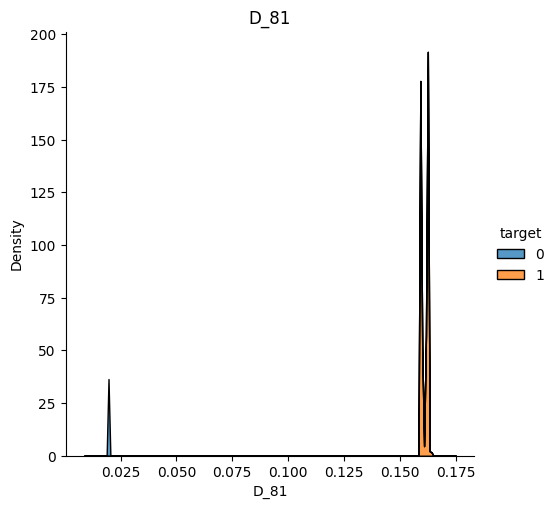

S_17


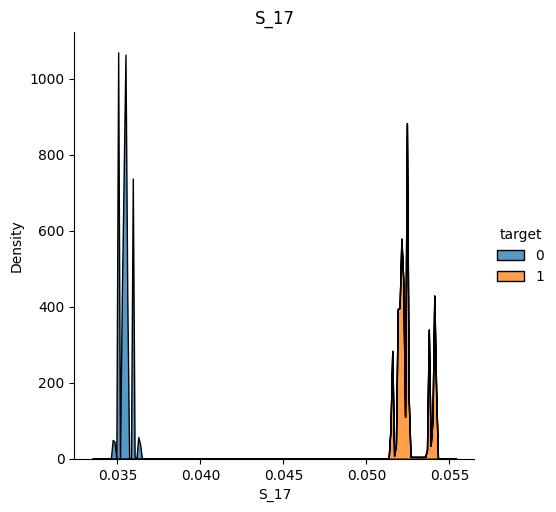

R_12


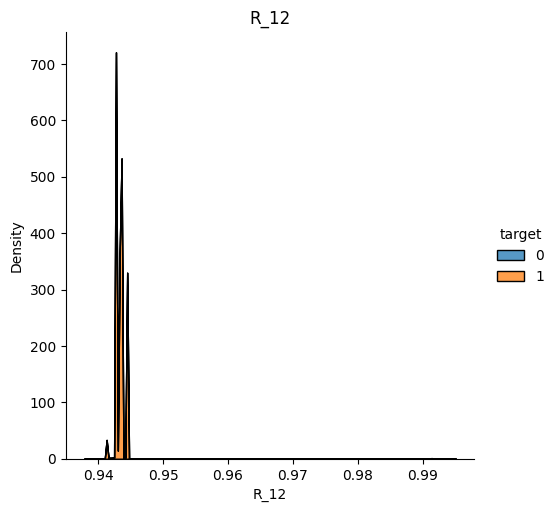

B_28


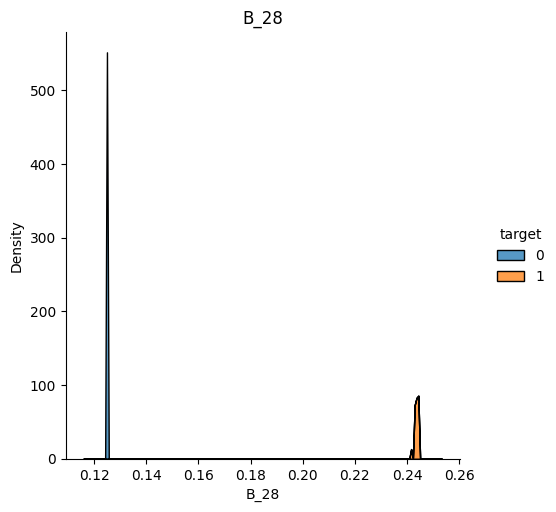

R_13


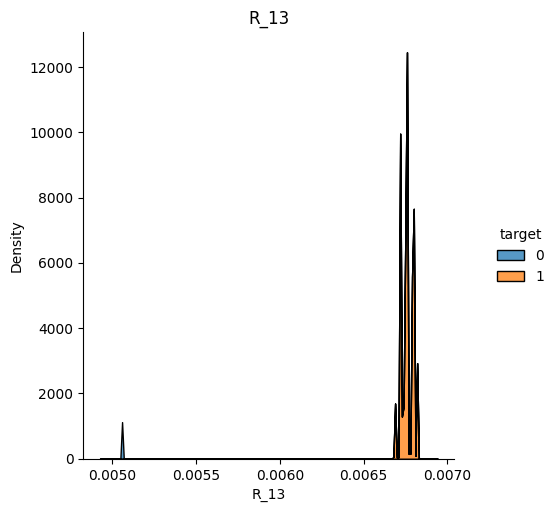

D_83


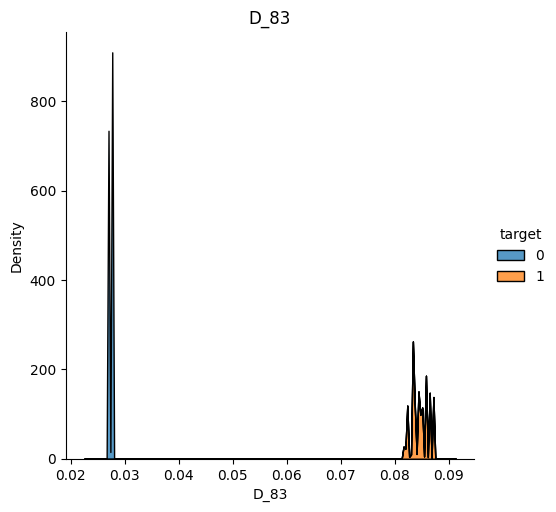

R_14


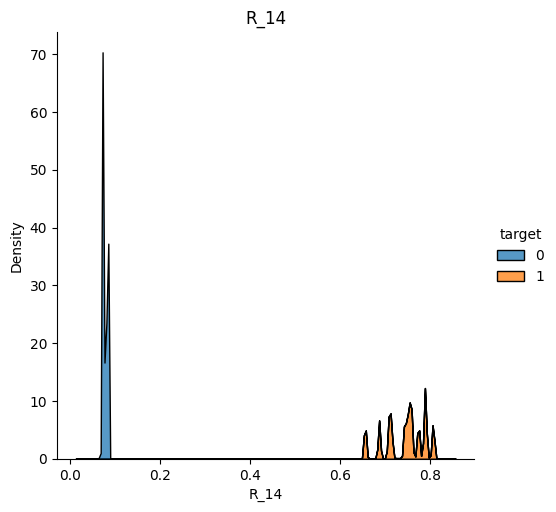

R_15


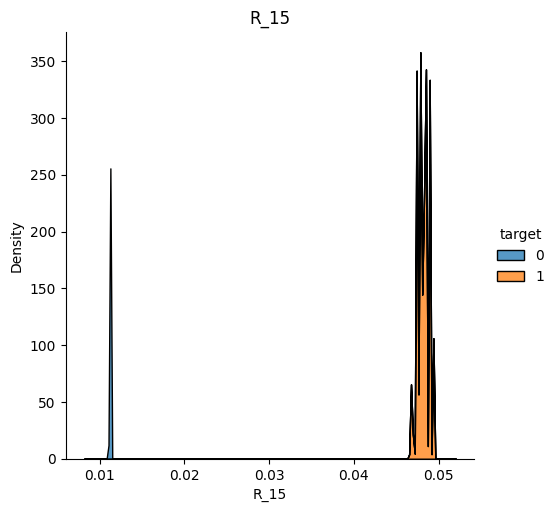

D_84


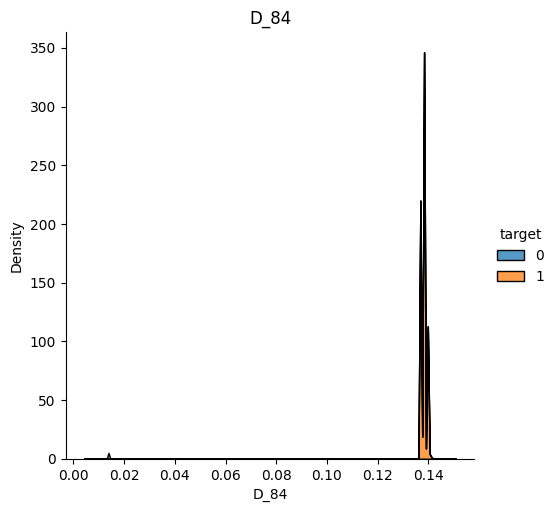

R_16


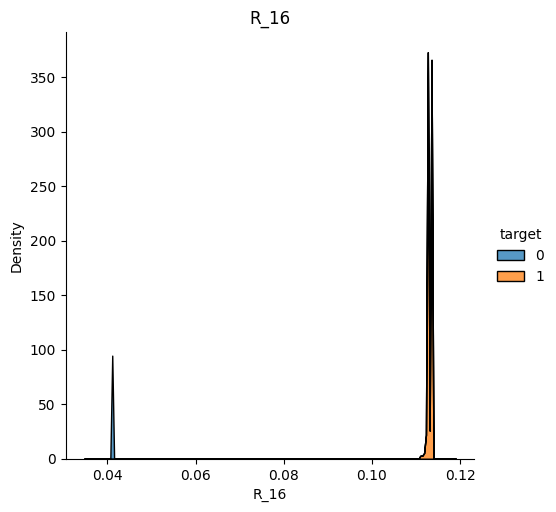

S_18


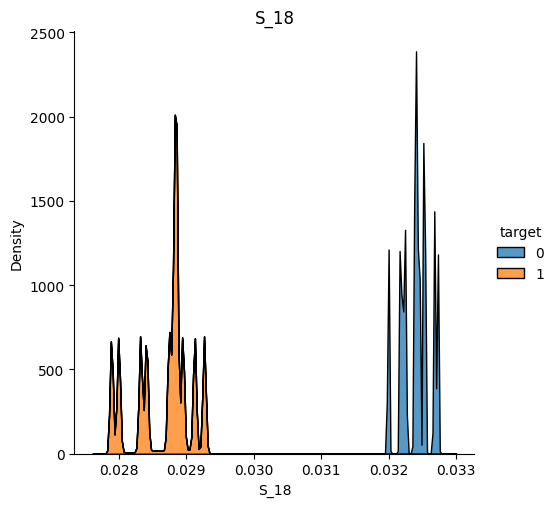

D_86


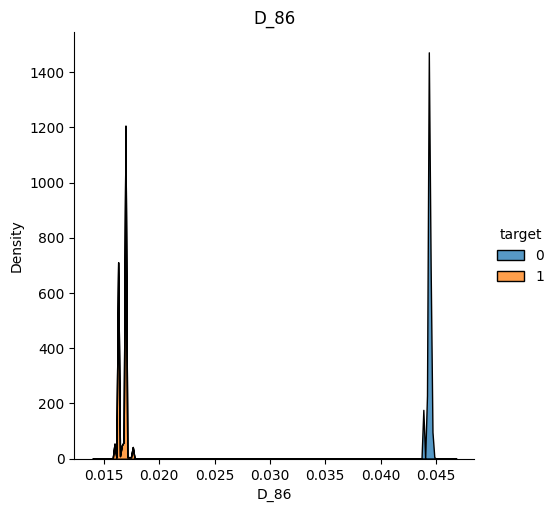

R_17


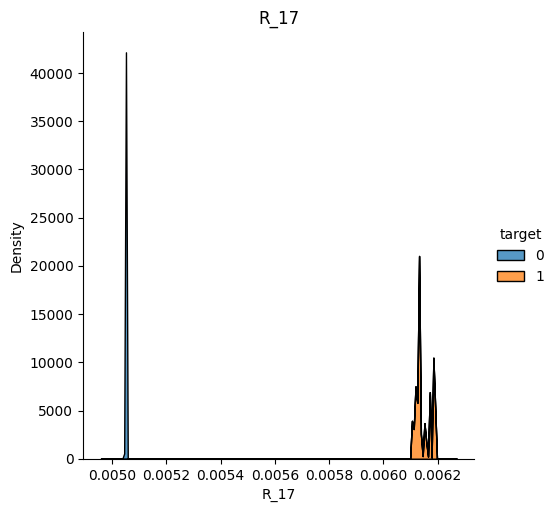

R_18


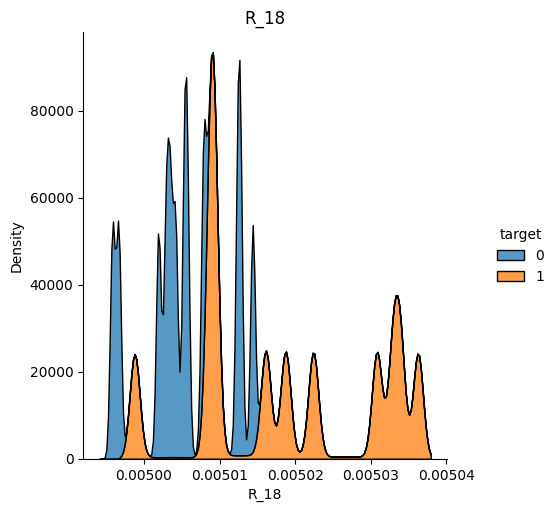

B_31


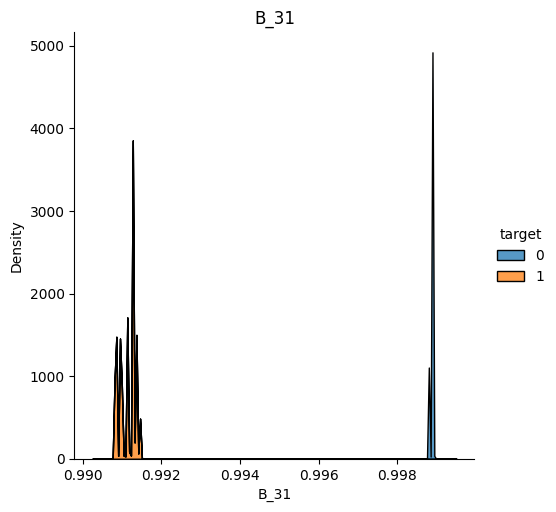

S_19


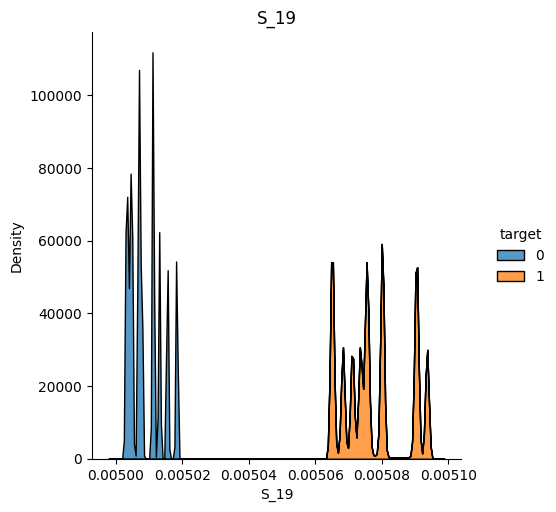

R_19


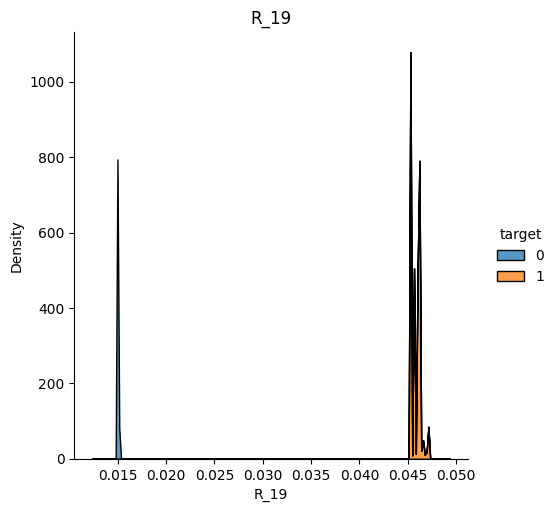

B_32


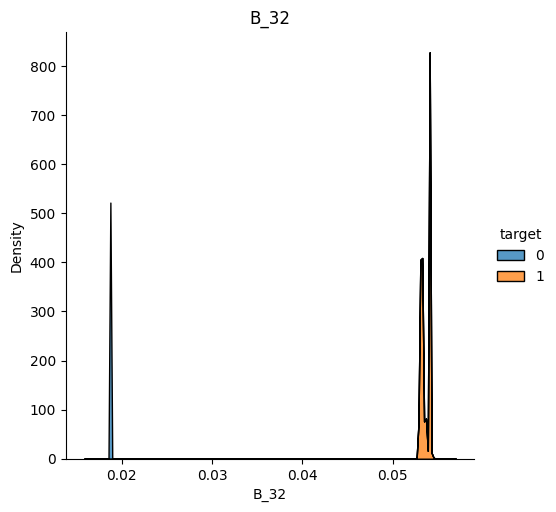

S_20


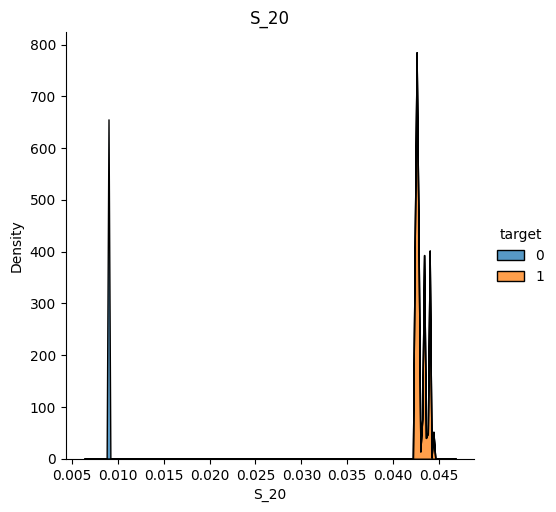

R_20


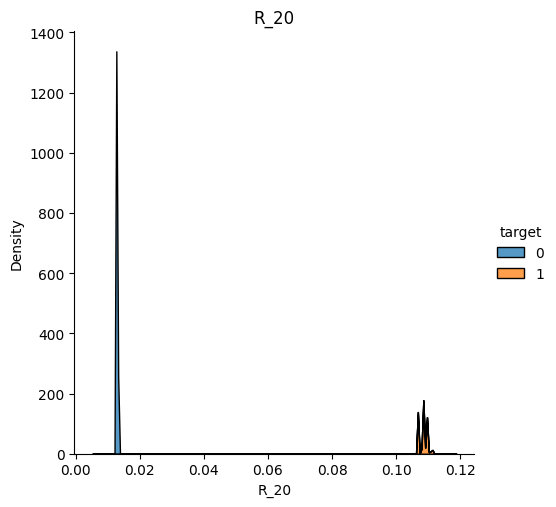

R_21


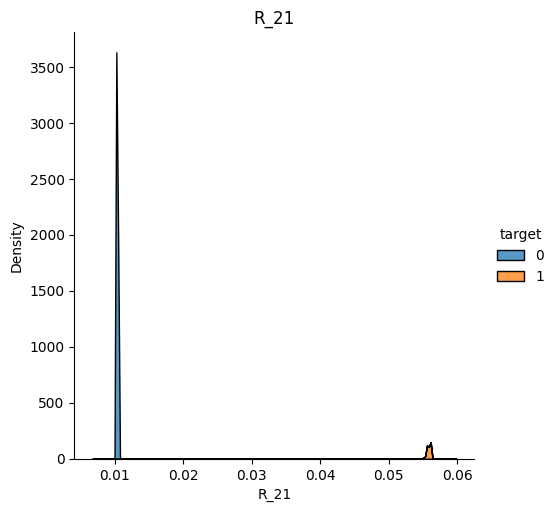

B_33


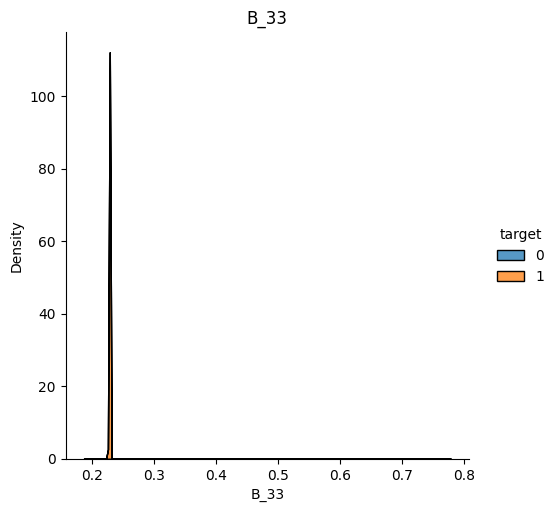

D_89


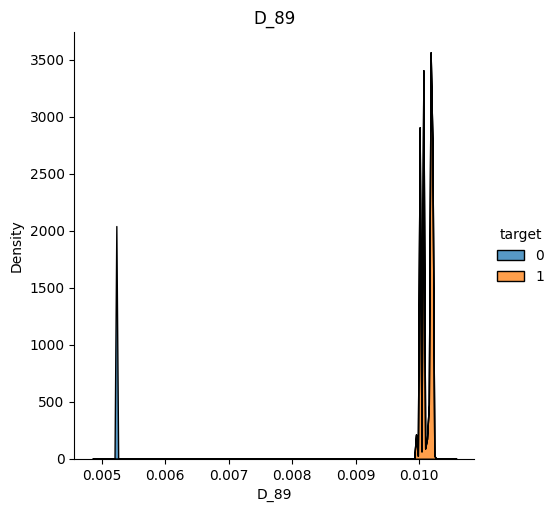

R_22


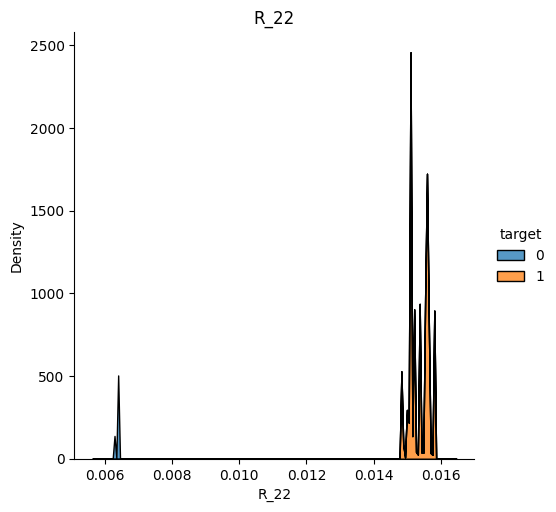

R_23


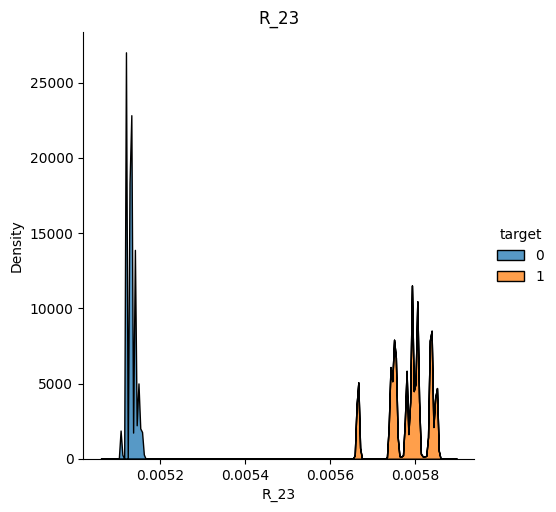

D_91


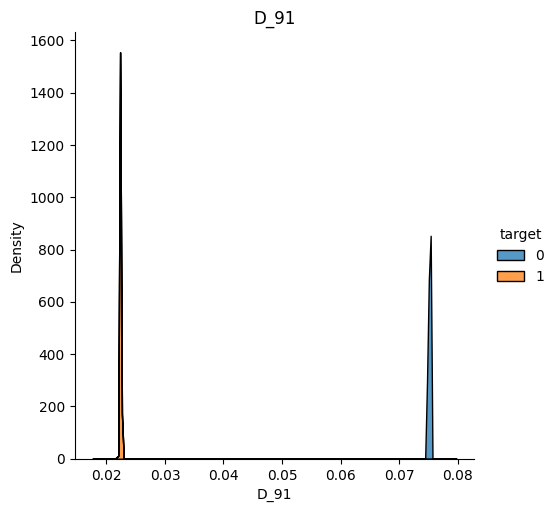

D_92


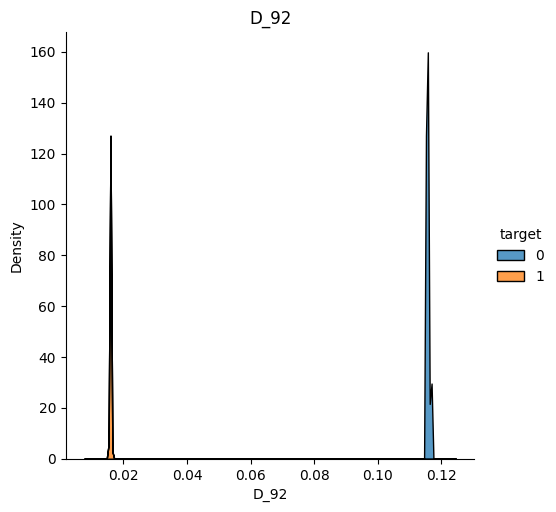

D_93


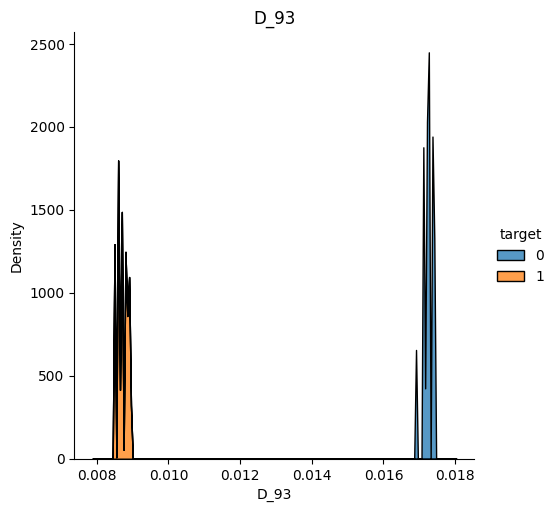

D_94


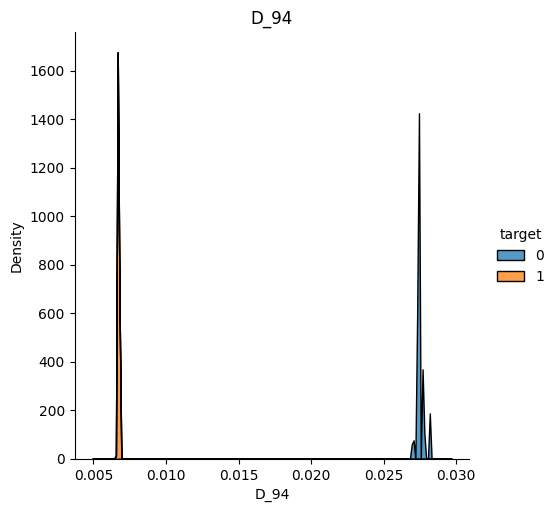

R_24


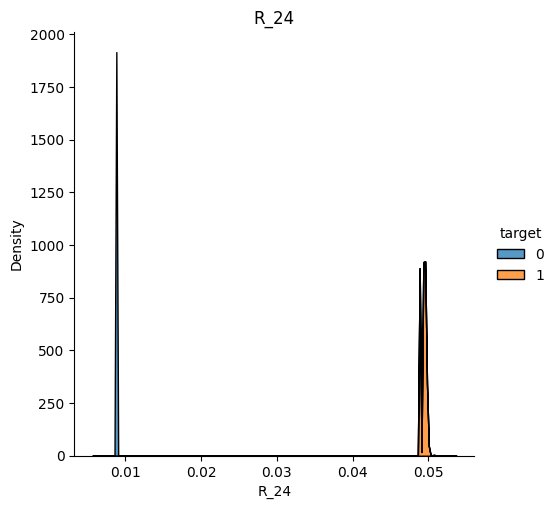

R_25


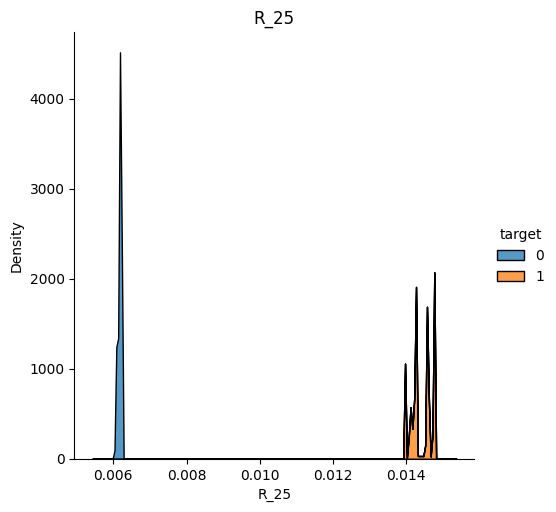

D_96


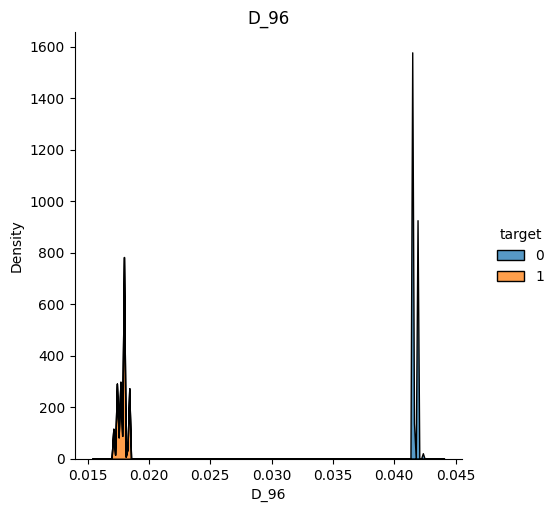

S_22


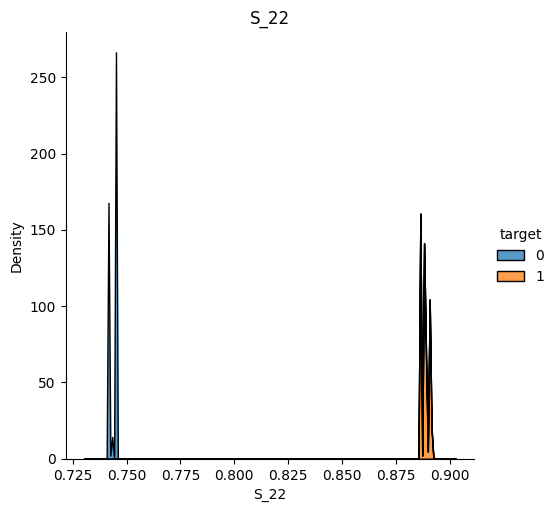

S_23


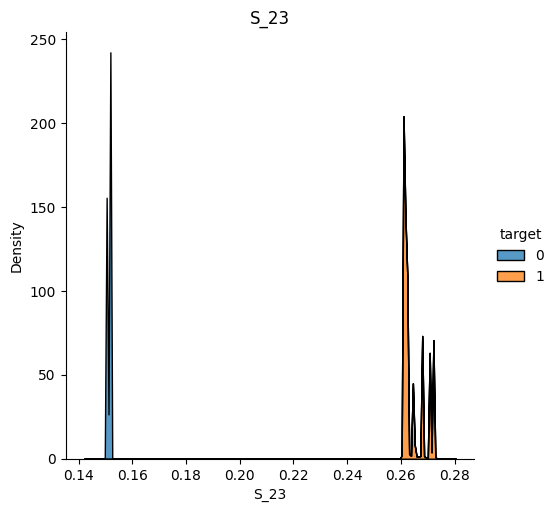

S_24


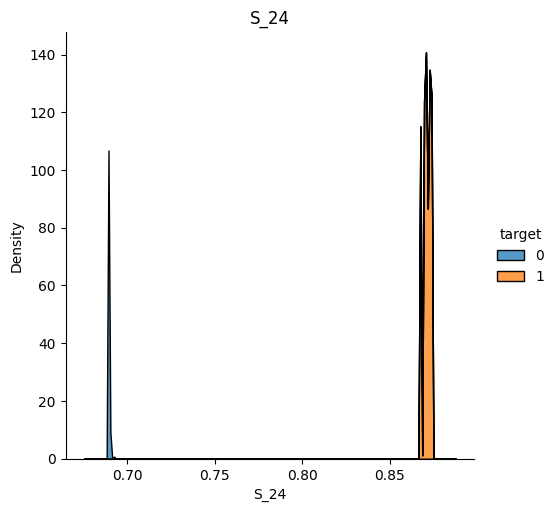

S_25


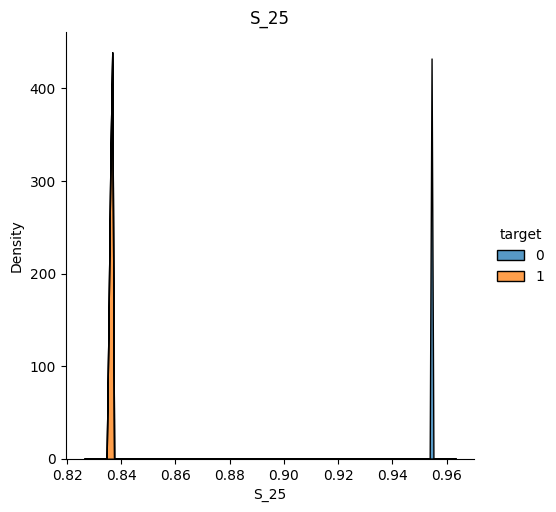

S_26


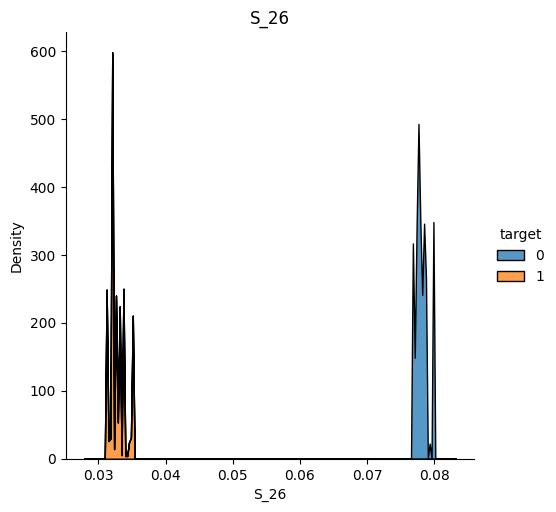

D_102


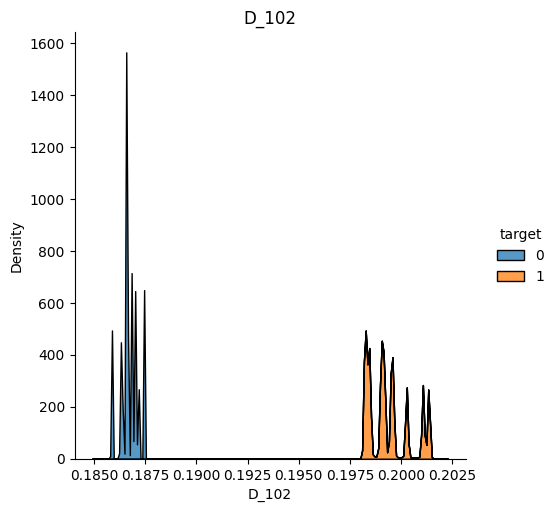

D_103


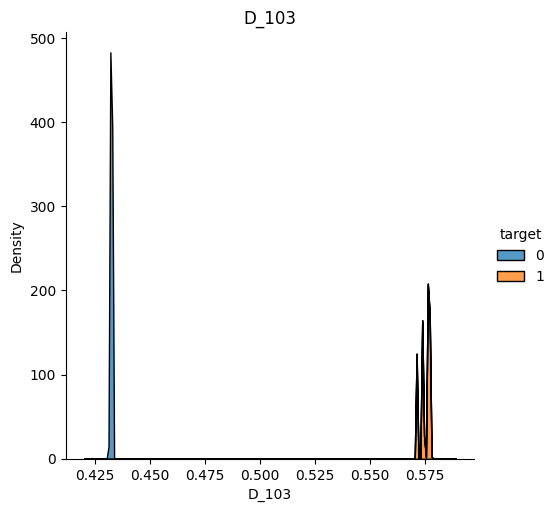

D_104


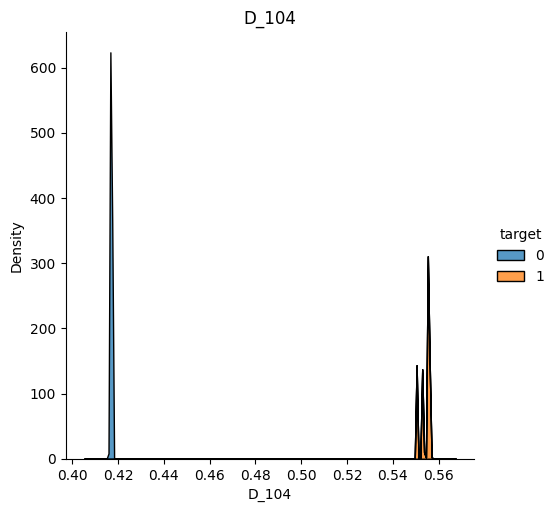

D_107


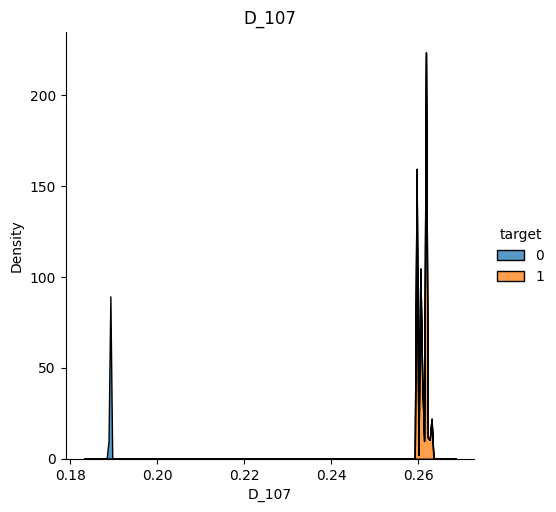

B_36


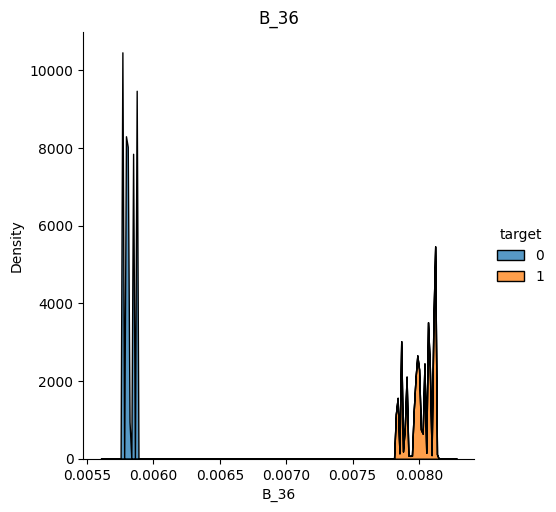

B_37


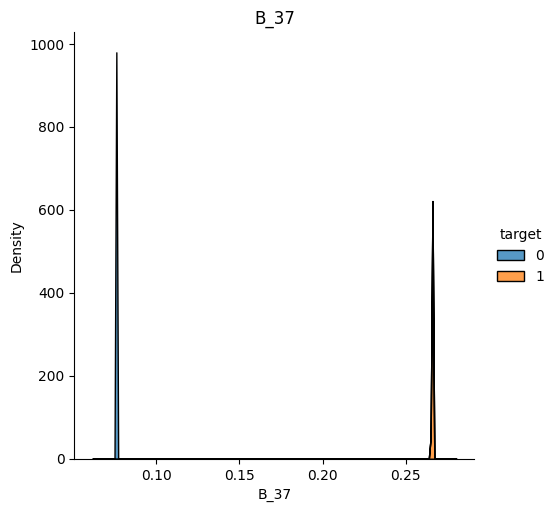

R_27


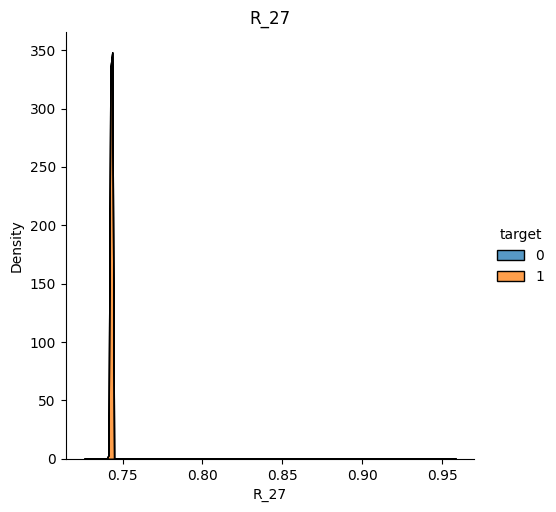

D_109


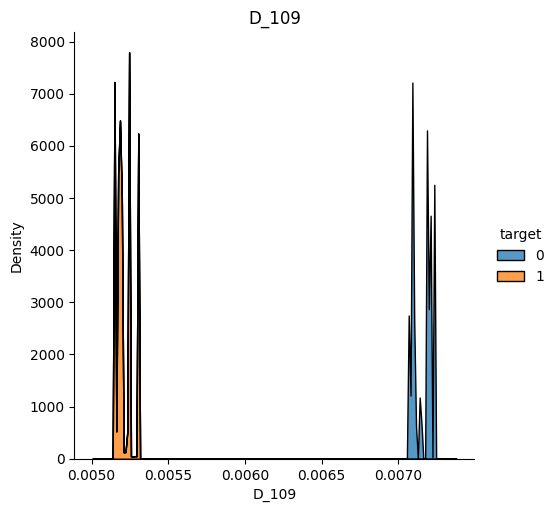

D_112


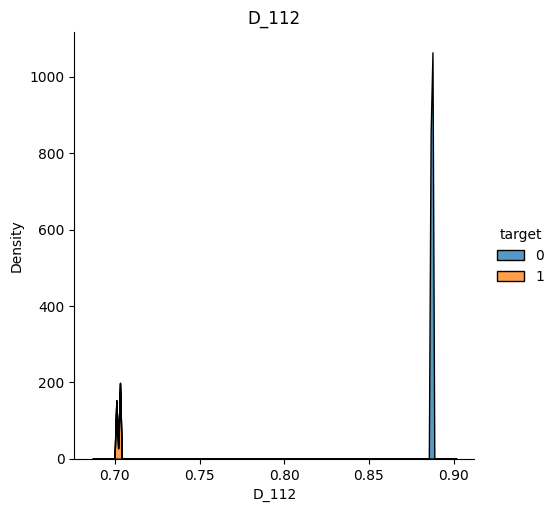

B_40


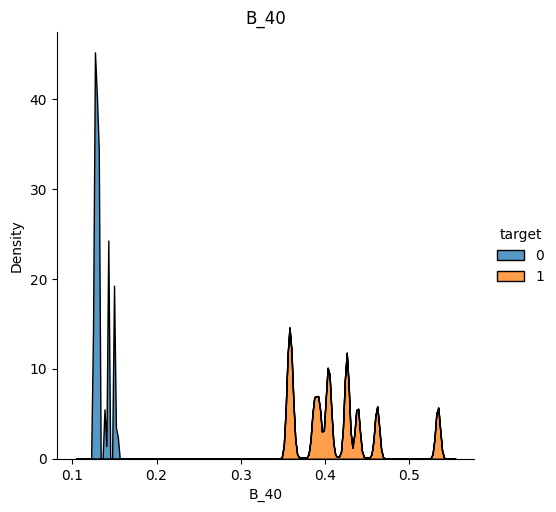

S_27


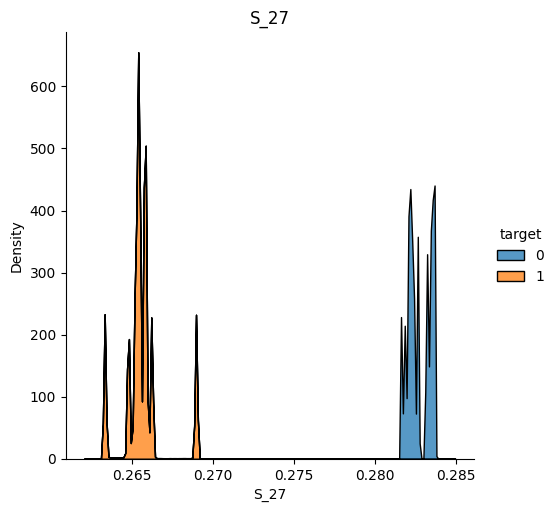

D_113


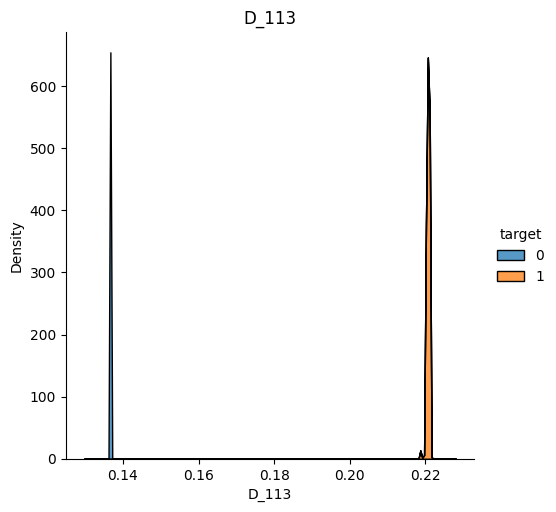

D_115


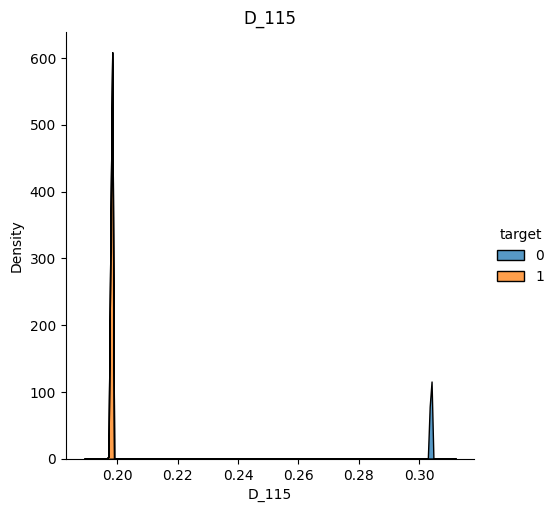

D_116


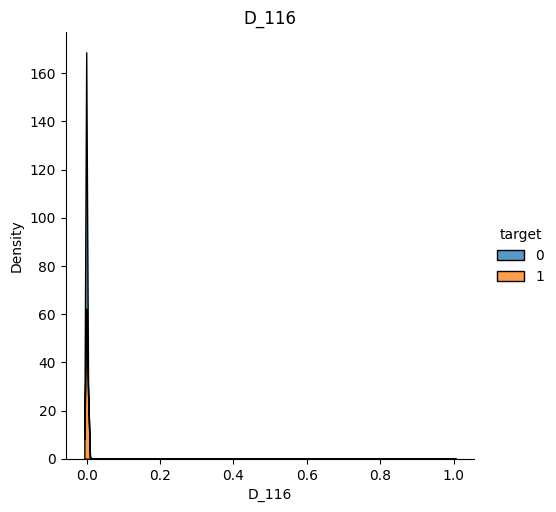

D_118


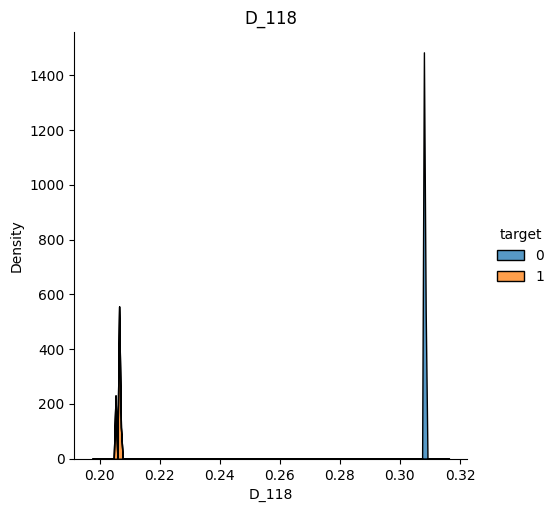

D_119


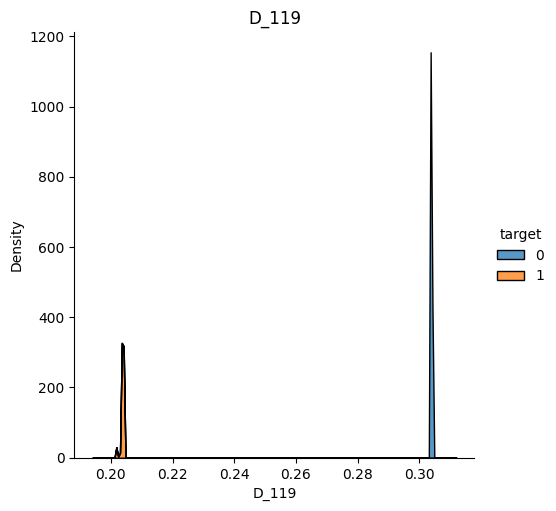

D_121


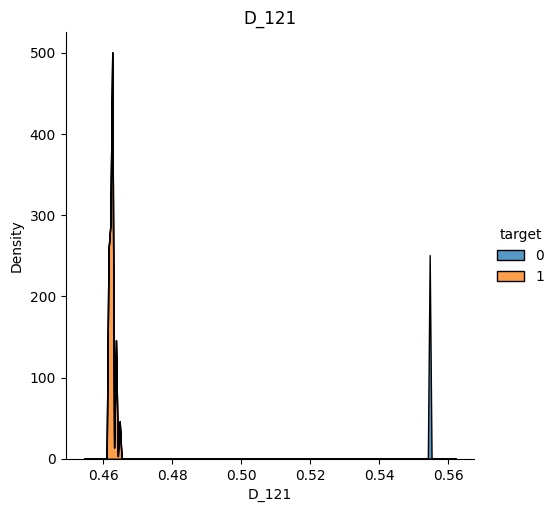

D_122


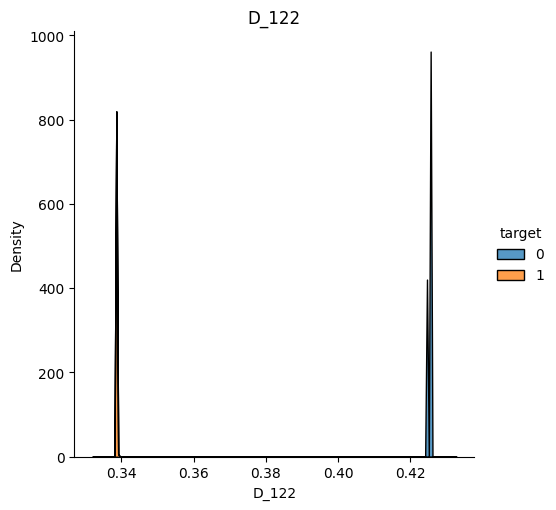

D_123


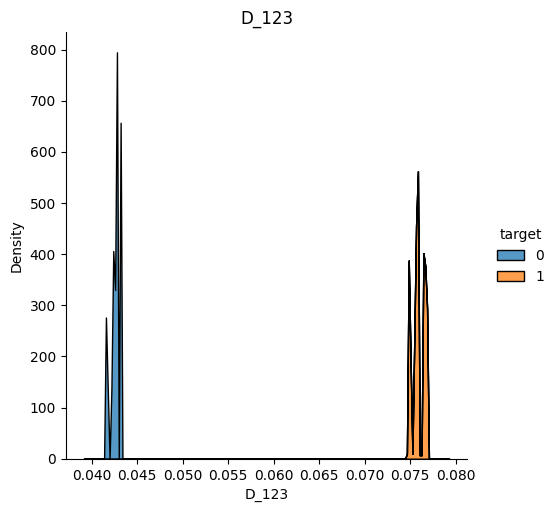

D_124


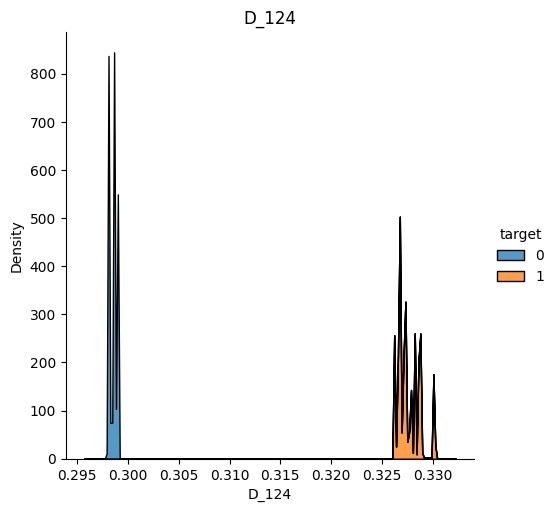

D_125


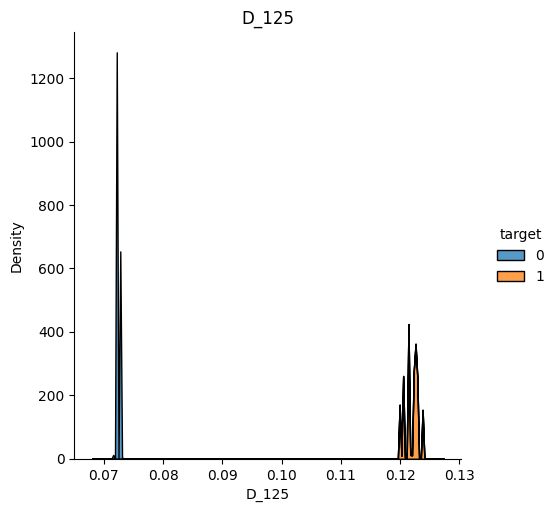

D_127


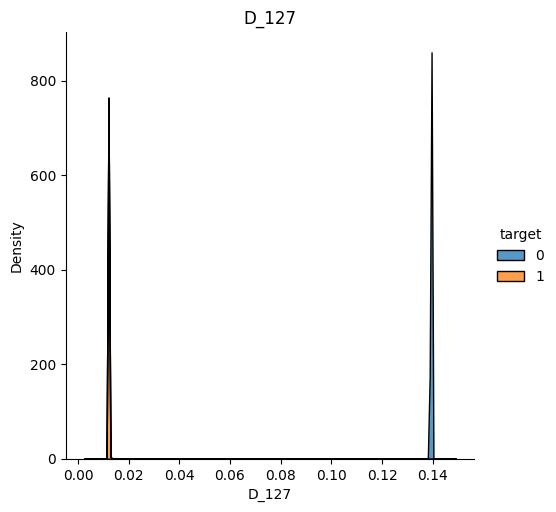

D_128


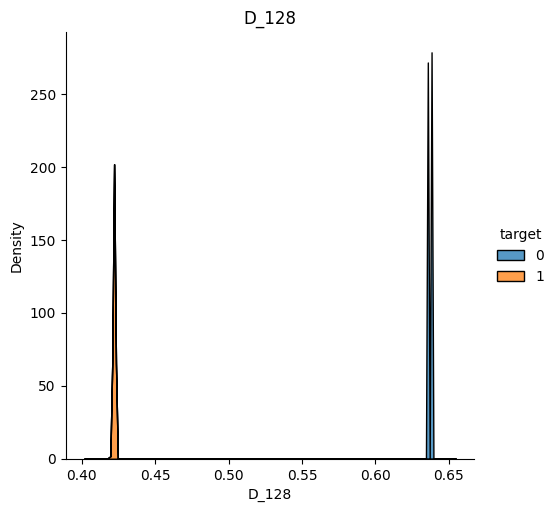

D_129


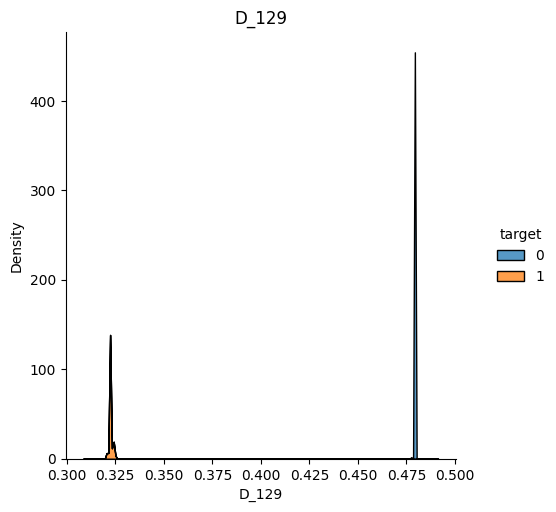

B_41


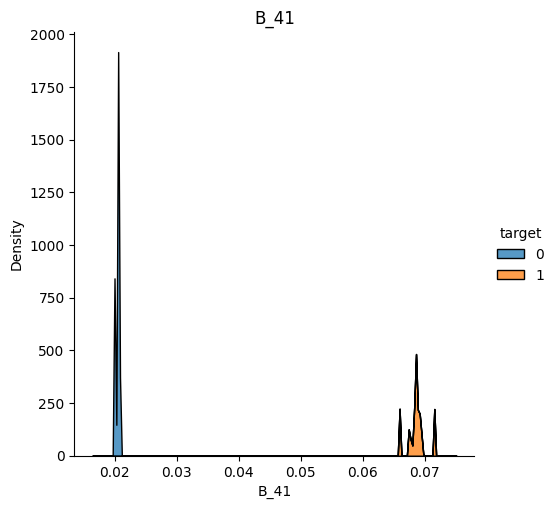

D_130


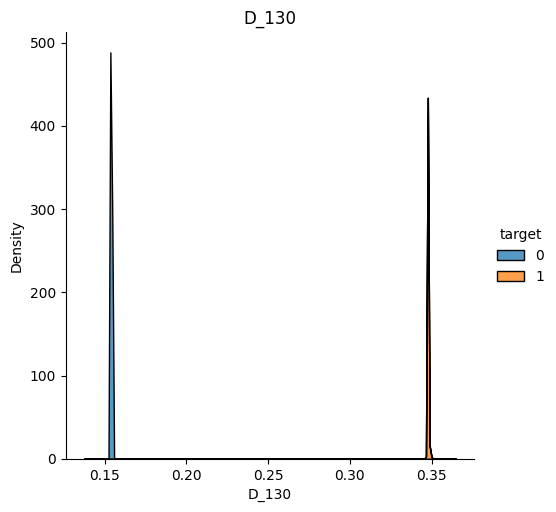

D_131


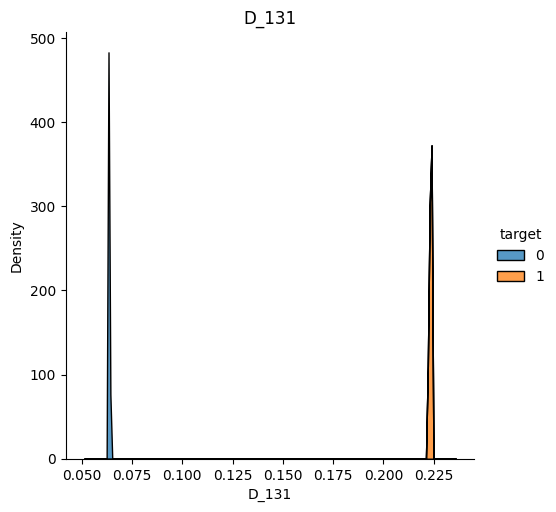

D_133


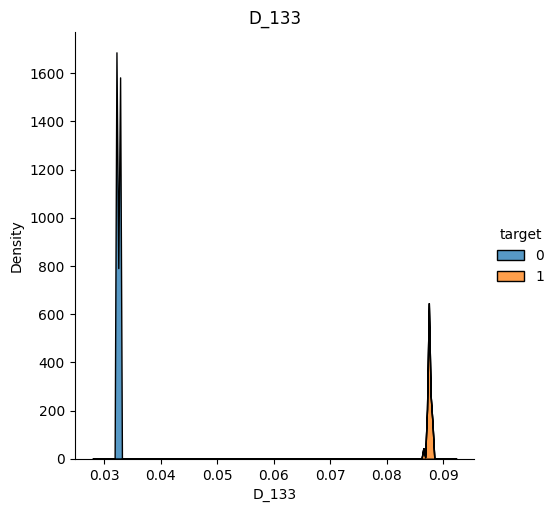

R_28


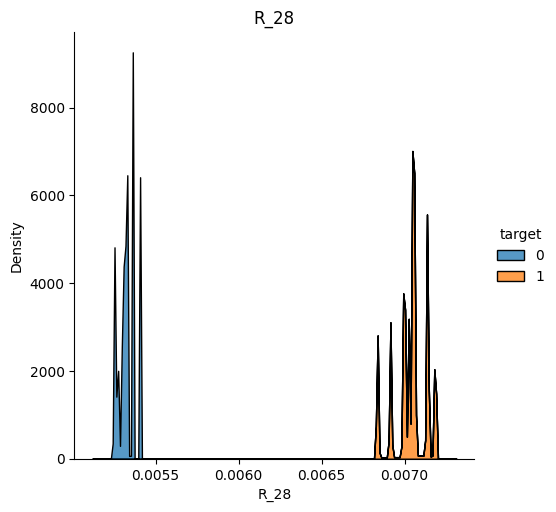

D_139


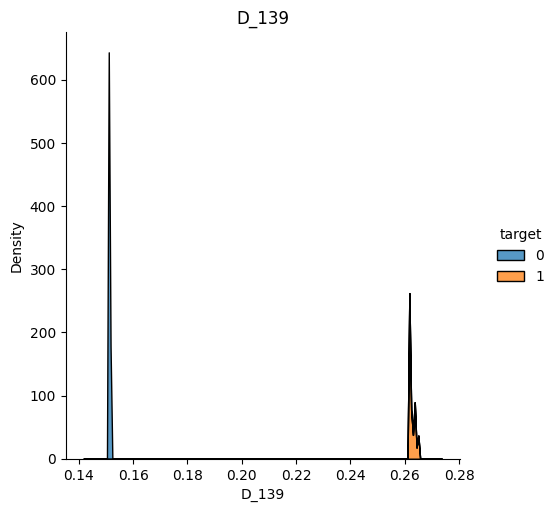

D_140


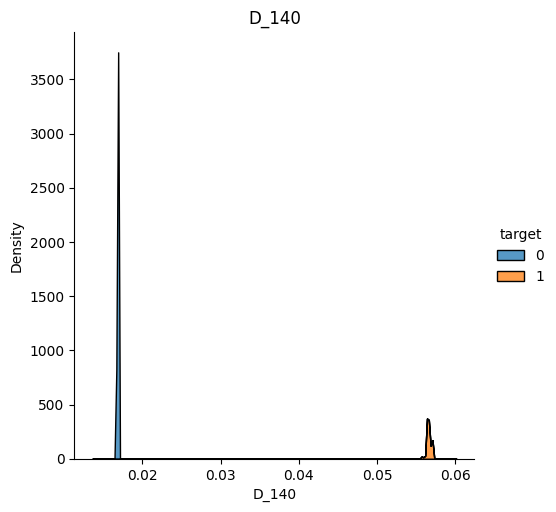

D_141


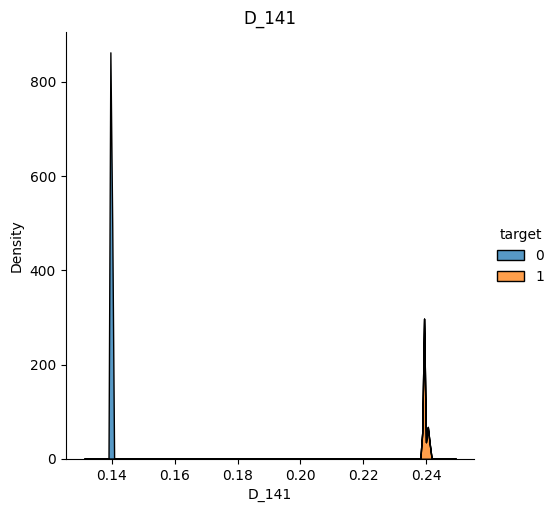

D_143


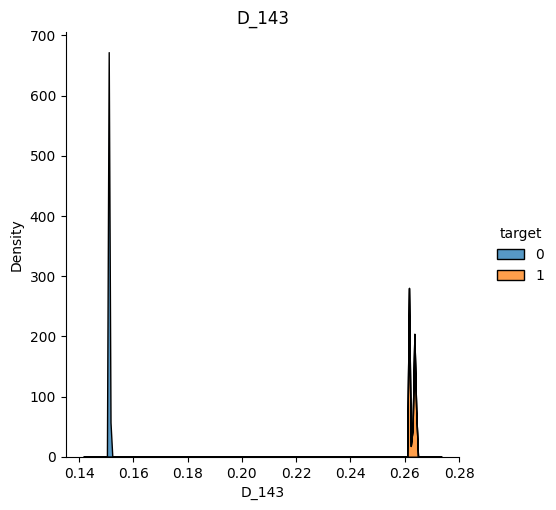

D_144


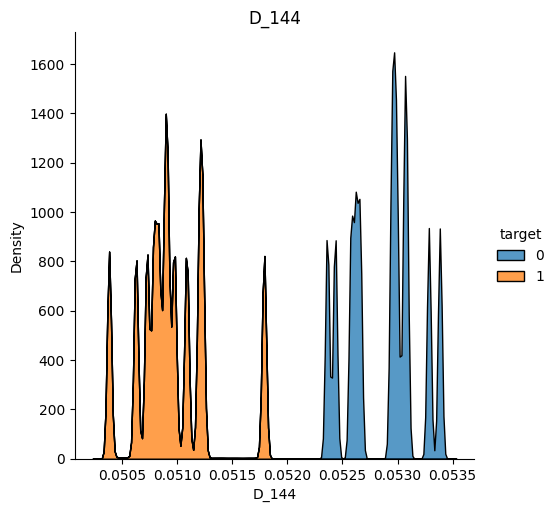

D_145


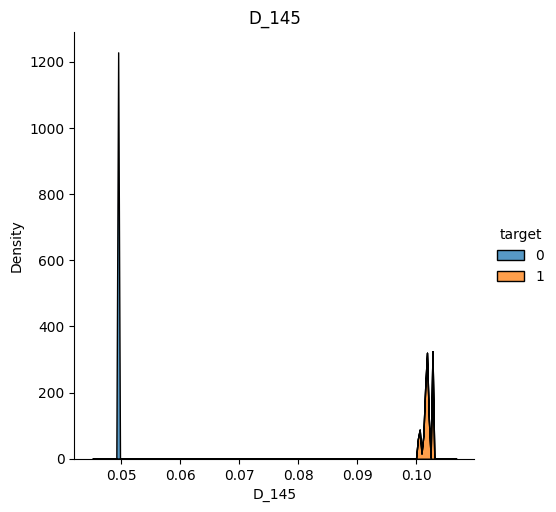

In [6]:
for col in num_features: 

    print(col)
    sns.displot(data = df, x = col,  hue="target", kind="kde", fill=True,  multiple="stack")
    plt.title(col)
    plt.show()

### Feature Selection 

<p>
Feature selection is the process of selecting a subset of relevant features from a large set of features for use in model construction. The goal is to select the most important features that have a strong influence on the output variable and improve the performance of the model while reducing the complexity and overfitting. This can be done through various methods, including statistical tests, feature importance scores, and regularization techniques.
</br>
Some popular feature selection techniques include:
<ul>
<li> Filter Methods: Statistical tests, such as chi-squared, are used to rank and select the most relevant features.</li>

<li> Wrapper Methods: The performance of a model is used as a criterion to determine the optimal set of features.</li>

<li> Embedded Methods: Regularization techniques, such as Lasso and Ridge, are used to penalize features that have little effect on the outcome.</li>

<li> Hybrid Methods: A combination of multiple feature selection techniques is used to generate the final set of features.</li>

<li> Feature Importance: Machine learning algorithms, such as Random Forest, can be used to generate a feature importance score that can be used for feature selection.</li>
</ul>
These are some of the most widely used techniques and each method has its own advantages and disadvantages. The choice of technique depends on the specific problem, the type of data, and the requirements of the model.

</p>

<b> Analising the varience of the all features  </b>
<p>
When a feature has a broader variance, the data is more generic. This means that we have more parameters to learn and identify a pattern. Any data point that has less variance is dropped
</p>

In [45]:
def variance(data):
    # Number of observations
    n = len(data)
    # Mean of the data

    mean = sum(data) / n

    # Square deviations

    deviations = [(x - mean) ** 2 for x in data]

    # Variance

    variance = sum(deviations) / n

    return round(variance, 3 )

<p>
A feature with 0 variance means that all of the observations in the feature have the same value. In other words, there is no variability or spread in the values of the feature. This lack of variability means that the feature does not contain any useful information for a model, as it does not vary with the target variable. In many cases, features with 0 variance are removed from the dataset before modeling as they can negatively affect the performance of the model.
</p>

In [46]:
for i in df.columns[:-1]:
    var = variance(df[i].values)
    print(f" {i} -> {var} ")

    if var == 0.0 :
        df.drop(labels= i, axis= 1, inplace= True)
        print(f'{i} -> dropped')


 P_2 -> 0.03 
 D_39 -> 0.003 
 B_1 -> 0.009 
 B_2 -> 0.05 
 R_1 -> 0.009 
 S_3 -> 0.005 
 D_41 -> 0.003 
 B_3 -> 0.014 
 D_43 -> 0.005 
 D_44 -> 0.014 
 B_4 -> 0.011 
 D_45 -> 0.006 
 B_5 -> 0.001 
 R_2 -> 0.004 
 D_46 -> 0.001 
 D_47 -> 0.006 
 D_48 -> 0.041 
 B_6 -> 0.005 
 B_7 -> 0.013 
 B_8 -> 0.035 
 D_51 -> 0.005 
 B_9 -> 0.025 
 R_3 -> 0.005 
 D_52 -> 0.002 
 P_3 -> 0.002 
 B_10 -> 0.01 
 S_5 -> 0.0 
S_5 -> dropped
 B_11 -> 0.008 
 S_6 -> 0.002 
 D_54 -> 0.001 
 R_4 -> 0.002 
 S_7 -> 0.006 
 B_12 -> 0.001 
 S_8 -> 0.003 
 D_55 -> 0.023 
 B_13 -> 0.0 
B_13 -> dropped
 R_5 -> 0.002 
 D_58 -> 0.018 
 B_14 -> 0.001 
 D_59 -> 0.002 
 D_60 -> 0.001 
 D_61 -> 0.036 
 B_15 -> 0.0 
B_15 -> dropped
 S_11 -> 0.0 
S_11 -> dropped
 D_62 -> 0.008 
 D_63 -> 0.32 
 D_64 -> 0.813 
 D_65 -> 0.001 
 B_16 -> 0.034 
 B_18 -> 0.042 
 B_19 -> 0.017 
 B_20 -> 0.027 
 D_68 -> 1.995 
 S_12 -> 0.0 
S_12 -> dropped
 R_6 -> 0.006 
 S_13 -> 0.001 
 B_21 -> 0.006 
 D_69 -> 0.008 
 B_22 -> 0.009 
 D_70 -> 0.00

<p>
we we see here  we have dropped around 36 features! The dropped 36 features had a varience of 0 as discussed earlier, A feature with zero variance means that all the values for that feature are the same, hence there's no variation or spread in the data for that feature. In other words, it provides no information or discrimination power in distinguishing between different samples or classes. In practice, features with zero variance are often removed from the dataset as they do not contribute to the modeling process.
</p>

In [49]:
df.shape

(3512228, 122)

In [ ]:
# sns.pairplot(df, kind="hist",  hue="diagnosis", corner= True)
# plt.show()

In [ ]:
# # Corelation Matrix

# plt.figure(figsize = (300,100))

# mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
# heatmap = sns.heatmap(df.corr(), mask=mask, annot=True, cmap="YlGnBu")

# heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [50]:
for col in [col for col in df.columns if col not in categorical_values][:-1] :

    corr = pearsonr( df.loc[:, col].values, df.iloc[:, -1].values )
    print(f' {col} correlation --> {corr}' )

    # if corr[0,1] <= 0.5 and corr[0,1] >= -0.5:
    #     print(col)



 P_2 correlation --> PearsonRResult(statistic=-0.9999970560690993, pvalue=0.0)
 D_39 correlation --> PearsonRResult(statistic=0.999907388527145, pvalue=0.0)
 B_1 correlation --> PearsonRResult(statistic=0.9999885817815819, pvalue=0.0)
 B_2 correlation --> PearsonRResult(statistic=-0.9999927673243791, pvalue=0.0)
 R_1 correlation --> PearsonRResult(statistic=0.9999702892934763, pvalue=0.0)
 S_3 correlation --> PearsonRResult(statistic=0.9999732987183845, pvalue=0.0)
 D_41 correlation --> PearsonRResult(statistic=0.9999030579483057, pvalue=0.0)
 B_3 correlation --> PearsonRResult(statistic=0.9999852604578735, pvalue=0.0)
 D_43 correlation --> PearsonRResult(statistic=0.9999430667868963, pvalue=0.0)
 D_44 correlation --> PearsonRResult(statistic=0.9999824712189342, pvalue=0.0)
 B_4 correlation --> PearsonRResult(statistic=0.9999888097828783, pvalue=0.0)
 D_45 correlation --> PearsonRResult(statistic=-0.9999749211682476, pvalue=0.0)
 B_5 correlation --> PearsonRResult(statistic=-0.99957517

<p>
As we see here from the pValue is 0.0 which means there is no Linear relationship between the Independent and Dependent feature. But we have a high corellation between the two. Thus we cannot fit the linear model to this dataset 
</p>

In [51]:
# feature 'D_116' has only one value i.e, so drop that feature 
df.drop(labels= 'D_116', inplace= True, axis= 1)

<p>
A <b> wrapper method for feature selection </b> is a type of feature selection technique that uses a machine learning algorithm as a <b>"wrapper"</b> around the feature selection process. The goal of wrapper methods is to use the performance of the machine learning algorithm as a criterion to evaluate the usefulness of each feature.
</br>
</br>
The basic idea behind wrapper methods is to train the machine learning model multiple times, each time using a different subset of features. The feature subsets are chosen based on a search algorithm that considers all possible combinations of features. The search algorithm evaluates the performance of the machine learning model for each feature subset, and the best subset of features is selected based on some performance metric, such as accuracy or F1 score.
</br>
</br>
Wrapper methods can be computationally expensive because they require training the machine learning model multiple times. However, they are considered to be more reliable than filter methods, which simply rank the features based on some simple criterion, such as correlation with the target variable. Wrapper methods take into account the relationship between the features and the target variable as well as the relationships between the features themselves, which can lead to better performance in some cases.
</p>

<b> Boruta </b>
The algorithm is pretty interesting and if you ask me, I think it is really smart. So far, the whole idea in Wrapper methods is features competing against each other for a position in the final subset. Instead in Boruta, the features compete with a randomized version of themselves (shadow features). A feature is selected only if it performs better than the best performing randomized feature.

<img src="support_images/Screenshot 2023-02-07 at 6.33.50 pm.png" alt="BORUTA">

In [18]:
# select the numerical features 
temp = df.loc[ : , [col for col in df.columns if col not in categorical_values][:] ]

# create object of 
sclar = MinMaxScaler()

# convert data into 2D array 
X =  sclar.fit_transform(temp.iloc[:, :-1].values)
y = temp.iloc[:, -1].values

# create object for randome folrest classifier 
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=5, n_jobs=-1)

boruta = BorutaPy(estimator = clf, n_estimators = 'auto', max_iter = 100) # number of trials to perform

# train the model by passing the parameters 
boruta.fit(X, y)

# results per region
green_area = temp.iloc[:, :-1].columns[boruta.support_].to_list()
blue_area = temp.iloc[:, :-1].columns[boruta.support_weak_].to_list()
red_area = temp.iloc[:, :-1].columns[~boruta.support_].to_list()

print('Green area:', green_area)
print('Blue area:', blue_area)
print('Red area:', red_area)

Green area: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'R_5', 'D_58', 'B_14', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'B_16', 'B_18', 'B_19', 'B_20', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'R_10', 'D_81', 'R_12', 'B_28', 'D_83', 'R_14', 'D_84', 'R_16', 'R_20', 'R_21', 'B_33', 'D_91', 'D_92', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_103', 'D_104', 'D_107', 'B_37', 'R_27', 'D_112', 'B_40', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_133', 'D_139', 'D_141', 'D_143', 'D_145']
Blue area: []
Red area: []


<p>
As we see from the above results all the numerical features are considered as significant features 
</p>

### Handle Outliers
<ol>
<li> What is an Anomaly/Outlier? </br>
An outlier is a data point that differs significantly from other observations in statistics. An outlier can be the result of measurement variability or it can be the result of experimental error. In statistical analysis, an outlier might generate major consequences. </li>

<li>Why Care about Anomaly? </br>
Detecting and correcting outliers is one of the most critical tasks in data preparation since they can have a detrimental impact on statistical analysis and the training process of a predictive model, resulting in reduced accuracy.</li>

<li> Five Ways to detect Anomaly 
Here are some of the ways to delt with outliers </br>
<ul>
<li> Standard Deviation </li>
<li> Boxplots </li>
<li> DBScan Clustering </li>
<li> Isolation Forest </li>
<li> Robust Random Cut Forest </li>
</ul>
</li>
</ol>

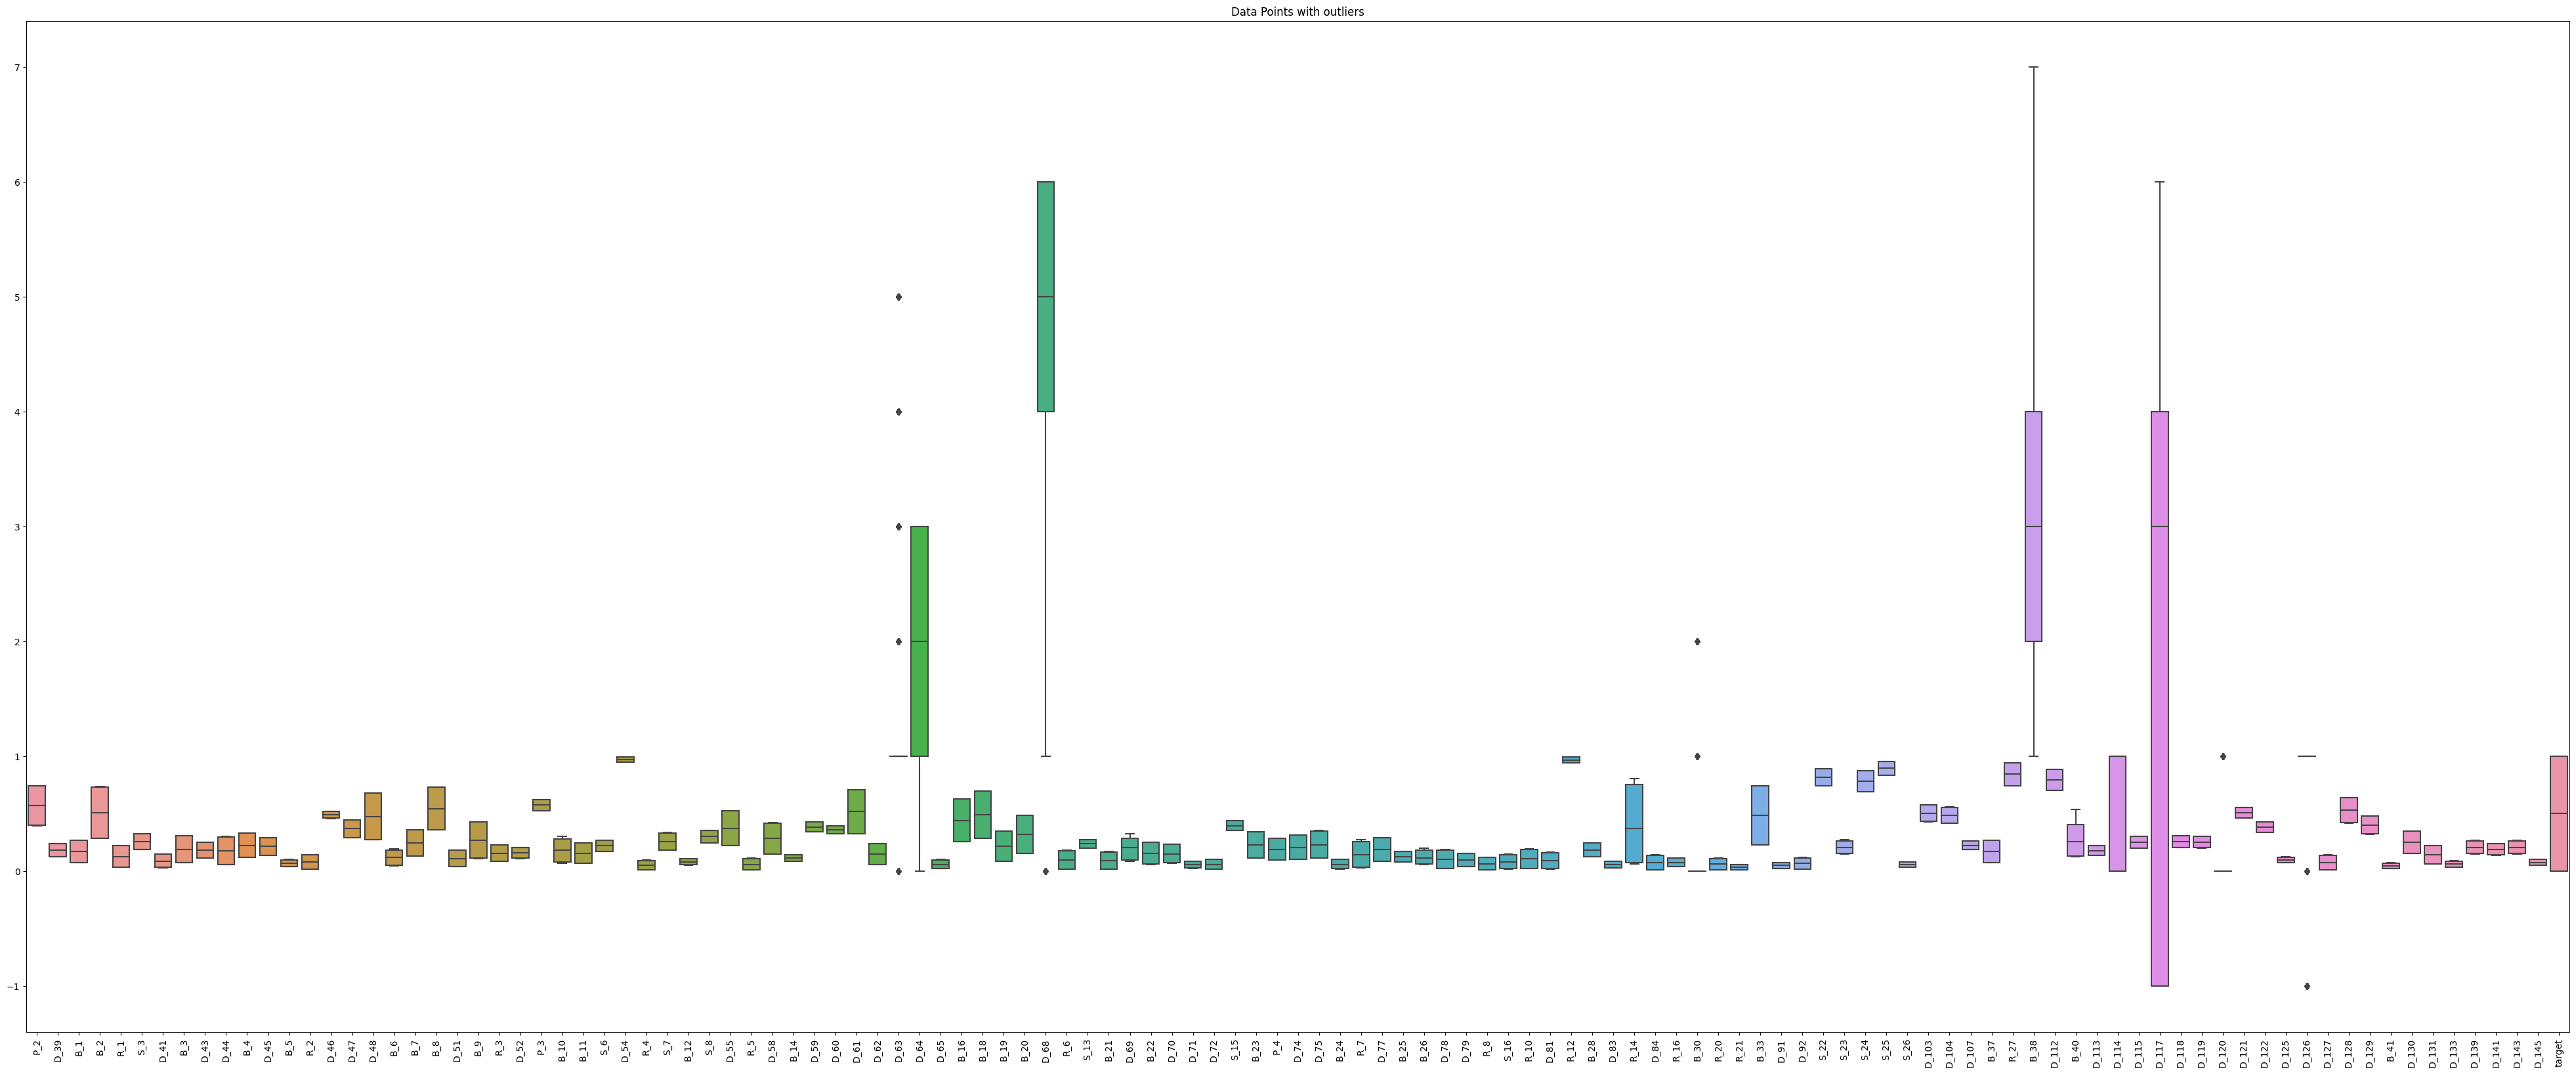

In [52]:
# Outlier Detection 
#Using Boxplot to display outliers present in the dataset

plt.figure(figsize=(50,20))
plt.title("Data Points with outliers")
sns.boxplot(data = df)
plt.xticks(rotation = 90)
plt.show()

<p>
Here we are going to use Inter quartilie method to determine the Lower and Upper bound. The IQR is obtained by finding the difference between the upper quartile and the lower quartile. Any data that is outide the IQR range is considered as an outlier and that record is eliminated
</p>

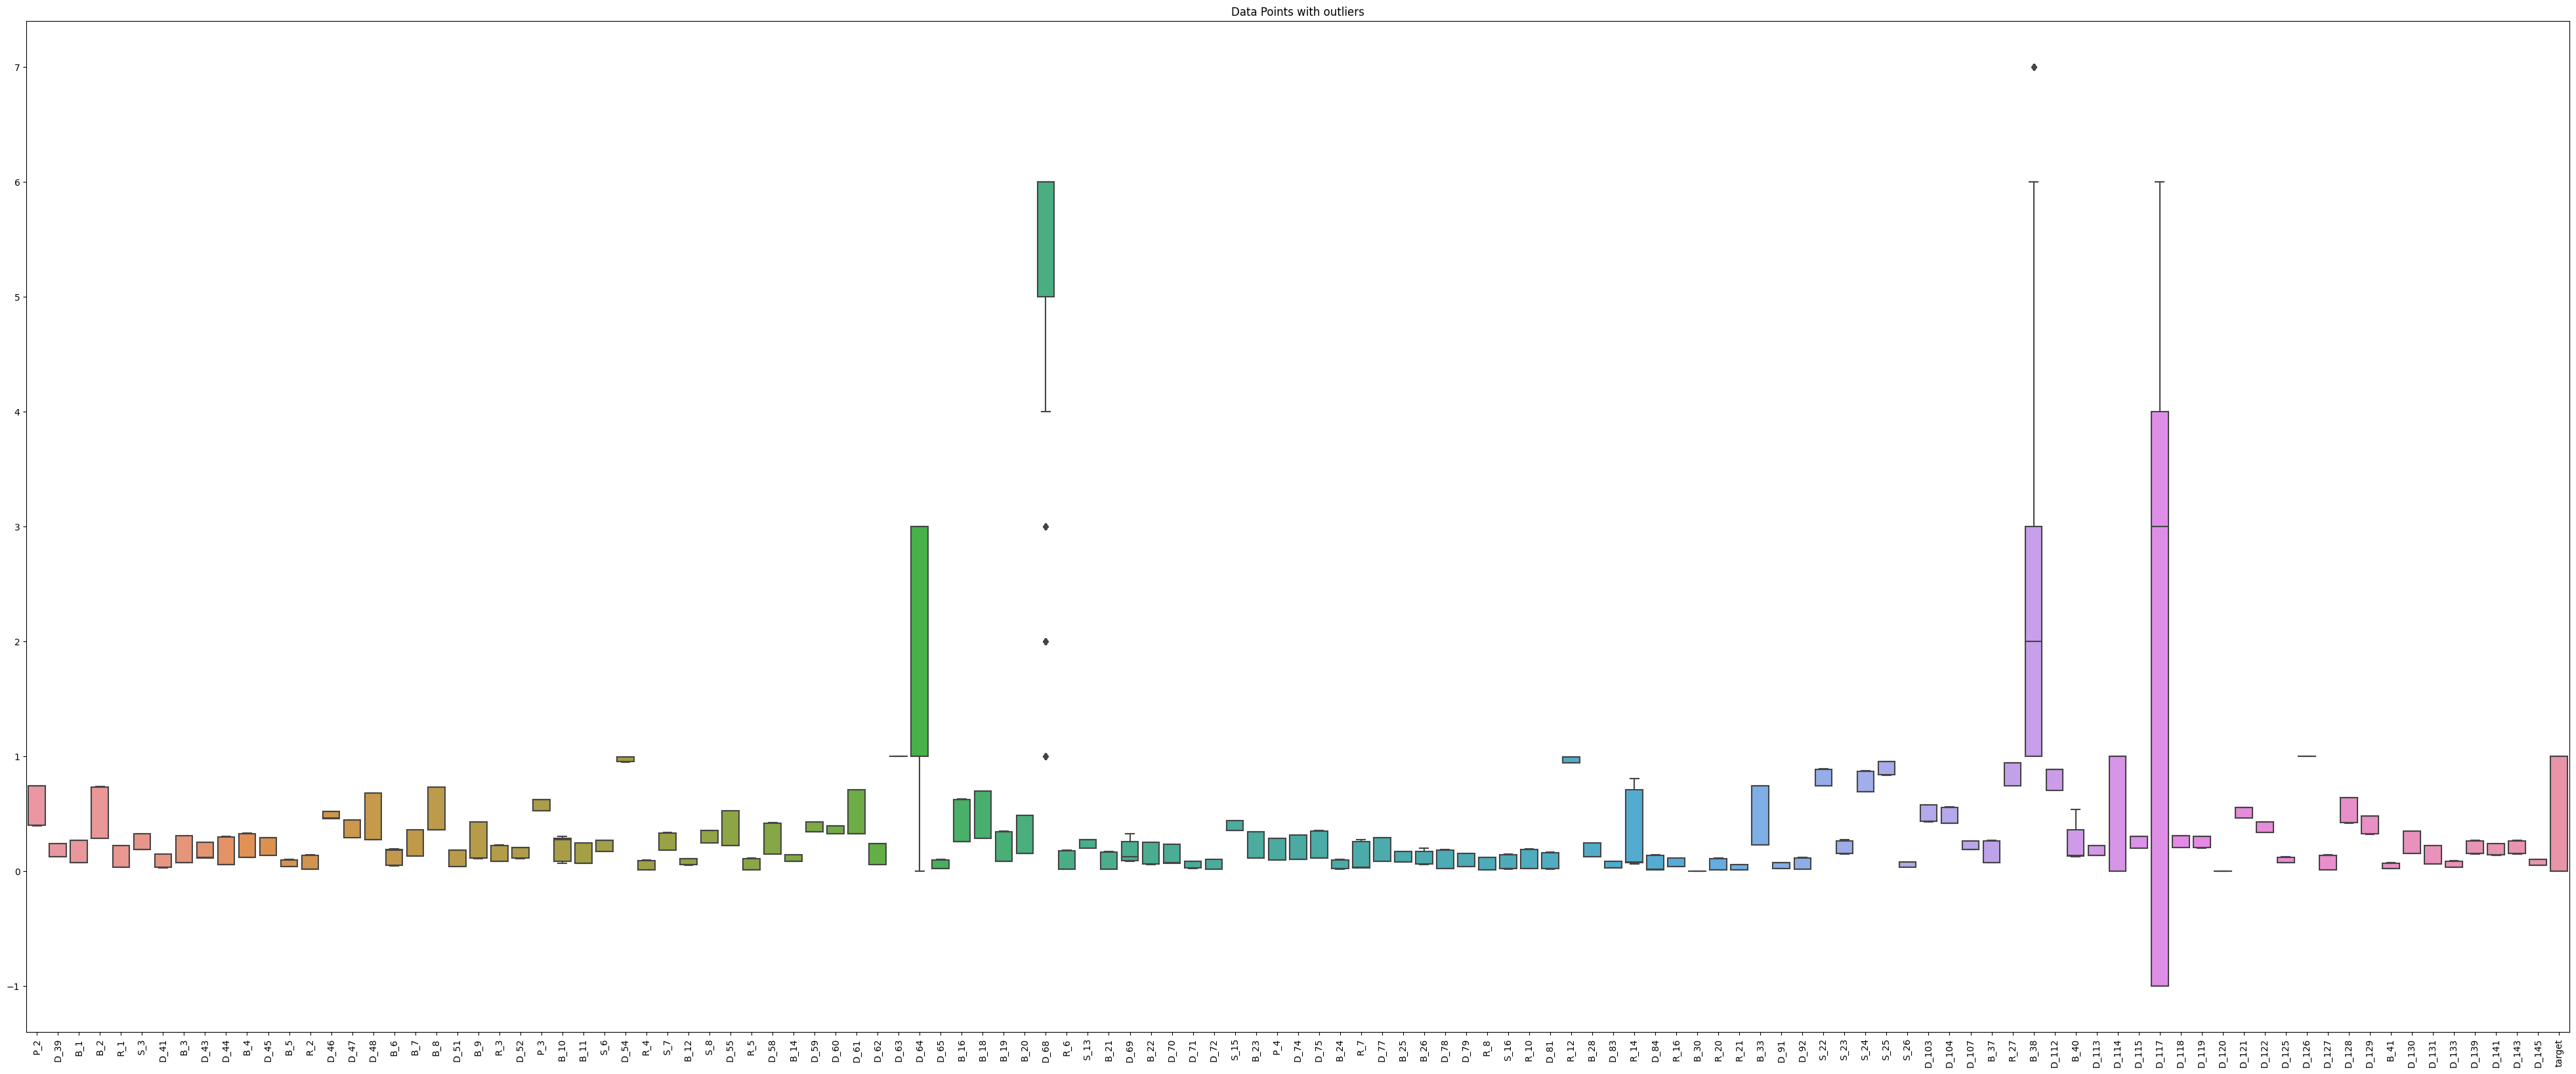

In [53]:
# Find the upper bound and lower bound for every feature 

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
lower_bound = (Q1-1.5*IQR)
upper_bound = (Q3+1.5*IQR)


df = df[~((df < lower_bound) | (df > upper_bound ) ).any(axis = 1)];

#Using Boxplot to display outliers present in the dataset
plt.figure(figsize=(50,20))
plt.title("Data Points with outliers")
sns.boxplot(data = df)
plt.xticks(rotation = 90)
plt.show()

In [54]:
df.head()

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
3   0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
4   0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
9   0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   
10  0.396127  0.238911  0.266711  0.284727  0.222239  0.325201  0.146772   
11  0.742327  0.124818  0.076417  0.732869  0.031434  0.186681  0.031036   

         B_3      D_43      D_44  ...     D_129      B_41     D_130     D_131  \
3   0.074354  0.116648  0.058584  ...  0.479478  0.020518  0.154626  0.064767   
4   0.074354  0.116648  0.058584  ...  0.479478  0.020518  0.154626  0.064767   
9   0.074354  0.116648  0.058584  ...  0.479478  0.020518  0.154626  0.064767   
10  0.308318  0.251702  0.299237  ...  0.323516  0.069541  0.347361  0.224156   
11  0.074354  0.116648  0.058584  ...  0.479478  0.020518  0.154626  0.064767   

       D_133     D_139     D_141     D_143     D_145  target  
3   0.032789  0.152060  0.140480  0.151917  0.049740       0  
4   0.032789  0.152060  0.140480  0.151917  0.049740       0  
9   0.032789  0.152060  0.140480  0.151917  0.049740       0  
10  0.088281  0.261712  0.238704  0.261570  0.100623       1  
11  0.032789  0.152060  0.140480  0.151917  0.049740       0  

[5 rows x 121 columns]

In [55]:
df.shape

(1262804, 121)

### Data Scaling 

<p>
Data scaling is the process of transforming the values of variables to bring them to a common scale, usually with the goal of making the variables more comparable. This is important in many data analysis and machine learning tasks, as algorithms that depend on distances or similarity measures, such as k-nearest neighbors, can be sensitive to the scale of the variables.
</br>
</br>
There are several common methods for scaling data, including:

<ol>
<li> Standardization: subtract the mean and divide by the standard deviation, so that the resulting values have mean 0 and standard deviation 1. </li>

<li> Normalization: rescale the values to fall within a specified range, such as [0,1], by subtracting the minimum value and dividing by the range. </li>

<li> Min-Max scaling: rescale the values to fall within a specified range, such as [0,1], by subtracting the minimum value and dividing by the range of the data. </li>
</ol>
Each of these methods has its own advantages and disadvantages, and the choice of scaling method depends on the specific data and problem at hand.
</br>
</br>
In general, scaling is important because it can improve the performance of algorithms, make the variables more comparable, and improve the interpretability of the results. By transforming the variables to a common scale, it is possible to make a fair comparison between the importance or contribution of each feature to the overall data analysis.
</p>

In [57]:
sclar = MinMaxScaler()

X =  sclar.fit_transform(df.iloc[:, :-1].values)
y = df.iloc[:, -1].values

data = pd.DataFrame(X, columns= df.iloc[:, :-1].columns)
data['target'] = y


In [65]:
# save our sclar 

import pickle

# with open('./sclar.pkl', 'wb') as f:
#     pickle.dump(sclar, f)
        
# load the sclar
with open('./sclar.pkl', 'rb') as f:
    sclar = pickle.load(f)

In [59]:
data.head()

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0  0.998220  0.000896  0.001264  0.997633  0.002305  0.001830  0.003087   
1  0.998220  0.000896  0.001264  0.997633  0.002305  0.001830  0.003087   
2  0.998220  0.000896  0.001264  0.997633  0.002305  0.001830  0.003087   
3  0.001311  1.000000  0.990828  0.004993  0.986257  0.986594  0.989669   
4  0.998220  0.000896  0.001264  0.997633  0.002305  0.001830  0.003087   

        B_3      D_43      D_44  ...     D_129      B_41     D_130     D_131  \
0  0.001394  0.003760  0.001601  ...  0.997682  0.010963  0.013946  0.011279   
1  0.001394  0.003760  0.001601  ...  0.997682  0.010963  0.013946  0.011279   
2  0.001394  0.003760  0.001601  ...  0.997682  0.010963  0.013946  0.011279   
3  0.994891  0.996235  0.993272  ...  0.021821  0.961974  0.984205  0.998897   
4  0.001394  0.003760  0.001601  ...  0.997682  0.010963  0.013946  0.011279   

      D_133     D_139     D_141     D_143     D_145  target  
0  0.014123  0.017568  0.018493  0.017308  0.013201       0  
1  0.014123  0.017568  0.018493  0.017308  0.013201       0  
2  0.014123  0.017568  0.018493  0.017308  0.013201       0  
3  1.000000  0.968405  0.967215  0.968351  0.957755       1  
4  0.014123  0.017568  0.018493  0.017308  0.013201       0  

[5 rows x 121 columns]

In [62]:
data.shape

(1262804, 121)

### Feature Extraction

<p>
Feature Extraction is the process of selection of features by transforming the data points into principle components
</br>
Principal component analysis (PCA) is the technique of computing the principal components and using them to change the basis of the data, often simply using the first few and disregarding the rest. 
</p>

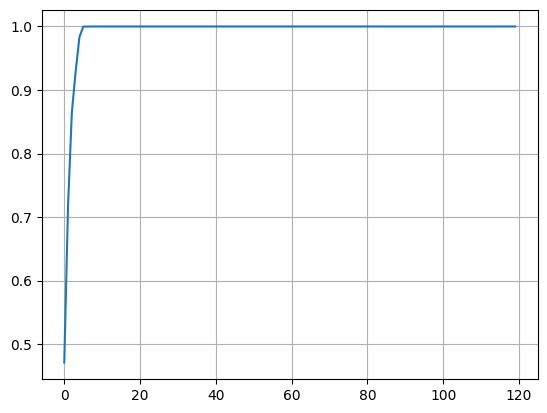

In [67]:
pca = PCA(n_components= None)
pca.fit_transform(df.iloc[:, :-1].values)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.show()

In [69]:
# cummuliative sum of varience 

np.cumsum(pca.explained_variance_ratio_)

array([0.47096205, 0.7187747 , 0.8646438 , 0.92908351, 0.98327228,
       0.99976428, 0.99985671, 0.99993301, 0.99998341, 0.99999063,
       0.99999438, 0.99999625, 0.99999707, 0.9999976 , 0.99999803,
       0.99999842, 0.99999871, 0.99999897, 0.99999919, 0.99999936,
       0.99999952, 0.99999963, 0.99999972, 0.99999981, 0.99999987,
       0.99999993, 0.99999997, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Cumulative sum of variance, also known as explained variance, is a method used to select the number of components in Principal Component Analysis (PCA). The idea is to capture as much of the total variance in the original data as possible, by retaining a subset of the principal components. The cumulative sum of variance is calculated by summing up the individual explained variances of each principal component in the order they are ranked. The explained variance of a principal component is the ratio of the eigenvalue of that component to the sum of all eigenvalues.
</br>
</br>
To determine the number of components to retain, a threshold is set, usually around 95% or 99%. The number of components required to reach this threshold is considered the optimal number of components to retain. This method is used because it is easier to visualize and compare the explained variance of different numbers of components, and also because reducing the number of components can help to avoid overfitting and reduce computational complexity.
</br>
</br>
</br>
</br>
The cumulative sum of the variance shows that after what point are the values are flattening. As we see here the valuse end up flattening after 10 point. Here we will be selecting the top 6 most significant principle components

In [70]:
n = 6

pca = PCA(n_components= n)

most_valued_data_points = pca.fit_transform(df.iloc[:, :-1].values)


DATA = pd.DataFrame(data = most_valued_data_points , columns = [ f"PC-{i+1}" for i in range(n)] )

DATA['Target'] = df.iloc[:, -1].values

data = DATA.copy()

DATA.head()

PC-1      PC-2      PC-3      PC-4      PC-5      PC-6  Target
0  0.010810 -1.698501  0.401120  0.644123  0.336230 -0.109657       0
1  2.872161 -2.498175 -0.673238  0.526026  0.352153 -0.040750       0
2  0.202537 -0.554098  0.922396  1.238247  0.166494 -0.117537       0
3  3.660913  0.960420  1.737093  0.086022  0.941597  0.497090       1
4 -3.975289 -1.275891 -0.219133 -0.072505  0.164448 -0.177778       0

In [84]:
DATA.to_csv('./train_data_PCA.csv', index= False)

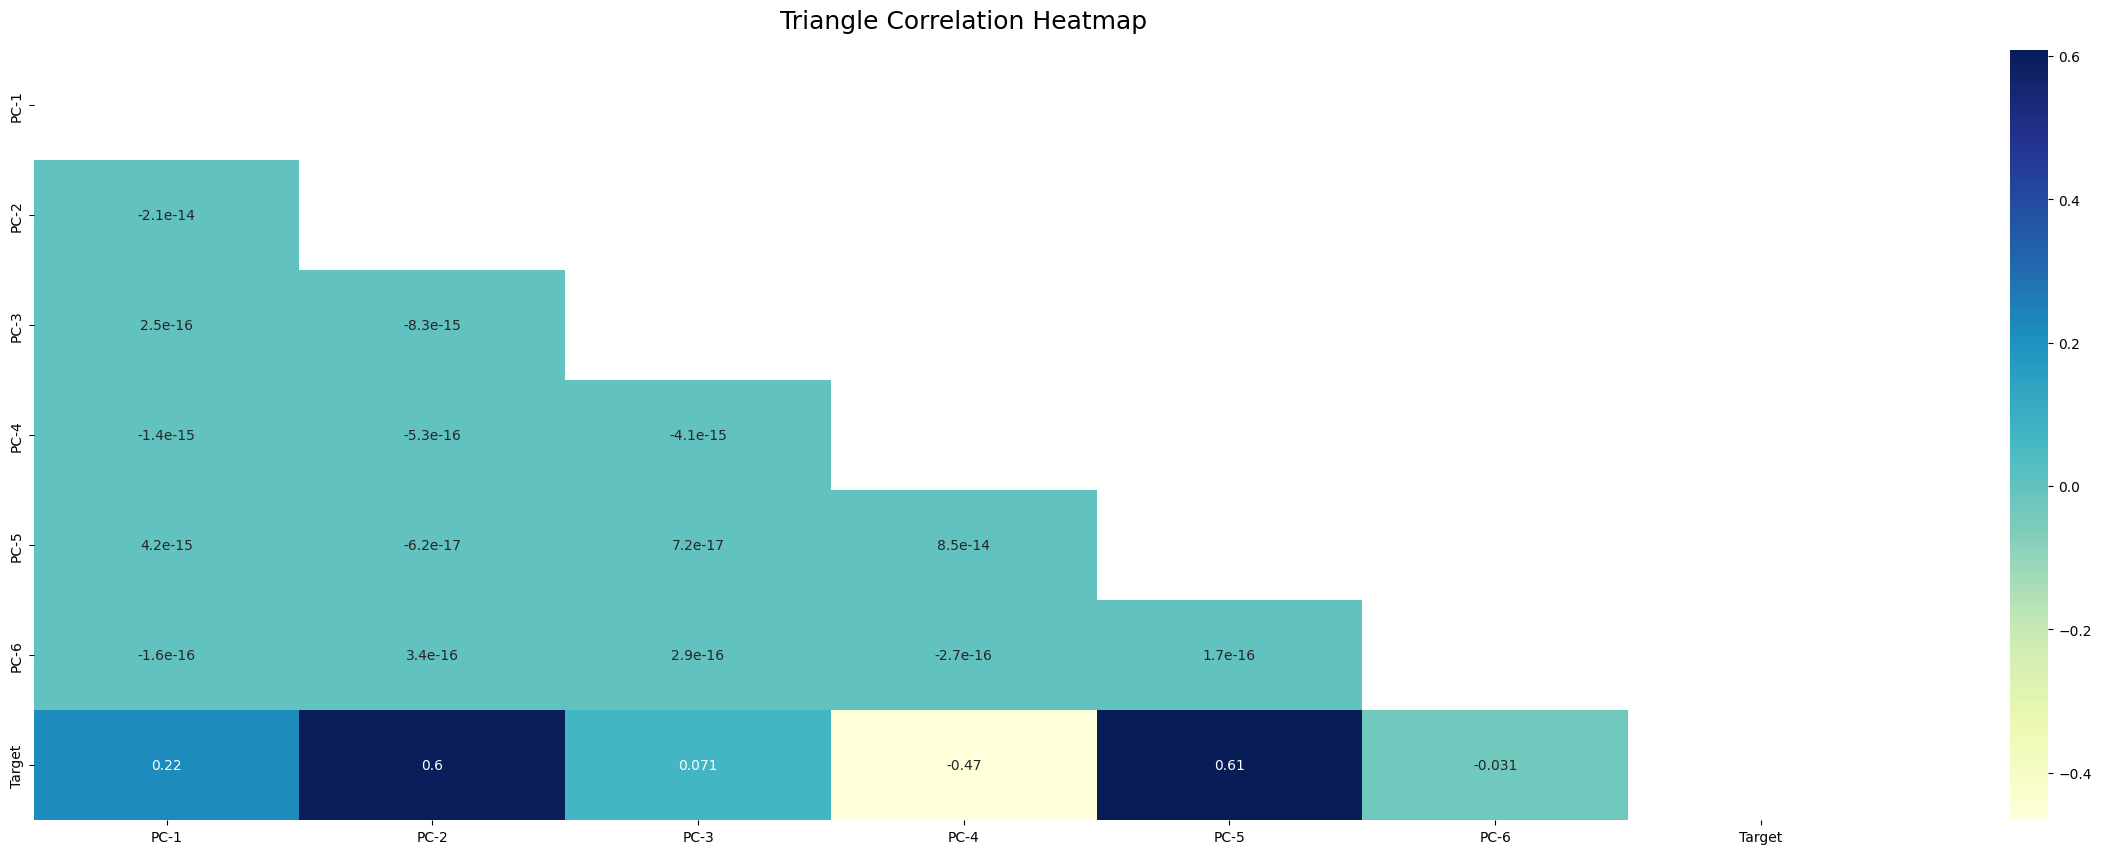

In [71]:
# Corelation Matrix

plt.figure(figsize = (30,10))

mask = np.triu(np.ones_like(DATA.corr(), dtype=np.bool))
heatmap = sns.heatmap(DATA.corr(), mask=mask, annot=True, cmap="YlGnBu")

heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [75]:
# save our PCA object 

import pickle

# with open('./pca.pkl', 'wb') as f:
#     pickle.dump(pca, f)
        
# # load the PCA object
with open('./pca.pkl', 'rb') as f:
    pca = pickle.load(f)

In [85]:
# save our list of columns

import pickle

# significat_column = df.columns.to_list()

# with open('./significat_column.pkl', 'wb') as f:
#     pickle.dump(significat_column, f)
        
# load the PCA object
with open('./significat_column.pkl', 'rb') as f:
    significat_column = pickle.load(f)